# 1. Setup

In [1]:
# Install and import necessary packages

!pip install fasttext POT networkx pandas numpy matplotlib scipy scikit-learn tqdm scikit-optimize statsmodels

import os
import json
import time
import numpy as np
import pandas as pd
import networkx as nx
import random
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import unicodedata
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import math
from itertools import combinations
import ot
import fasttext
import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import output



# 2. Utility Functions

In [2]:
def get_optimal_workers(requested_workers=None):
    """Determine the optimal number of parallel worker processes (running parallel calculations across multiple CPU threads)."""
    max_cpu = mp.cpu_count()
    optimal = max(1, max_cpu - 1 if max_cpu > 1 else 1)
    if requested_workers is None:
        print(f"Detected {max_cpu} CPUs. Using {optimal} workers.")
        return optimal
    else:
        chosen = max(1, min(requested_workers, max_cpu))
        print(f"Requested {requested_workers}, using {chosen} workers (Max CPU: {max_cpu}).")
        return chosen

def normalize_text(text):
    """Normalize text (Unicode NFC) for consistency."""
    if not isinstance(text, str):
        return str(text)
    try:
        return unicodedata.normalize('NFC', text)
    except TypeError:
        return text

def scale_value(value, min_val, max_val):
    """Scales a value to be between 0 and 1."""
    if max_val == min_val:
        return 0.5
    scaled = (value - min_val) / (max_val - min_val)
    return max(0.0, min(1.0, scaled))

print(f"Optimal workers: {get_optimal_workers()}")


Detected 96 CPUs. Using 95 workers.
Optimal workers: 95


# 3. Configuration

In [3]:
BASE_OUTPUT_DIR = "toy_network_linear_boost"
# Set the number of nodes to include in each graph (this experiment holds nodes and edges constant across conditions)
TARGET_NUM_NODES = 100
# Set the number of edges to include in each graph (constant edge count is competitive; new edges added by the experimental manipulation force out lower-ranked edges)
TARGET_NUM_EDGES = 1000
# The weight assigned to semantic similarity (inverse cosine distance) from the FastText corpus embeddings in subsequent calculations
SEMANTIC_WEIGHT = 1.0

# --- Parameters defining the different network conditions ---
# emotion_slope: Controls the slope of the linear boost applied to the interaction score
#                Boost = 1.0 + (emotion_slope * interaction_score)
#                Higher slope means stronger boost for high interaction scores where
#                Interaction score = emotional similarity [i,j] * max(Salience[i], Salience[j]) and
#                Salience = (Valence Salience + Arousal Activation)/2 and
#                Valence Salience = |V - 5|/2 and
#                Arousal Activation = max(0, A - 1.0)/8
# semantic_weight: Base contribution of semantic similarity
PARAMS = {
    'L1_Eng_Adv': {'target_num_edges': TARGET_NUM_EDGES, 'semantic_weight': SEMANTIC_WEIGHT, 'emotion_slope': 1.0},
    'L2_Eng_Adv': {'target_num_edges': TARGET_NUM_EDGES, 'semantic_weight': SEMANTIC_WEIGHT, 'emotion_slope': 0.5},
    'L2_Eng_Low': {'target_num_edges': TARGET_NUM_EDGES, 'semantic_weight': SEMANTIC_WEIGHT, 'emotion_slope': 0.0},
}

DRIVE_ROOT = '/content/drive'
DATA_DIR = os.path.join(DRIVE_ROOT, 'MyDrive')
print(f"Targeting data directory: {DATA_DIR}")

ft_model_path_en = os.path.join(DATA_DIR, "cc.en.300.bin")

os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)
print(f"Output directory created at: {BASE_OUTPUT_DIR}")


Targeting data directory: /content/drive/MyDrive
Output directory created at: toy_network_linear_boost


# 4. Data Loading


--- Loading Foundational Data (English Only) ---

Loading emotion ratings for language: en
  - Reading Valence from: /content/drive/MyDrive/en_valence.csv
    - Initial rows: 13915
    - Loaded 13915 valid valence ratings.
  - Reading Arousal from: /content/drive/MyDrive/en_arousal.csv
    - Initial rows: 13915
    - Loaded 13915 valid arousal ratings.
  - Merging Valence and Arousal data...
    - Found 13915 words with both V & A ratings.


  Creating ratings dict: 100%|██████████| 13915/13915 [00:00<00:00, 25929.90it/s]


Finished loading ratings for 13915 words for 'en'.
Loading FastText model from: /content/drive/MyDrive/cc.en.300.bin
Model loaded successfully in 9.66 seconds.
Model dimensions: 300
Word count: 2000000

--- Visualizing Emotion Ratings Distribution ---


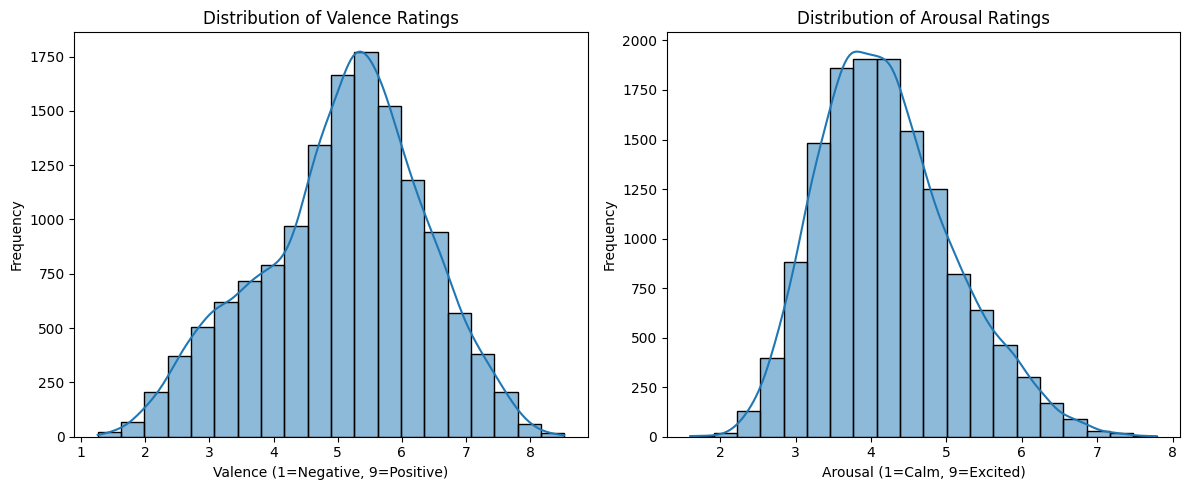

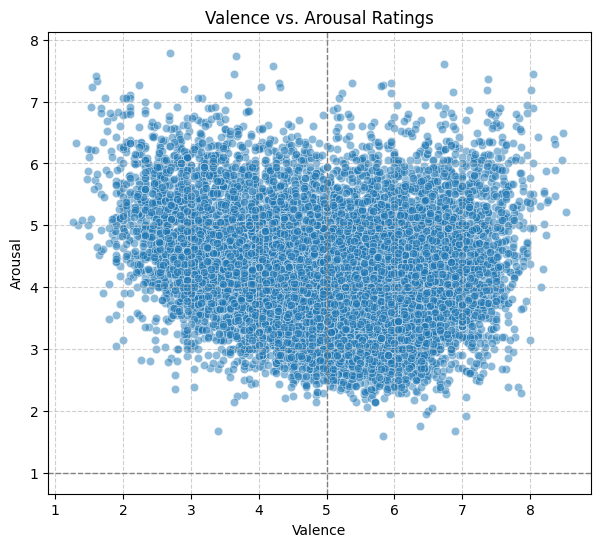

In [4]:
# Load fasttext embeddings for English and the valence & arousal ratings from Warriner et al. (2013)
# Visualize the distribution of ratings for each variable

def load_fasttext_model(language="en", model_path=None):
    """Loads a FastText model."""
    if model_path and os.path.exists(model_path):
        print(f"Loading FastText model from: {model_path}")
        start_time = time.time()
        try:
            model = fasttext.load_model(model_path)
            end_time = time.time()
            print(f"Model loaded successfully in {end_time - start_time:.2f} seconds.")
            print(f"Model dimensions: {model.get_dimension()}")
            print(f"Word count: {len(model.get_words())}")
            return model
        except Exception as e:
            print(f"Error loading FastText model from {model_path}: {e}")
            return None
    else:
        print(f"ERROR: FastText model path not provided or file not found: {model_path}")
        return None

def load_emotion_ratings(language, data_dir):
    """Loads emotion ratings by merging the Valence and Arousal CSV files."""
    print(f"\nLoading emotion ratings for language: {language}")
    valence_file = os.path.join(data_dir, f"{language}_valence.csv")
    arousal_file = os.path.join(data_dir, f"{language}_arousal.csv")
    ratings = {}

    try:
        print(f"  - Reading Valence from: {valence_file}")
        if not os.path.exists(valence_file):
            print(f"ERROR: Valence file not found: {valence_file}")
            return {}
        df_v = pd.read_csv(valence_file, encoding='utf-8')
        print(f"    - Initial rows: {len(df_v)}")

        required_v_cols = ['Word', 'Valence']
        if not all(col in df_v.columns for col in required_v_cols):
            print(f"ERROR: Valence file missing required columns: {required_v_cols}")
            return {}
        df_v = df_v[required_v_cols].copy()

        df_v['Word'] = df_v['Word'].apply(normalize_text)
        df_v['Valence'] = pd.to_numeric(df_v['Valence'], errors='coerce')
        df_v.dropna(subset=['Word', 'Valence'], inplace=True)
        df_v = df_v[df_v['Word'].astype(str).str.strip() != '']
        print(f"    - Loaded {len(df_v)} valid valence ratings.")


        print(f"  - Reading Arousal from: {arousal_file}")
        if not os.path.exists(arousal_file):
             print(f"ERROR: Arousal file not found: {arousal_file}")
             return {}
        df_a = pd.read_csv(arousal_file, encoding='utf-8')
        print(f"    - Initial rows: {len(df_a)}")

        required_a_cols = ['Word', 'Arousal']
        if not all(col in df_a.columns for col in required_a_cols):
            print(f"ERROR: Arousal file missing required columns: {required_a_cols}")
            return {}
        df_a = df_a[required_a_cols].copy()

        df_a['Word'] = df_a['Word'].apply(normalize_text)
        df_a['Arousal'] = pd.to_numeric(df_a['Arousal'], errors='coerce')
        df_a.dropna(subset=['Word', 'Arousal'], inplace=True)
        df_a = df_a[df_a['Word'].astype(str).str.strip() != '']
        print(f"    - Loaded {len(df_a)} valid arousal ratings.")


        print("  - Merging Valence and Arousal data...")

        df_merged = pd.merge(df_v, df_a, on='Word', how='inner')
        print(f"    - Found {len(df_merged)} words with both V & A ratings.")


        for _, row in tqdm(df_merged.iterrows(), total=len(df_merged), desc="  Creating ratings dict"):
            ratings[row['Word']] = {'Valence': row['Valence'], 'Arousal': row['Arousal']}

        print(f"Finished loading ratings for {len(ratings)} words for '{language}'.")

    except FileNotFoundError as e:
        print(f"ERROR: Ratings file not found: {e.filename}")
        return {}
    except Exception as e:
        print(f"ERROR: An error occurred while reading/processing ratings files for {language}: {e}")
        import traceback
        traceback.print_exc()
        return {}

    return ratings, df_merged


print("\n--- Loading Foundational Data (English Only) ---")

ratings_en_dict, ratings_en_df = load_emotion_ratings(language='en', data_dir=DATA_DIR)
ft_model_en = load_fasttext_model(language="en", model_path=ft_model_path_en)

if not ratings_en_df.empty:
    print("\n--- Visualizing Emotion Ratings Distribution ---")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(ratings_en_df['Valence'], kde=True, bins=20)
    plt.title('Distribution of Valence Ratings')
    plt.xlabel('Valence (1=Negative, 9=Positive)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(ratings_en_df['Arousal'], kde=True, bins=20)
    plt.title('Distribution of Arousal Ratings')
    plt.xlabel('Arousal (1=Calm, 9=Excited)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=ratings_en_df, x='Valence', y='Arousal', alpha=0.5)
    plt.title('Valence vs. Arousal Ratings')
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(1, color='grey', linestyle='--', lw=1)
    plt.axvline(5, color='grey', linestyle='--', lw=1)
    plt.show()
else:
    print("\nSkipping visualization as no ratings data was loaded.")



# 5. Word Selection


--- Selecting English Words (Density-Weighted) ---

Selecting 100 words using DENSITY-WEIGHTED sampling...
  - Filtering words with both ratings and valid embeddings...


Checking word availability: 100%|██████████| 13915/13915 [00:10<00:00, 1326.65it/s]


  - Found 13808 available words for selection.
  - Estimating V/A density and calculating sampling weights...
    - Calculated sampling weights (Min Density=2.49e-04, Max Density=1.90e-01)
  - Performing weighted random sampling (favoring low-density regions)...

Selected 100 words via density-weighted sampling.

--- Visualizing Selected Words Distribution ---


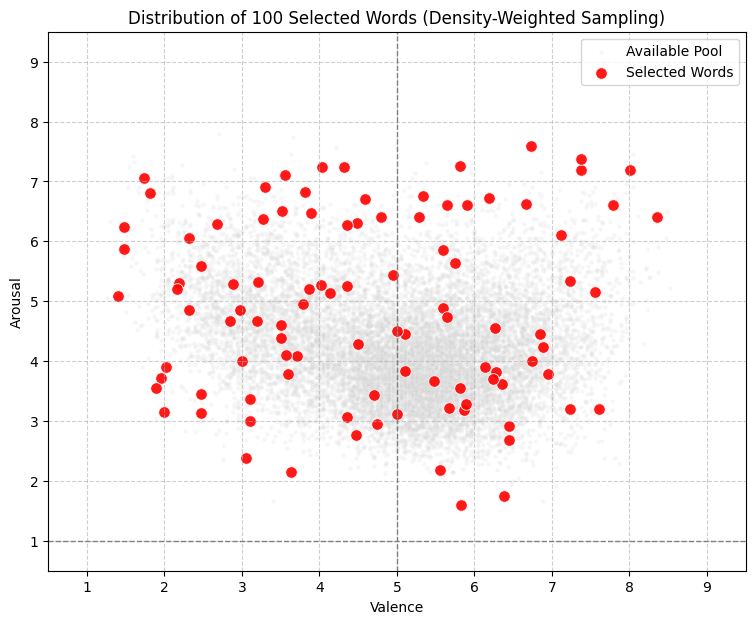

In [5]:
# Density-weighted selection of n words (where n = TARGET_NUM_NODES) preserving the distribution of ratings in the original dataset

def select_words_density_weighted(ratings_dict, ratings_df, ft_model, num_words=30, va_range=(1, 9)):
    """
    Selects words attempting to get an even spatial distribution across V&A space
    using Density-Weighted sampling. Words in sparser V/A regions are given
    a higher probability of selection.

    Args:
        ratings_dict (dict): Dictionary mapping words to {'Valence': v, 'Arousal': a}.
        ratings_df (pd.DataFrame): DataFrame containing 'Word', 'Valence', 'Arousal'.
        ft_model (fasttext.FastText._FastText): Loaded FastText model.
        num_words (int): Target number of words to select.
        va_range (tuple): The min and max theoretical values for V/A scales (e.g., (1, 9)).

    Returns:
        list: A list of selected words.
        pd.DataFrame: DataFrame containing only the selected words and their ratings.
    """
    print(f"\nSelecting {num_words} words using DENSITY-WEIGHTED sampling...")
    min_rating, max_rating = va_range

    available_words_info = []
    embeddings_avail = {}
    print("  - Filtering words with both ratings and valid embeddings...")
    for index, row in tqdm(ratings_df.iterrows(), total=len(ratings_df), desc="Checking word availability"):
        word = row['Word']
        try:
            if word in ft_model:
                vec = ft_model.get_word_vector(word)
                if np.linalg.norm(vec) > 1e-9:
                    if pd.notna(row['Valence']) and pd.notna(row['Arousal']):
                         available_words_info.append({
                             'Word': word,
                             'Valence': row['Valence'],
                             'Arousal': row['Arousal']
                         })
                         embeddings_avail[word] = vec
        except Exception: continue

    if not available_words_info: print("ERROR: No words found with ratings and embeddings."); return [], pd.DataFrame()
    df_avail = pd.DataFrame(available_words_info)
    print(f"  - Found {len(df_avail)} available words for selection.")
    if len(df_avail) < num_words: print(f"WARNING: Only {len(df_avail)} words available. Selecting all."); return df_avail['Word'].tolist(), df_avail

    # --- 2. Estimate Density and Calculate Weights ---
    print("  - Estimating V/A density and calculating sampling weights...")

    # Prepare data points for KDE (Valence, Arousal)
    points = df_avail[['Valence', 'Arousal']].values.T

    # Perform Kernel Density Estimation
    kde = gaussian_kde(points)
    # Evaluate density at each word's location
    densities = kde.evaluate(points)

    # Calculate weights: inversely proportional to density
    # Add small epsilon to prevent division by zero if density is exactly 0
    epsilon = 1e-9
    weights = 1.0 / (densities + epsilon)

    # Normalize weights so they can be used by pd.sample
    weights /= weights.sum()

    # Add weights to the DataFrame
    df_avail['sampling_weight'] = weights
    print(f"    - Calculated sampling weights (Min Density={densities.min():.2e}, Max Density={densities.max():.2e})")

    # --- 3. Weighted Sampling ---
    print(f"  - Performing weighted random sampling (favoring low-density regions)...")

    selected_df = df_avail.sample(n=num_words, weights='sampling_weight', random_state=42, replace=False)
    selected_words = selected_df['Word'].tolist()

    print(f"\nSelected {len(selected_words)} words via density-weighted sampling.")
    return selected_words, selected_df

# --- Execute Word Selection (Using Density-Weighted Method) ---

print("\n--- Selecting English Words (Density-Weighted) ---")

# Ensure prerequisites are met before proceeding
if 'ratings_en_dict' in locals() and 'ratings_en_df' in locals() and 'ft_model_en' in locals() \
   and ratings_en_dict and not ratings_en_df.empty and ft_model_en:

    # Call the density-weighted function
    selected_words_en, selected_words_df = select_words_density_weighted(
        ratings_dict=ratings_en_dict,
        ratings_df=ratings_en_df,
        ft_model=ft_model_en,
        num_words=TARGET_NUM_NODES,
        va_range=(1, 9)
    )

    # --- Visualize Selected Words Distribution ---
    if not selected_words_df.empty:
        print("\n--- Visualizing Selected Words Distribution ---")
        plt.figure(figsize=(9, 7))
        sns.scatterplot(data=ratings_en_df, x='Valence', y='Arousal', color='lightgrey', alpha=0.2, s=10, label='Available Pool')
        sns.scatterplot(data=selected_words_df, x='Valence', y='Arousal', alpha=0.9, s=70, label='Selected Words', color='red')
        plt.title(f'Distribution of {len(selected_words_en)} Selected Words (Density-Weighted Sampling)')
        plt.xlabel('Valence')
        plt.ylabel('Arousal')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axhline(1, color='grey', linestyle='--', lw=1)
        plt.axvline(5, color='grey', linestyle='--', lw=1)
        plt.legend()
        plt.xlim(0.5, 9.5); plt.ylim(0.5, 9.5)
        plt.show()

else:
    print("Skipping word selection due to missing ratings or FastText model.")
    selected_words_en = []
    selected_words_df = pd.DataFrame()


# 6. Network Generation

In [7]:
# --- Network Generation Function ---

def generate_boosted_network(words, ft_model, ratings_dict, condition_params):
    """
    Generates a synthetic network with a fixed number of edges, where high (emotional similarity*interaction score) edges are boosted according to
    emotion_slope. Edges are ranked and culled down to to target_number_edges in a competitive process. Therefore, the emotion_slope
    parameter drives the varying distribution of edges between networks conditions.

    Args:
        words (list): The list of words (nodes) to include in the network.
        ft_model (fasttext.FastText._FastText): Loaded FastText model.
        ratings_dict (dict): Dictionary mapping words to {'Valence': v, 'Arousal': a}.
        condition_params (dict): Dictionary containing parameters for this condition:
            'target_num_edges', 'semantic_weight', 'emotion_slope'.

    Returns:
        networkx.Graph: The generated graph.
    """
    # Extract parameters
    target_num_edges = condition_params.get('target_num_edges')
    semantic_weight = condition_params.get('semantic_weight')
    emotion_slope = condition_params.get('emotion_slope')

    print(f"\nGenerating boosted network (Target Edges={target_num_edges})...")
    print(f"  Parameters: Sem Weight={semantic_weight:.2f}, Emo Slope={emotion_slope:.2f}")
    print(f"  Using Salience: Val (dist from 5), Aro (dist from 1) & LINEAR Boost")

    n = len(words)
    G = nx.Graph(); G.add_nodes_from(words)
    if n <= 1: print("  - Not enough nodes."); return G

    print("  - Pre-calculating embeddings, ratings, and similarities...")
    embeddings = {word: ft_model.get_word_vector(word) for word in words if word in ft_model}
    word_ratings_arrays = {
        word: np.array([ratings_dict[word]['Valence'], ratings_dict[word]['Arousal']])
        for word in words
        if word in ratings_dict and
           pd.notna(ratings_dict[word].get('Valence')) and
           pd.notna(ratings_dict[word].get('Arousal'))
    }

    valid_ratings = list(word_ratings_arrays.values())
    sem_sim_raw = np.zeros((n, n))
    emo_sim = np.zeros((n, n))
    word_combined_salience = np.zeros(n)

    vals = [r[0] for r in valid_ratings]; aros = [r[1] for r in valid_ratings]
    min_val, max_val = min(vals), max(vals); min_aro, max_aro = min(aros), max(aros)
    VALENCE_MIDPOINT = 5.0; AROUSAL_MIN = 1.0
    max_val_dist_from_mid = max(abs(min_val - VALENCE_MIDPOINT), abs(max_val - VALENCE_MIDPOINT)) if vals else 4.0
    max_aro_dist_from_min = (max_aro - AROUSAL_MIN) if aros else 8.0
    if max_val_dist_from_mid < 1e-9: max_val_dist_from_mid = 4.0
    if max_aro_dist_from_min < 1e-9: max_aro_dist_from_min = 8.0
    va_range_sq = (max_val - min_val)**2 + (max_aro - min_aro)**2
    max_va_dist_from_each_other = np.sqrt(va_range_sq) if va_range_sq > 1e-9 else 1.0

    print(f"    - V Range (fold): [{min_val:.2f}, {max_val:.2f}], A Range (fold): [{min_aro:.2f}, {max_aro:.2f}]")
    print(f"    - Max Val dist from mid: {max_val_dist_from_mid:.2f}, Max Aro dist from min: {max_aro_dist_from_min:.2f}")
    print(f"    - Max V/A distance between words: {max_va_dist_from_each_other:.2f}")

    print("  - Calculating pairwise similarities and word salience...")
    for i in range(n):
        word_i = words[i]; vec_i = embeddings.get(word_i)
        rating_i_array = word_ratings_arrays.get(word_i)
        if rating_i_array is not None:
            v_i, a_i = rating_i_array
            scaled_val_salience = abs(v_i - VALENCE_MIDPOINT) / max_val_dist_from_mid
            scaled_aro_activation = max(0.0, a_i - AROUSAL_MIN) / max_aro_dist_from_min
            word_combined_salience[i] = max(0.0, min(1.0, (scaled_val_salience + scaled_aro_activation) / 2.0))
        else: word_combined_salience[i] = 0.0

        for j in range(i + 1, n):
            word_j = words[j]; vec_j = embeddings.get(word_j)
            rating_j_array = word_ratings_arrays.get(word_j)
            if vec_i is not None and vec_j is not None:
                norm_i = np.linalg.norm(vec_i); norm_j = np.linalg.norm(vec_j)
                if norm_i > 1e-9 and norm_j > 1e-9:
                      cos_sim = np.dot(vec_i, vec_j) / (norm_i * norm_j)
                      sem_sim_raw[i, j] = sem_sim_raw[j, i] = max(0.0, min(1.0, cos_sim))
                else: sem_sim_raw[i, j] = sem_sim_raw[j, i] = 0.0
            else: sem_sim_raw[i, j] = sem_sim_raw[j, i] = 0.0

            if rating_i_array is not None and rating_j_array is not None:
                dist = euclidean(rating_i_array, rating_j_array)
                emo_sim[i, j] = emo_sim[j, i] = 1.0 - scale_value(dist, 0, max_va_dist_from_each_other)
            else: emo_sim[i, j] = emo_sim[j, i] = 0.5

    # --- Calculate final edge scores ---
    print("  - Calculating final edge scores with linear emotional salience boost...")
    potential_edges = []
    for i in range(n):
        for j in range(i + 1, n):
            salience_i = word_combined_salience[i] if i < len(word_combined_salience) else 0.0
            salience_j = word_combined_salience[j] if j < len(word_combined_salience) else 0.0
            interaction_score = emo_sim[i, j] * max(salience_i, salience_j)
            interaction_score = max(0.0, min(1.0, interaction_score))

            # Linear boost calculation
            boost = 1.0 + (emotion_slope * interaction_score)

            base_score = semantic_weight * sem_sim_raw[i, j]
            final_score = base_score * boost

            if final_score > 1e-9:
                potential_edges.append((words[i], words[j], final_score, sem_sim_raw[i, j]))

    # --- Select top edges based on final score (edges are competitive due to fixed maximum) ---
    print(f"  - Ranking {len(potential_edges)} potential edges by final score...")
    potential_edges.sort(key=lambda x: x[2], reverse=True)
    actual_num_edges = min(target_num_edges, len(potential_edges))
    selected_edges = potential_edges[:actual_num_edges]
    print(f"  - Selecting top {actual_num_edges} edges.")

    # Add selected edges to the graph
    for u, v, score, sem_weight in selected_edges:
        G.add_edge(u, v, weight=sem_weight)

    print(f"  - Generated graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

# --- Execute Network Generation for each condition ---
print("\n--- Generating Toy Networks ---")

graphs = {}

# Ensure necessary variables from previous cells exist
if 'selected_words_en' in locals() and selected_words_en and \
   'ft_model_en' in locals() and ft_model_en and \
   'ratings_en_dict' in locals() and ratings_en_dict and \
   'PARAMS' in locals():

    for condition_name, params in PARAMS.items():
        print(f"\n--- Generating Network for Condition: {condition_name} ---")
        graphs[condition_name] = generate_boosted_network(
            selected_words_en,
            ft_model_en,
            ratings_en_dict,
            params
        )

    # Add a copy of the L1 graph for the 2x2 plot layout later
    if 'L1_Eng_Adv' in graphs:
        graphs['L1_Eng_Adv_Comp'] = graphs['L1_Eng_Adv'].copy()
        print("\nAdded copy of L1_Eng_Adv graph for comparison layout.")
    else:
         print("\nWarning: L1_Eng_Adv graph not generated, cannot create copy.")

else:
    print("Skipping network generation due to missing prerequisites (selected_words_en, ft_model_en, ratings_en_dict, or PARAMS).")
    # Create empty graphs dict if skipping
    graphs = {name: nx.Graph() for name in PARAMS.keys()}
    if 'L1_Eng_Adv' in graphs: graphs['L1_Eng_Adv_Comp'] = nx.Graph()


# Display number of nodes/edges for generated graphs
print("\n--- Generated Graph Summary ---")
for name, G in graphs.items():
    if name != 'L1_Eng_Adv_Comp':
      print(f"Graph '{name}': {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")



--- Generating Toy Networks ---

--- Generating Network for Condition: L1_Eng_Adv ---

Generating boosted network (Target Edges=1000)...
  Parameters: Sem Weight=1.00, Emo Slope=1.00
  Using Salience: Val (dist from 5), Aro (dist from 1) & LINEAR Boost
  - Pre-calculating embeddings, ratings, and similarities...
    - V Range (fold): [1.40, 8.36], A Range (fold): [1.60, 7.60]
    - Max Val dist from mid: 3.60, Max Aro dist from min: 6.60
    - Max V/A distance between words: 9.19
  - Calculating pairwise similarities and word salience...
  - Calculating final edge scores with linear emotional salience boost...
  - Ranking 4682 potential edges by final score...
  - Selecting top 1000 edges.
  - Generated graph with 100 nodes and 1000 edges.

--- Generating Network for Condition: L2_Eng_Adv ---

Generating boosted network (Target Edges=1000)...
  Parameters: Sem Weight=1.00, Emo Slope=0.50
  Using Salience: Val (dist from 5), Aro (dist from 1) & LINEAR Boost
  - Pre-calculating embeddin

# 7. Network Metrics Calculation

In [8]:
# --- Network Metrics Calculation ---

print("\n--- Calculating Network Metrics ---")

network_metrics = {}

for name, G in graphs.items():
    # Skip the comparison copy graph for metrics calculation display
    if name == 'L1_Eng_Adv_Comp':
        if 'L1_Eng_Adv' in network_metrics:
             network_metrics[name] = network_metrics['L1_Eng_Adv'].copy()
        else:
             network_metrics[name] = {}
        continue

    print(f"\nCalculating metrics for: {name}")
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    metrics = {'Nodes': num_nodes, 'Edges': num_edges}

    if num_nodes > 1:
        # --- Density ---
        density = nx.density(G)
        metrics['Density'] = density
        print(f"  - Density: {density:.4f}")

        # --- Average Clustering Coefficient (Weighted) ---
        # Uses original similarity weights ('weight')
        try:
            clustering = nx.average_clustering(G, weight='weight')
        except ZeroDivisionError: clustering = 0.0
        except Exception as e: print(f"    - Warning: Could not calculate clustering for {name}: {e}"); clustering = np.nan
        metrics['Clustering'] = clustering
        print(f"  - Avg Clustering (Weighted): {clustering:.4f}" if pd.notna(clustering) else "  - Avg Clustering (Weighted): N/A")

        # --- Centrality Measures (Calculated on Largest Connected Component if disconnected) ---
        avg_betweenness = np.nan
        avg_eigenvector = np.nan
        avg_closeness = np.nan

        if num_edges > 0:
            components = list(nx.connected_components(G))
            is_connected = (len(components) == 1)
            largest_cc_subgraph = None
            nodes_in_lcc = set()

            if is_connected:
                largest_cc_subgraph = G
                nodes_in_lcc = set(G.nodes())
            else:
                if components:
                    largest_cc_nodes = max(components, key=len)
                    if len(largest_cc_nodes) > 1:
                        largest_cc_subgraph = G.subgraph(largest_cc_nodes).copy()
                        nodes_in_lcc = largest_cc_nodes

            # Calculate centralities if there is a valid subgraph
            if largest_cc_subgraph is not None and largest_cc_subgraph.number_of_nodes() > 1:
                subgraph_nodes_count = largest_cc_subgraph.number_of_nodes()

                # --- Calculate Inverted Weights (Distance) for Betweenness & Closeness ---
                try:
                    max_similarity = 1.0
                    for u, v, data in largest_cc_subgraph.edges(data=True):
                        similarity = data.get('weight', 0.0)
                        distance = max_similarity - similarity if isinstance(similarity, (int, float)) and 0.0 <= similarity <= max_similarity else max_similarity
                        # Ensure distance is slightly positive if similarity is max
                        if distance <= 0: distance = 1e-9
                        largest_cc_subgraph[u][v]['distance'] = distance
                    distance_attr_added = True
                except Exception as e:
                    print(f"    - Warning: Could not create distance attribute for {name}: {e}")
                    distance_attr_added = False

                # --- Average Betweenness Centrality (Using inverted Weight) ---
                if distance_attr_added:
                    try:
                        betweenness_dict = nx.betweenness_centrality(largest_cc_subgraph, weight='distance', normalized=True)
                        avg_betweenness = np.mean(list(betweenness_dict.values()))
                        print(f"  - Avg Betweenness Centrality (Inv Weight, {'Connected' if is_connected else 'Largest CC'}): {avg_betweenness:.4f}")
                    except Exception as e:
                        print(f"    - Warning: Could not calculate betweenness centrality for {name}: {e}")
                        avg_betweenness = np.nan
                else:
                     avg_betweenness = np.nan

                # --- Average Closeness Centrality (Using inverted Weight) ---
                if distance_attr_added:
                     try:
                          closeness_dict = nx.closeness_centrality(largest_cc_subgraph, distance='distance')
                          avg_closeness = np.mean(list(closeness_dict.values()))
                          print(f"  - Avg Closeness Centrality (Inv Weight, {'Connected' if is_connected else 'Largest CC'}): {avg_closeness:.4f}")
                     except Exception as e:
                          print(f"    - Warning: Could not calculate closeness centrality for {name}: {e}")
                          avg_closeness = np.nan
                else:
                     avg_closeness = np.nan

                # --- Average Eigenvector Centrality (Using original Weight) ---
                try:
                    eigenvector_dict = nx.eigenvector_centrality(largest_cc_subgraph, weight='weight', max_iter=1000, tol=1e-06)
                    avg_eigenvector = np.mean(list(eigenvector_dict.values()))
                    print(f"  - Avg Eigenvector Centrality (Orig Weight, {'Connected' if is_connected else 'Largest CC'}): {avg_eigenvector:.4f}")
                except nx.PowerIterationFailedConvergence:
                     print(f"    - Warning: Eigenvector centrality did not converge for {name}.")
                     avg_eigenvector = np.nan
                except Exception as e:
                    print(f"    - Warning: Could not calculate eigenvector centrality for {name}: {e}")
                    avg_eigenvector = np.nan

        metrics['Avg Betweenness Centrality'] = avg_betweenness if pd.notna(avg_betweenness) else 'N/A'
        metrics['Avg Closeness Centrality'] = avg_closeness if pd.notna(avg_closeness) else 'N/A'
        metrics['Avg Eigenvector Centrality'] = avg_eigenvector if pd.notna(avg_eigenvector) else 'N/A'

    else: # Only 0 or 1 node
        metrics['Density'] = 0.0
        metrics['Clustering'] = 0.0
        metrics['Avg Betweenness Centrality'] = 0.0 if num_nodes == 1 else 'N/A'
        metrics['Avg Closeness Centrality'] = 0.0 if num_nodes == 1 else 'N/A'
        metrics['Avg Eigenvector Centrality'] = 1.0 if num_nodes == 1 else 'N/A'


    network_metrics[name] = metrics

# --- Display Metrics Summary ---
print("\n--- Network Metrics Summary ---")
metrics_to_display = {k: v for k, v in network_metrics.items() if k != 'L1_Eng_Adv_Comp'}
metrics_df = pd.DataFrame(metrics_to_display).T
# Add Closeness to column order
cols_order = ['Nodes', 'Edges', 'Density', 'Clustering', 'Avg Betweenness Centrality', 'Avg Closeness Centrality', 'Avg Eigenvector Centrality']
existing_cols = [col for col in cols_order if col in metrics_df.columns]
metrics_df = metrics_df[existing_cols]
metrics_df = metrics_df.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) and pd.notna(x) else x)
print(metrics_df)



--- Calculating Network Metrics ---

Calculating metrics for: L1_Eng_Adv
  - Density: 0.2020
  - Avg Clustering (Weighted): 0.1342
  - Avg Betweenness Centrality (Inv Weight, Connected): 0.0095
  - Avg Closeness Centrality (Inv Weight, Connected): 0.7218
  - Avg Eigenvector Centrality (Orig Weight, Connected): 0.0843

Calculating metrics for: L2_Eng_Adv
  - Density: 0.2020
  - Avg Clustering (Weighted): 0.1316
  - Avg Betweenness Centrality (Inv Weight, Connected): 0.0093
  - Avg Closeness Centrality (Inv Weight, Connected): 0.7262
  - Avg Eigenvector Centrality (Orig Weight, Connected): 0.0850

Calculating metrics for: L2_Eng_Low
  - Density: 0.2020
  - Avg Clustering (Weighted): 0.1307
  - Avg Betweenness Centrality (Inv Weight, Connected): 0.0093
  - Avg Closeness Centrality (Inv Weight, Connected): 0.7278
  - Avg Eigenvector Centrality (Orig Weight, Connected): 0.0859

--- Network Metrics Summary ---
               Nodes      Edges Density Clustering Avg Betweenness Centrality  \


<ipython-input-8-55b97aae2b71>:133: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) and pd.notna(x) else x)


# 8. GWOT

In [9]:
# --- GW Comparison Function ---

def compare_structures_gw(G1, G2, name1="G1", name2="G2", verbose=False):
    """
    Compares two graphs using Gromov-Wasserstein distance based on their weighted adjacency matrices.

    Args:
        G1 (nx.Graph): First graph.
        G2 (nx.Graph): Second graph.
        name1 (str): Name of the first graph for printing.
        name2 (str): Name of the second graph for printing.
        verbose (bool): Whether to print detailed logs from the GW computation.

    Returns:
        float: The computed Gromov-Wasserstein distance (GW distance). Returns np.nan on error.
        dict: The log dictionary returned by ot.gromov.gromov_wasserstein2 (empty on error).
    """
    print(f"\nComparing structures: {name1} vs {name2} using Gromov-Wasserstein...")

    nodes1 = sorted(list(G1.nodes()))
    nodes2 = sorted(list(G2.nodes()))
    n1 = len(nodes1)
    n2 = len(nodes2)

    if n1 == 0 or n2 == 0:
        print("Error: One or both input graphs are empty.")
        return np.nan, {}

    # --- Create Cost Matrices (Weighted Adjacency Matrices) ---
    print(f"  - Creating cost matrices ({n1}x{n1} and {n2}x{n2})...")
    C1 = nx.to_numpy_array(G1, nodelist=nodes1, weight='weight', dtype=np.float64, nonedge=0.0)
    C2 = nx.to_numpy_array(G2, nodelist=nodes2, weight='weight', dtype=np.float64, nonedge=0.0)

    # --- Normalize Cost Matrices ---
    # Normalize by max value to scale distances between 0 and 1
    max_c1 = np.max(C1)
    C1_norm = C1 / max_c1 if max_c1 > 1e-9 else C1
    max_c2 = np.max(C2)
    C2_norm = C2 / max_c2 if max_c2 > 1e-9 else C2
    print(f"    - Max weights before norm: C1={max_c1:.4f}, C2={max_c2:.4f}")

    # --- Define Node Distributions ---
    # Use uniform distributions assuming all nodes have equal importance.
    p = ot.unif(n1)
    q = ot.unif(n2)

    # --- Compute GW Distance ---
    try:
        print("  - Computing GW distance using ot.gromov.gromov_wasserstein2...")
        # loss function='square_loss'
        gw_dist, log = ot.gromov.gromov_wasserstein2(
            C1=C1_norm, C2=C2_norm,
            p=p, q=q,
            loss_fun='square_loss',
            log=True, verbose=verbose
        )
        print(f"  - GW Distance ({name1} vs {name2}) = {gw_dist:.6f}")
        return gw_dist, log
    except Exception as e:
        print(f"ERROR during GW computation ({name1} vs {name2}): {e}")
        import traceback
        traceback.print_exc()
        return np.nan, {}

# --- Execute Pairwise GW Comparisons ---

print("\n--- Performing GW Comparisons (Structure Only) ---")

gw_distances = {}

# Check if graphs exist before comparing
graph_keys = list(graphs.keys())
pairs_to_compare = []
if 'L1_Eng_Adv' in graph_keys and 'L2_Eng_Low' in graph_keys:
    pairs_to_compare.append(('L1_Eng_Adv', 'L2_Eng_Low'))
if 'L1_Eng_Adv' in graph_keys and 'L2_Eng_Adv' in graph_keys:
    pairs_to_compare.append(('L1_Eng_Adv', 'L2_Eng_Adv'))
# Compare L2 conditions
if 'L2_Eng_Adv' in graph_keys and 'L2_Eng_Low' in graph_keys:
     pairs_to_compare.append(('L2_Eng_Adv', 'L2_Eng_Low'))


if not pairs_to_compare:
    print("Not enough graphs generated to perform comparisons.")
else:
    for name1, name2 in pairs_to_compare:
        gw_dist, _ = compare_structures_gw(graphs[name1], graphs[name2], name1=name1, name2=name2)
        # Store the result, handling potential NaN from errors
        gw_distances[(name1, name2)] = gw_dist if pd.notna(gw_dist) else 0.0

# --- Display GW Results ---
print("\n--- GW Distance Summary ---")
if gw_distances:
    for (n1, n2), dist in gw_distances.items():
        print(f"GW Dist ({n1} vs {n2}): {dist:.6f}" if pd.notna(dist) else f"GW Dist ({n1} vs {n2}): Error/N/A")
else:
    print("No GW distances were calculated.")



--- Performing GW Comparisons (Structure Only) ---

Comparing structures: L1_Eng_Adv vs L2_Eng_Low using Gromov-Wasserstein...
  - Creating cost matrices (100x100 and 100x100)...
    - Max weights before norm: C1=0.7519, C2=0.7519
  - Computing GW distance using ot.gromov.gromov_wasserstein2...
  - GW Distance (L1_Eng_Adv vs L2_Eng_Low) = 0.018746

Comparing structures: L1_Eng_Adv vs L2_Eng_Adv using Gromov-Wasserstein...
  - Creating cost matrices (100x100 and 100x100)...
    - Max weights before norm: C1=0.7519, C2=0.7519
  - Computing GW distance using ot.gromov.gromov_wasserstein2...
  - GW Distance (L1_Eng_Adv vs L2_Eng_Adv) = 0.000802

Comparing structures: L2_Eng_Adv vs L2_Eng_Low using Gromov-Wasserstein...
  - Creating cost matrices (100x100 and 100x100)...
    - Max weights before norm: C1=0.7519, C2=0.7519
  - Computing GW distance using ot.gromov.gromov_wasserstein2...
  - GW Distance (L2_Eng_Adv vs L2_Eng_Low) = 0.017364

--- GW Distance Summary ---
GW Dist (L1_Eng_Adv vs

# 9. Network Visualizations


--- Creating Visualizations (Valence and Arousal) ---

Creating visualization (Valence coloring): toy_network_linear_boost/Network_Comparison_Valence.png
Saved visualization to toy_network_linear_boost/Network_Comparison_Valence.png


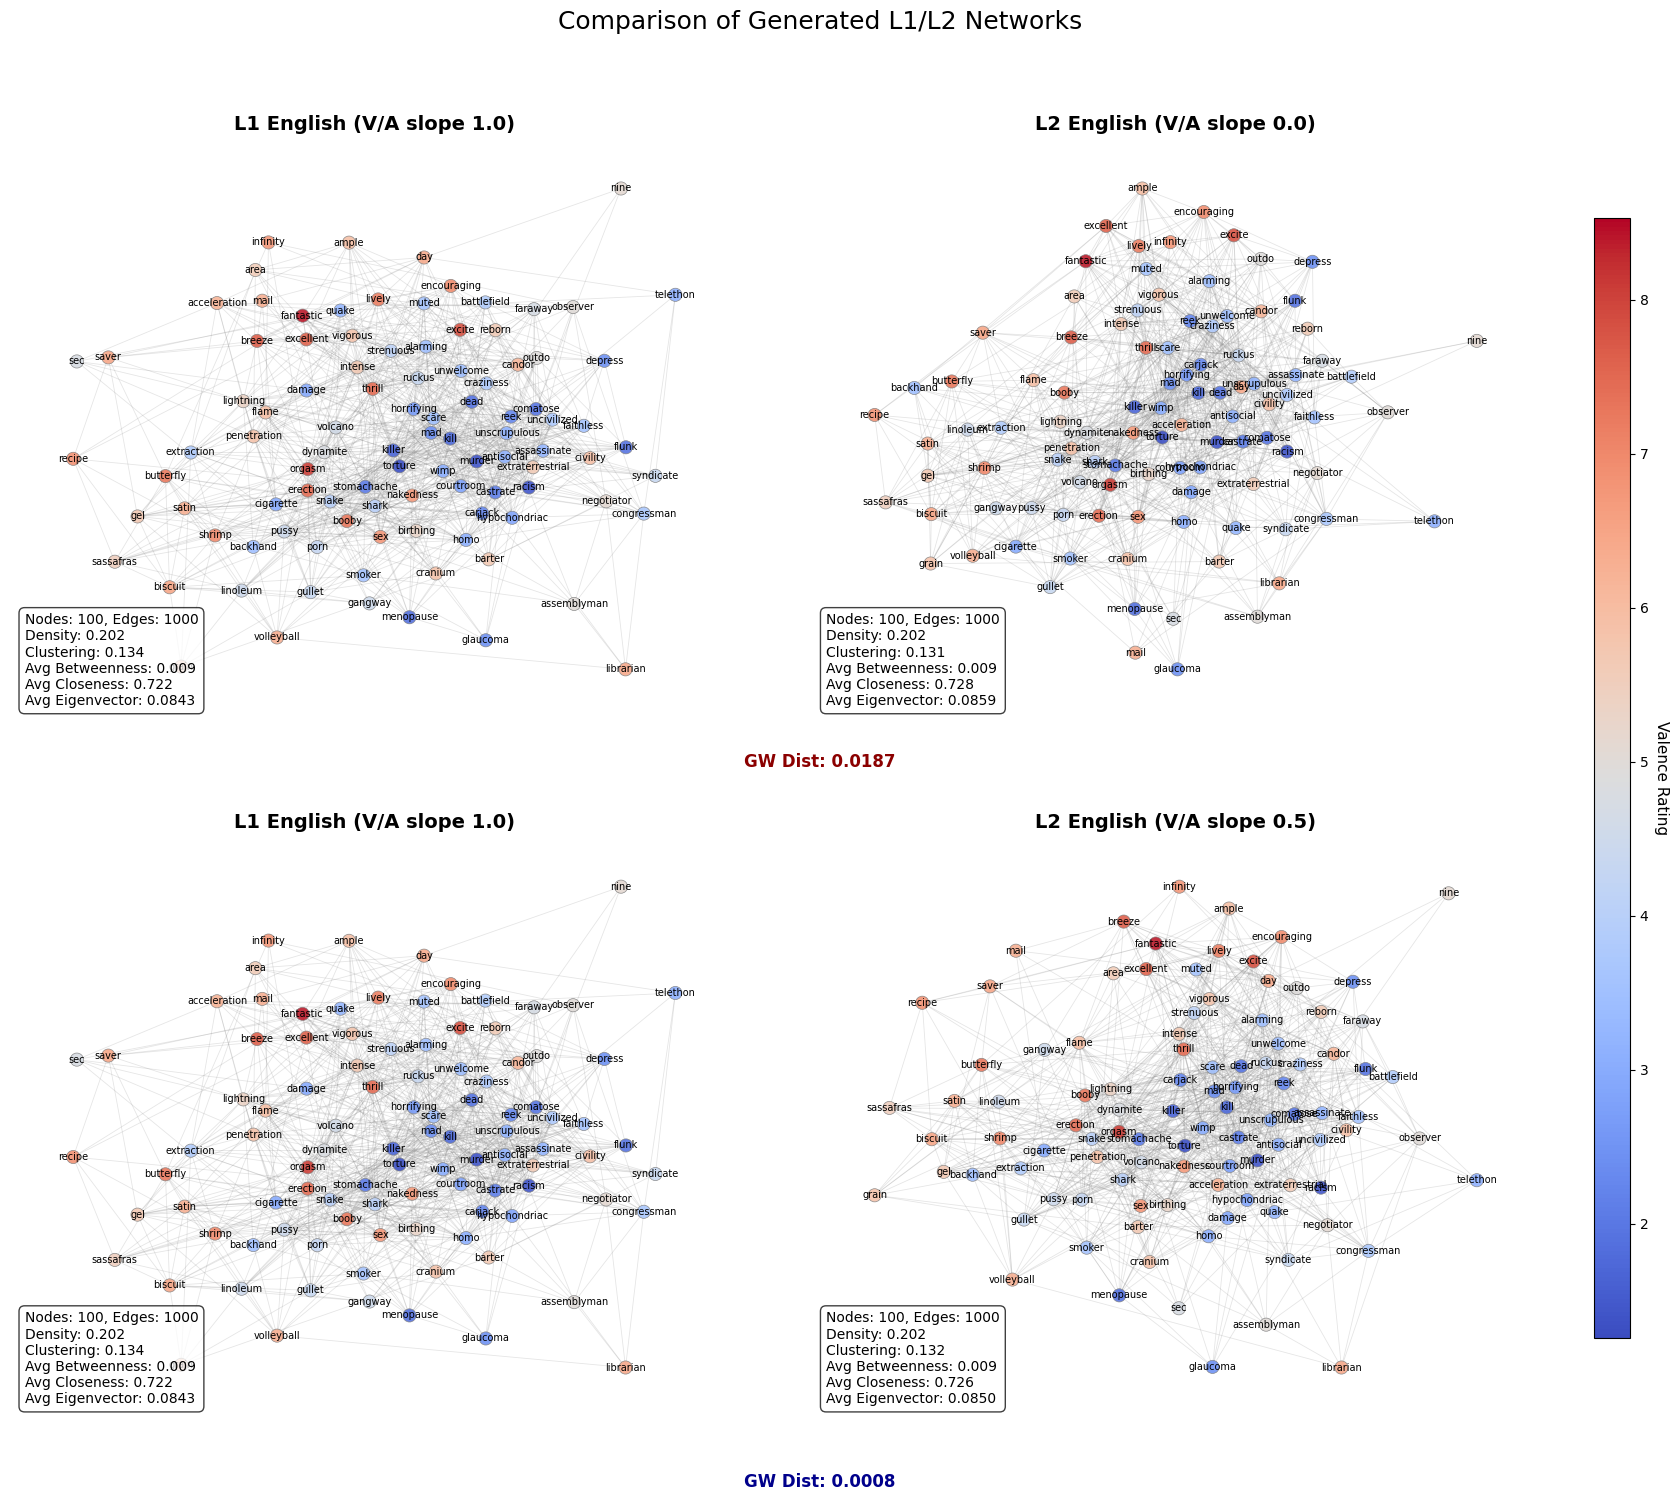


Creating visualization (Arousal coloring): toy_network_linear_boost/Network_Comparison_Arousal.png
Saved visualization to toy_network_linear_boost/Network_Comparison_Arousal.png


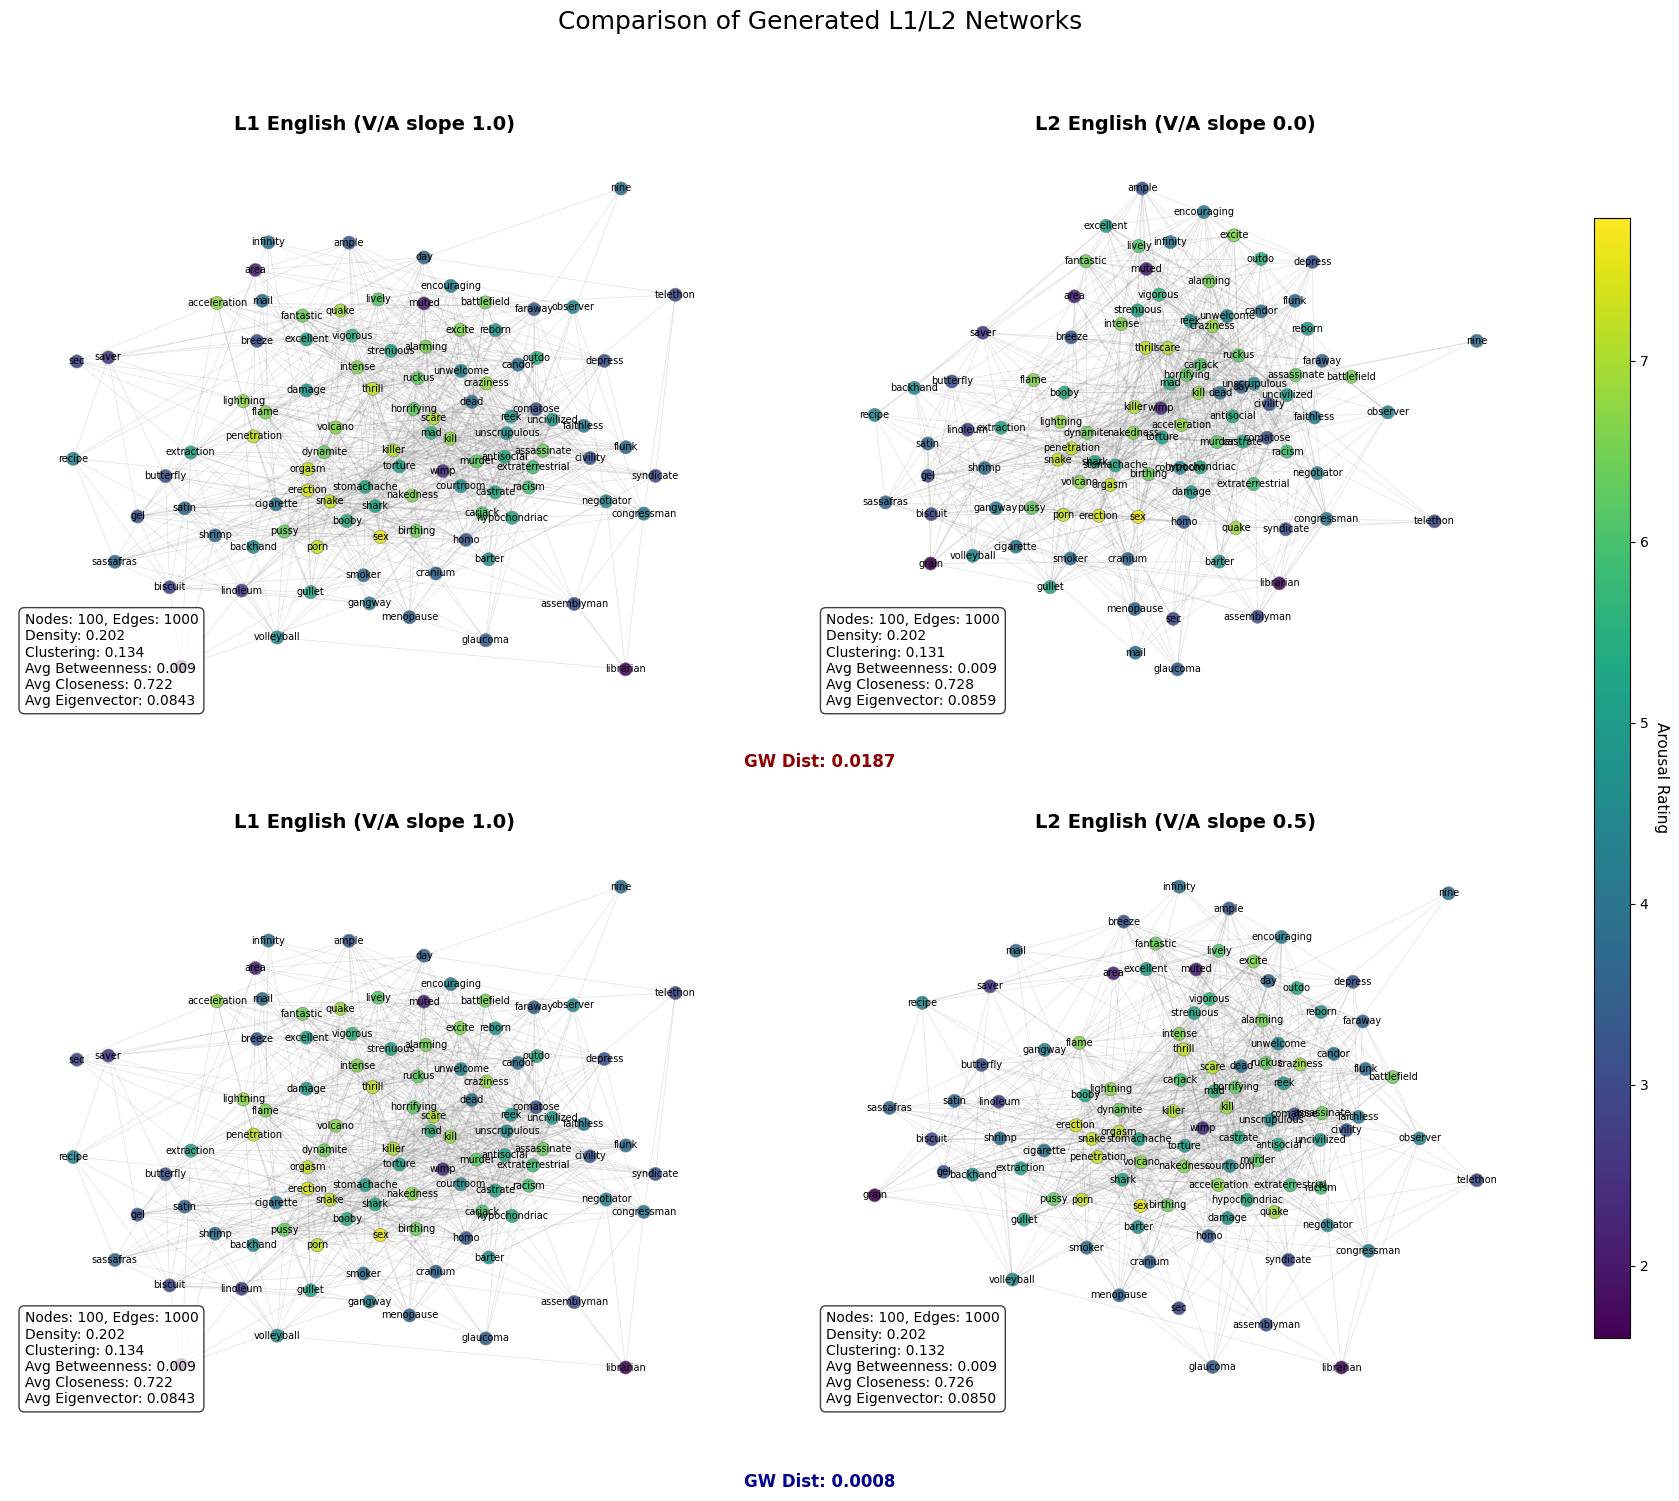


--- Script Finished ---


<IPython.core.display.Javascript object>

In [10]:
# --- Visualization Function ---

def visualize_comparison(graphs_dict, metrics_dict, gw_distances_dict, plot_order,
                         ratings_all_dict, rating_key='Valence', cmap_name='coolwarm',
                         filename="network_comparison.png"):
    """
    Creates a 2x2 grid visualization comparing four networks, colored by the specified rating key.
    Displays Density, Clustering, Avg Betweenness, Avg Closeness, and Avg Eigenvector Centrality metrics.

    Args:
        graphs_dict (dict): Dictionary mapping condition names to NetworkX graphs.
        metrics_dict (dict): Dictionary mapping condition names to their calculated metrics dicts.
        gw_distances_dict (dict): Dictionary mapping (name1, name2) tuples to GW distances.
        plot_order (list): A list of 4 condition names specifying the order for the 2x2 grid (TL, TR, BL, BR).
        ratings_all_dict (dict): The original dictionary mapping words to {'Valence': v, 'Arousal': a}.
        rating_key (str): The key in ratings_all_dict to use for node coloring ('Valence' or 'Arousal').
        cmap_name (str): The name of the matplotlib colormap to use.
        filename (str): Path to save the output image file.
    """
    print(f"\nCreating visualization ({rating_key} coloring): {filename}")

    if len(plot_order) != 4: print("Error: plot_order must contain 4 names."); return
    if not all(name in graphs_dict for name in plot_order): print("Error: Missing graph in graphs_dict."); return
    required_metrics = ['Nodes', 'Edges', 'Density', 'Clustering', 'Avg Betweenness Centrality', 'Avg Closeness Centrality', 'Avg Eigenvector Centrality']
    for name in plot_order:
        metrics_key = 'L1_Eng_Adv' if name == 'L1_Eng_Adv_Comp' else name
        if metrics_key not in metrics_dict: print(f"Error: Metrics for '{metrics_key}' not found."); return
        if not all(metric in metrics_dict[metrics_key] for metric in required_metrics): print(f"Error: Missing metrics for '{metrics_key}'. Found: {metrics_dict[metrics_key].keys()}"); return

    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    axes = axes.flatten()

    # --- Setup Colormap ---
    all_ratings = [r[rating_key] for r in ratings_all_dict.values() if r and pd.notna(r.get(rating_key))]
    vmin, vmax = (min(all_ratings), max(all_ratings)) if all_ratings else (1, 9)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap_name)

    # --- Draw each network ---
    titles_map = {
        'L1_Eng_Adv': "L1 English (V/A slope 1.0)",
        'L2_Eng_Low': "L2 English (V/A slope 0.0)",
        'L2_Eng_Adv': "L2 English (V/A slope 0.5)",
        'L1_Eng_Adv_Comp': "L1 English (V/A slope 1.0)"
    }

    for i, condition_name in enumerate(plot_order):
        ax = axes[i]
        G = graphs_dict[condition_name]
        mets_key = 'L1_Eng_Adv' if condition_name == 'L1_Eng_Adv_Comp' else condition_name
        mets = metrics_dict[mets_key]
        title = titles_map.get(condition_name, condition_name)

        if G.number_of_nodes() > 0:
            k_val = 0.9 / np.sqrt(G.number_of_nodes()) if G.number_of_nodes() > 1 else 0.9
            try: pos = nx.spring_layout(G, seed=42, k=k_val, iterations=75)
            except Exception as e: print(f"Warning: Layout failed for {condition_name} ({e}). Using random."); pos = nx.random_layout(G, seed=42)

            node_colors = []
            default_color_val = (vmin + vmax) / 2
            for node in G.nodes():
                rating_val = ratings_all_dict.get(node, {}).get(rating_key, default_color_val)
                node_colors.append(rating_val if pd.notna(rating_val) else default_color_val)

            nx.draw_networkx_nodes(G, pos, ax=ax, node_size=90, node_color=node_colors, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.9, linewidths=0.5, edgecolors='grey')
            nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.2, width=0.6, edge_color='gray')
            nx.draw_networkx_labels(G, pos, ax=ax, font_size=7, font_weight='normal')

            # --- Add Metrics Text ---
            density_val = mets.get('Density', 'N/A'); clustering_val = mets.get('Clustering', 'N/A')
            betweenness_val = mets.get('Avg Betweenness Centrality', 'N/A'); closeness_val = mets.get('Avg Closeness Centrality', 'N/A'); eigenvector_val = mets.get('Avg Eigenvector Centrality', 'N/A')
            density_str = f"{density_val:.3f}" if isinstance(density_val, (int, float)) else density_val
            clustering_str = f"{clustering_val:.3f}" if isinstance(clustering_val, (int, float)) else clustering_val
            betweenness_str = f"{betweenness_val:.3f}" if isinstance(betweenness_val, (int, float)) else betweenness_val
            closeness_str = f"{closeness_val:.3f}" if isinstance(closeness_val, (int, float)) else closeness_val
            eigenvector_str = f"{eigenvector_val:.4f}" if isinstance(eigenvector_val, (int, float)) else eigenvector_val
            metrics_text = (f"Nodes: {mets.get('Nodes', 'N/A')}, Edges: {mets.get('Edges', 'N/A')}\n"
                            f"Density: {density_str}\nClustering: {clustering_str}\n"
                            f"Avg Betweenness: {betweenness_str}\nAvg Closeness: {closeness_str}\n"
                            f"Avg Eigenvector: {eigenvector_str}")
            ax.text(0.02, 0.02, metrics_text, transform=ax.transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.4', fc='white', alpha=0.75))
        else: ax.text(0.5, 0.5, "Empty Graph", ha='center', va='center', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.axis('off')

    # --- Add Colorbar ---
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(f'{rating_key} Rating', rotation=270, labelpad=15, fontsize=11)
    cbar.ax.tick_params(labelsize=10)

    # --- Add GW Distance Annotations ---
    gw_dist_l1_l2low = gw_distances_dict.get(('L1_Eng_Adv', 'L2_Eng_Low'), np.nan)
    fig.text(0.5, 0.51, f"GW Dist: {gw_dist_l1_l2low:.4f}" if pd.notna(gw_dist_l1_l2low) else "GW Dist: N/A", ha='center', va='center', fontsize=12, weight='bold', color='darkred')
    gw_dist_l1_l2adv = gw_distances_dict.get(('L1_Eng_Adv', 'L2_Eng_Adv'), np.nan)
    fig.text(0.5, 0.06, f"GW Dist: {gw_dist_l1_l2adv:.4f}" if pd.notna(gw_dist_l1_l2adv) else "GW Dist: N/A", ha='center', va='center', fontsize=12, weight='bold', color='darkblue')

    # --- Overall Title and Layout Adjustment ---
    fig.suptitle(f"Comparison of Generated L1/L2 Networks", fontsize=18, y=0.98)
    plt.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to {filename}")
    plt.show()
    plt.close(fig)

# --- Execute Visualization ---

print("\n--- Creating Visualizations (Valence and Arousal) ---")
plot_order = ['L1_Eng_Adv', 'L2_Eng_Low', 'L1_Eng_Adv_Comp', 'L2_Eng_Adv']

if all(key in graphs for key in plot_order) and \
   all(key in network_metrics for key in plot_order) and \
   'ratings_en_dict' in locals() and ratings_en_dict and \
   'gw_distances' in locals():

    if 'BASE_OUTPUT_DIR' not in locals():
         BASE_OUTPUT_DIR = "colab_output"
         os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

    viz_filename_valence = os.path.join(BASE_OUTPUT_DIR, "Network_Comparison_Valence.png")
    visualize_comparison(
        graphs_dict=graphs, metrics_dict=network_metrics, gw_distances_dict=gw_distances,
        plot_order=plot_order, ratings_all_dict=ratings_en_dict,
        rating_key='Valence', cmap_name='coolwarm', filename=viz_filename_valence
    )

    viz_filename_arousal = os.path.join(BASE_OUTPUT_DIR, "Network_Comparison_Arousal.png")
    visualize_comparison(
        graphs_dict=graphs, metrics_dict=network_metrics, gw_distances_dict=gw_distances,
        plot_order=plot_order, ratings_all_dict=ratings_en_dict,
        rating_key='Arousal', cmap_name='viridis', filename=viz_filename_arousal
    )

else:
    print("Skipping visualization due to missing graphs, metrics, ratings, or GW distances data.")
    if 'graphs' not in locals() or not all(key in graphs for key in plot_order): print("  Reason: Missing graphs.")
    if 'network_metrics' not in locals() or not all(key in network_metrics for key in plot_order): print("  Reason: Missing metrics.")
    if 'ratings_en_dict' not in locals() or not ratings_en_dict: print("  Reason: Missing ratings data.")
    if 'gw_distances' not in locals(): print("  Reason: Missing GW distances.")


print("\n--- Script Finished ---")

output.no_vertical_scroll()


# 10. Emotion Boost Visualization


--- Visualizing the Linear Emotional Boost Mathematics ---


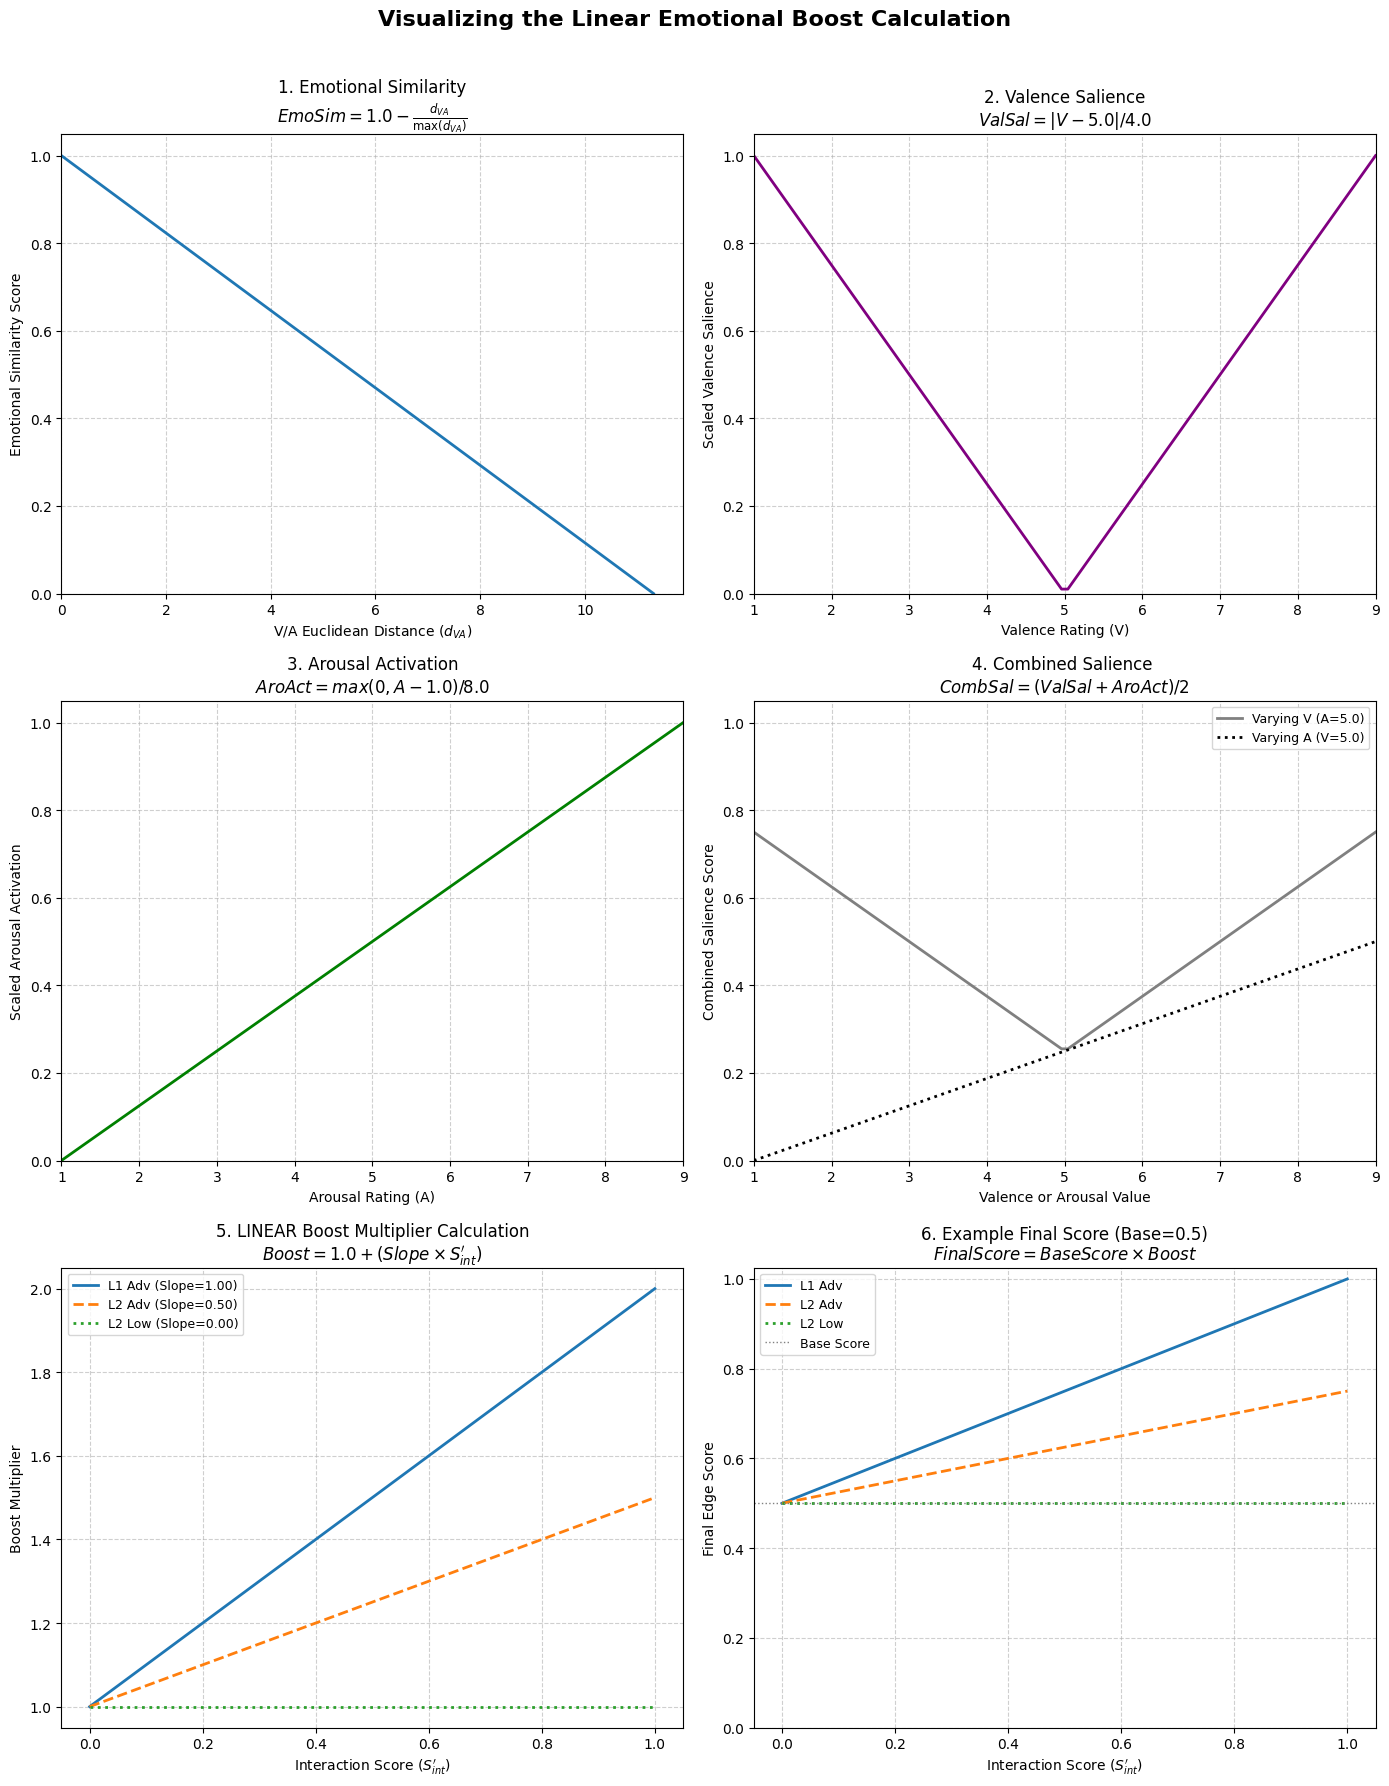

<IPython.core.display.Javascript object>

In [11]:
# --- Visualizing the Math: Emotional Boost Calculation ---

# --- Define Parameters (from PARAMS dict) ---
params_l1 = PARAMS['L1_Eng_Adv']
params_l2a = PARAMS['L2_Eng_Adv']
params_l2l = PARAMS['L2_Eng_Low']

# --- Assumed Scale & Max Distances (for demonstration) ---
VALENCE_MIDPOINT = 5.0
VALENCE_SCALE_MAX_DIST_FROM_MID = 4.0
AROUSAL_MIN = 1.0
AROUSAL_SCALE_RANGE = 8.0
max_va_dist_between_words_demo = np.sqrt(AROUSAL_SCALE_RANGE**2 + (2*VALENCE_SCALE_MAX_DIST_FROM_MID)**2)

print("\n--- Visualizing the Linear Emotional Boost Mathematics ---")

# --- Create Figure ---
plt.figure(figsize=(14, 18))

# --- 1. Emotional Similarity vs. V/A Distance ---
plt.subplot(3, 2, 1)
distances = np.linspace(0, max_va_dist_between_words_demo, 100)
scaled_distances = distances / max_va_dist_between_words_demo
emo_similarities = 1.0 - scaled_distances
plt.plot(distances, emo_similarities, lw=2)
plt.xlabel("V/A Euclidean Distance ($d_{VA}$)")
plt.ylabel("Emotional Similarity Score")
plt.title("1. Emotional Similarity\n$EmoSim = 1.0 - \\frac{d_{VA}}{\\max(d_{VA})}$")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05); plt.xlim(left=0)

# --- 2. Valence Salience ---
plt.subplot(3, 2, 2)
valence_values = np.linspace(1, 9, 100)
scaled_val_salience = abs(valence_values - VALENCE_MIDPOINT) / VALENCE_SCALE_MAX_DIST_FROM_MID
plt.plot(valence_values, scaled_val_salience, lw=2, color='purple')
plt.xlabel("Valence Rating (V)")
plt.ylabel("Scaled Valence Salience")
plt.title(f"2. Valence Salience\n$ValSal = |V - {VALENCE_MIDPOINT}| / {VALENCE_SCALE_MAX_DIST_FROM_MID}$")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05); plt.xlim(1, 9)

# --- 3. Arousal Activation ---
plt.subplot(3, 2, 3)
arousal_values = np.linspace(1, 9, 100)
scaled_aro_activation = np.maximum(0.0, arousal_values - AROUSAL_MIN) / AROUSAL_SCALE_RANGE
plt.plot(arousal_values, scaled_aro_activation, lw=2, color='green')
plt.xlabel("Arousal Rating (A)")
plt.ylabel("Scaled Arousal Activation")
plt.title(f"3. Arousal Activation\n$AroAct = max(0, A - {AROUSAL_MIN}) / {AROUSAL_SCALE_RANGE}$")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05); plt.xlim(1, 9)

# --- 4. Combined Salience ---
plt.subplot(3, 2, 4)
valence_values_cs = np.linspace(1, 9, 100)
fixed_arousal_cs = 5.0
s_val_sal = abs(valence_values_cs - VALENCE_MIDPOINT) / VALENCE_SCALE_MAX_DIST_FROM_MID
s_aro_act = max(0.0, fixed_arousal_cs - AROUSAL_MIN) / AROUSAL_SCALE_RANGE
combined_sal_v = (s_val_sal + s_aro_act) / 2.0
arousal_values_cs = np.linspace(1, 9, 100)
fixed_valence_cs = 5.0
s_val_sal = abs(fixed_valence_cs - VALENCE_MIDPOINT) / VALENCE_SCALE_MAX_DIST_FROM_MID
s_aro_act = np.maximum(0.0, arousal_values_cs - AROUSAL_MIN) / AROUSAL_SCALE_RANGE
combined_sal_a = (s_val_sal + s_aro_act) / 2.0
plt.plot(valence_values_cs, combined_sal_v, lw=2, label=f'Varying V (A={fixed_arousal_cs})', color='grey')
plt.plot(arousal_values_cs, combined_sal_a, lw=2, label=f'Varying A (V={fixed_valence_cs})', color='black', linestyle=':')
plt.xlabel("Valence or Arousal Value")
plt.ylabel("Combined Salience Score")
plt.title("4. Combined Salience \n$CombSal = (ValSal + AroAct) / 2$")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=9)
plt.ylim(0, 1.05); plt.xlim(1, 9)


# --- 5. Visualize Linear Boost Multiplier vs. Interaction Score ---
plt.subplot(3, 2, 5)
interaction_scores_new = np.linspace(0, 1, 100)
boost_l1 = 1.0 + (params_l1['emotion_slope'] * interaction_scores_new)
boost_l2a = 1.0 + (params_l2a['emotion_slope'] * interaction_scores_new)
boost_l2l = 1.0 + (params_l2l['emotion_slope'] * interaction_scores_new)
plt.plot(interaction_scores_new, boost_l1, lw=2, label=f"L1 Adv (Slope={params_l1['emotion_slope']:.2f})")
plt.plot(interaction_scores_new, boost_l2a, lw=2, label=f"L2 Adv (Slope={params_l2a['emotion_slope']:.2f})", linestyle='--')
plt.plot(interaction_scores_new, boost_l2l, lw=2, label=f"L2 Low (Slope={params_l2l['emotion_slope']:.2f})", linestyle=':')
plt.xlabel("Interaction Score ($S_{int}'$)") # S_int' = EmoSim * max(CombSal)
plt.ylabel("Boost Multiplier")
plt.title("5. LINEAR Boost Multiplier Calculation\n$Boost = 1.0 + (Slope \\times S_{int}')$")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=9)
plt.ylim(bottom=0.95)

# --- 6. Visualize Final Score vs Interaction Score (assuming BaseScore = 0.5) ---
plt.subplot(3, 2, 6)
base_score_demo = 0.5
final_score_l1 = base_score_demo * boost_l1
final_score_l2a = base_score_demo * boost_l2a
final_score_l2l = base_score_demo * boost_l2l
plt.plot(interaction_scores_new, final_score_l1, lw=2, label=f"L1 Adv")
plt.plot(interaction_scores_new, final_score_l2a, lw=2, label=f"L2 Adv", linestyle='--')
plt.plot(interaction_scores_new, final_score_l2l, lw=2, label=f"L2 Low", linestyle=':')
plt.axhline(base_score_demo, color='grey', linestyle=':', lw=1, label='Base Score')
plt.xlabel("Interaction Score ($S_{int}'$)")
plt.ylabel(f"Final Edge Score")
plt.title(f"6. Example Final Score (Base={base_score_demo})\n$FinalScore = BaseScore \\times Boost$")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=9)
plt.ylim(bottom=0)

# --- Adjust Layout and Title ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Visualizing the Linear Emotional Boost Calculation", y=0.99, fontsize=16, fontweight='bold')
plt.show()

output.no_vertical_scroll()

# 11. Combined Emotional Salience vs. Node Degree Visualization


--- Visualizing Combined Emotional Salience vs. Node Degree ---
Calculating node degrees for each condition...


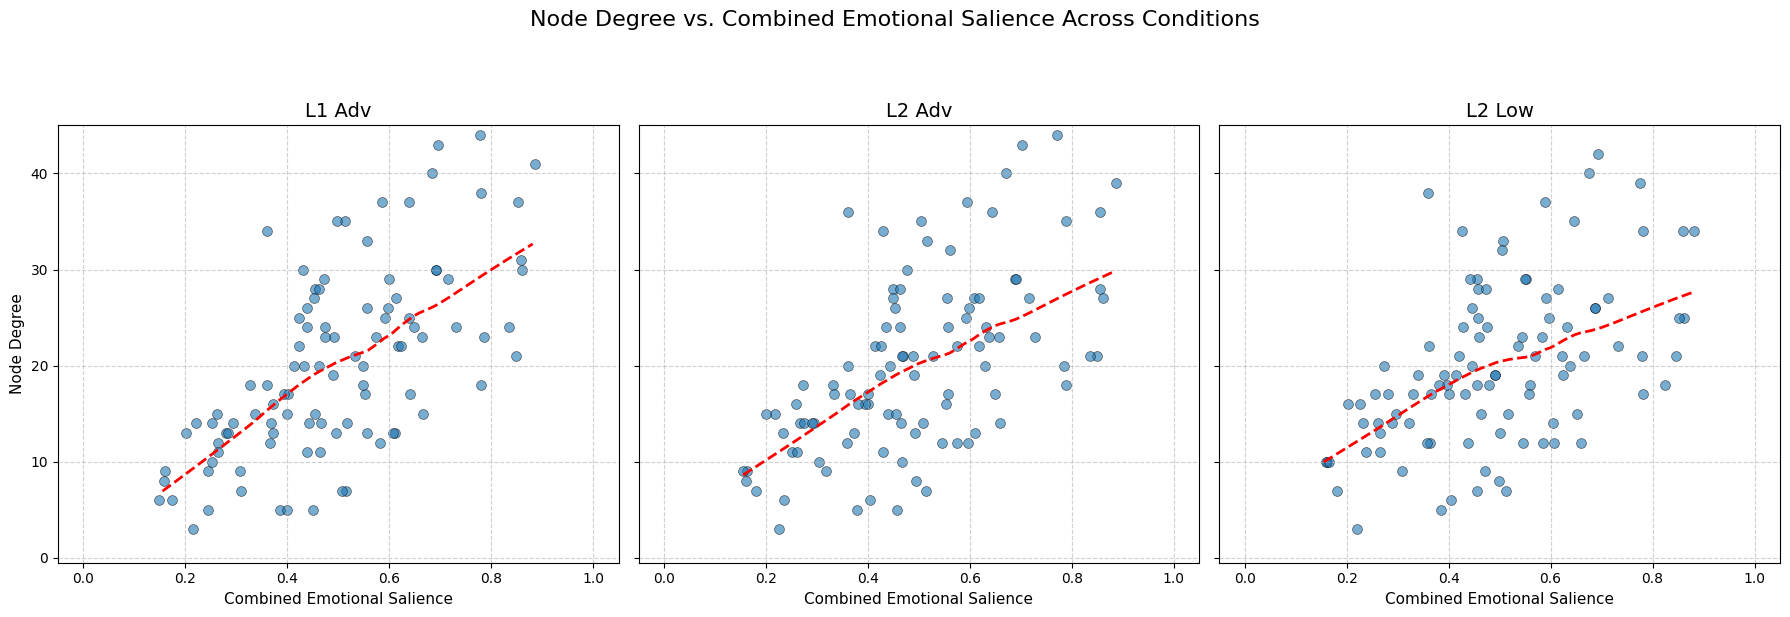

In [12]:
# --- Visualizing Combined Emotional Salience vs. Node Degree Across Conditions ---

# Define scale_value if not defined in this scope
def scale_value(value, min_val, max_val):
    """Scales a value to be between 0 and 1."""
    if max_val == min_val: return 0.5
    scaled = (value - min_val) / (max_val - min_val)
    return max(0.0, min(1.0, scaled))

def visualize_salience_vs_degree(graphs_dict, ratings_all_dict, selected_words_list):
    """
    Creates scatter plots showing the relationship between a word's combined
    emotional salience (Valence Salience + Arousal Activation) and its
    degree within the network for each condition.

    Args:
        graphs_dict (dict): Dictionary mapping condition names to NetworkX graphs.
        ratings_all_dict (dict): Dictionary mapping words to {'Valence': v, 'Arousal': a}.
        selected_words_list (list): The list of words included in the networks.
    """
    print("\n--- Visualizing Combined Emotional Salience vs. Node Degree ---")

    conditions = ['L1_Eng_Adv', 'L2_Eng_Adv', 'L2_Eng_Low']
    condition_labels = ['L1 Adv', 'L2 Adv', 'L2 Low']

    # Check if graphs exist
    if not all(cond in graphs_dict for cond in conditions): print("Error: Missing graph conditions."); return
    if not selected_words_list: print("Error: selected_words_list is empty."); return

    # --- Calculate Combined Salience for all selected words ---
    salience_data = {}
    VALENCE_MIDPOINT = 5.0
    AROUSAL_MIN = 1.0
    all_vals = [r['Valence'] for r in ratings_all_dict.values() if pd.notna(r.get('Valence'))]
    all_aros = [r['Arousal'] for r in ratings_all_dict.values() if pd.notna(r.get('Arousal'))]
    max_val_dist_from_mid = max(abs(min(all_vals) - VALENCE_MIDPOINT), abs(max(all_vals) - VALENCE_MIDPOINT)) if all_vals else 4.0
    max_aro_dist_from_min = (max(all_aros) - AROUSAL_MIN) if all_aros else 8.0
    # Ensure denominators > 0
    if max_val_dist_from_mid < 1e-9: max_val_dist_from_mid = 4.0
    if max_aro_dist_from_min < 1e-9: max_aro_dist_from_min = 8.0

    for word in selected_words_list:
        if word in ratings_all_dict and \
           pd.notna(ratings_all_dict[word].get('Valence')) and \
           pd.notna(ratings_all_dict[word].get('Arousal')):
            v_i = ratings_all_dict[word]['Valence']
            a_i = ratings_all_dict[word]['Arousal']
            scaled_val_salience = abs(v_i - VALENCE_MIDPOINT) / max_val_dist_from_mid
            scaled_aro_activation = max(0.0, a_i - AROUSAL_MIN) / max_aro_dist_from_min
            salience_data[word] = (scaled_val_salience + scaled_aro_activation) / 2.0
        else:
            salience_data[word] = np.nan

    # --- Calculate Node Degrees and Prepare Plot Data ---
    plot_data_all = []
    max_degree = 0
    print("Calculating node degrees for each condition...")
    for condition in conditions:
        G = graphs_dict[condition]
        if G.number_of_nodes() == 0: continue
        degrees = dict(G.degree())
        max_degree = max(max_degree, max(degrees.values()) if degrees else 0)
        for word in selected_words_list:
            plot_data_all.append({
                'Condition': condition,
                'Word': word,
                'CombinedSalience': salience_data.get(word, np.nan), # Use new combined salience
                'Degree': degrees.get(word, 0)
            })

    plot_df = pd.DataFrame(plot_data_all).dropna(subset=['CombinedSalience']) # Drop words missing salience data
    if plot_df.empty: print("Error: No valid data points found for plotting."); return

    # --- Create 1x3 Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle("Node Degree vs. Combined Emotional Salience Across Conditions", fontsize=16, y=1.02)

    for i, (condition, condition_label) in enumerate(zip(conditions, condition_labels)):
        ax = axes[i]
        condition_data = plot_df[plot_df['Condition'] == condition]

        # Jitter CombinedSalience for visualization
        salience_range = plot_df['CombinedSalience'].max() - plot_df['CombinedSalience'].min()
        jitter_amount = 0.01 * salience_range if salience_range > 0 else 0.01
        salience_jitter = condition_data['CombinedSalience'] + np.random.uniform(-jitter_amount, jitter_amount, size=len(condition_data))

        sc = ax.scatter(salience_jitter, condition_data['Degree'],
                        alpha=0.6, s=50, edgecolors='k', linewidths=0.5)

        # Add a trend line
        try:
            import statsmodels.api as sm
            lowess = sm.nonparametric.lowess
            # Use CombinedSalience for the trend calculation
            trend = lowess(condition_data['Degree'], condition_data['CombinedSalience'], frac=0.6)
            ax.plot(trend[:, 0], trend[:, 1], color='red', linestyle='--', lw=2, label='Trend (LOWESS)')
        except ImportError: print("Note: Install statsmodels (`pip install statsmodels`) to see trend lines.")
        except Exception as e: print(f"Could not plot trend line for {condition}: {e}")

        ax.set_title(condition_label, fontsize=14)
        ax.set_xlabel("Combined Emotional Salience", fontsize=11)
        if i == 0: ax.set_ylabel("Node Degree", fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.5, max_degree + 1)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Execute Salience vs. Degree Visualization ---
if 'graphs' in locals() and 'ratings_en_dict' in locals() and 'selected_words_en' in locals():
     visualize_salience_vs_degree(
         graphs_dict=graphs,
         ratings_all_dict=ratings_en_dict,
         selected_words_list=selected_words_en
     )
else:
     print("\nSkipping salience vs. degree visualization due to missing graphs, ratings, or selected words list.")



# 12. Node Metrics Visualization


--- Visualizing Node Metrics in V/A Space ---
Calculating node metrics across conditions...


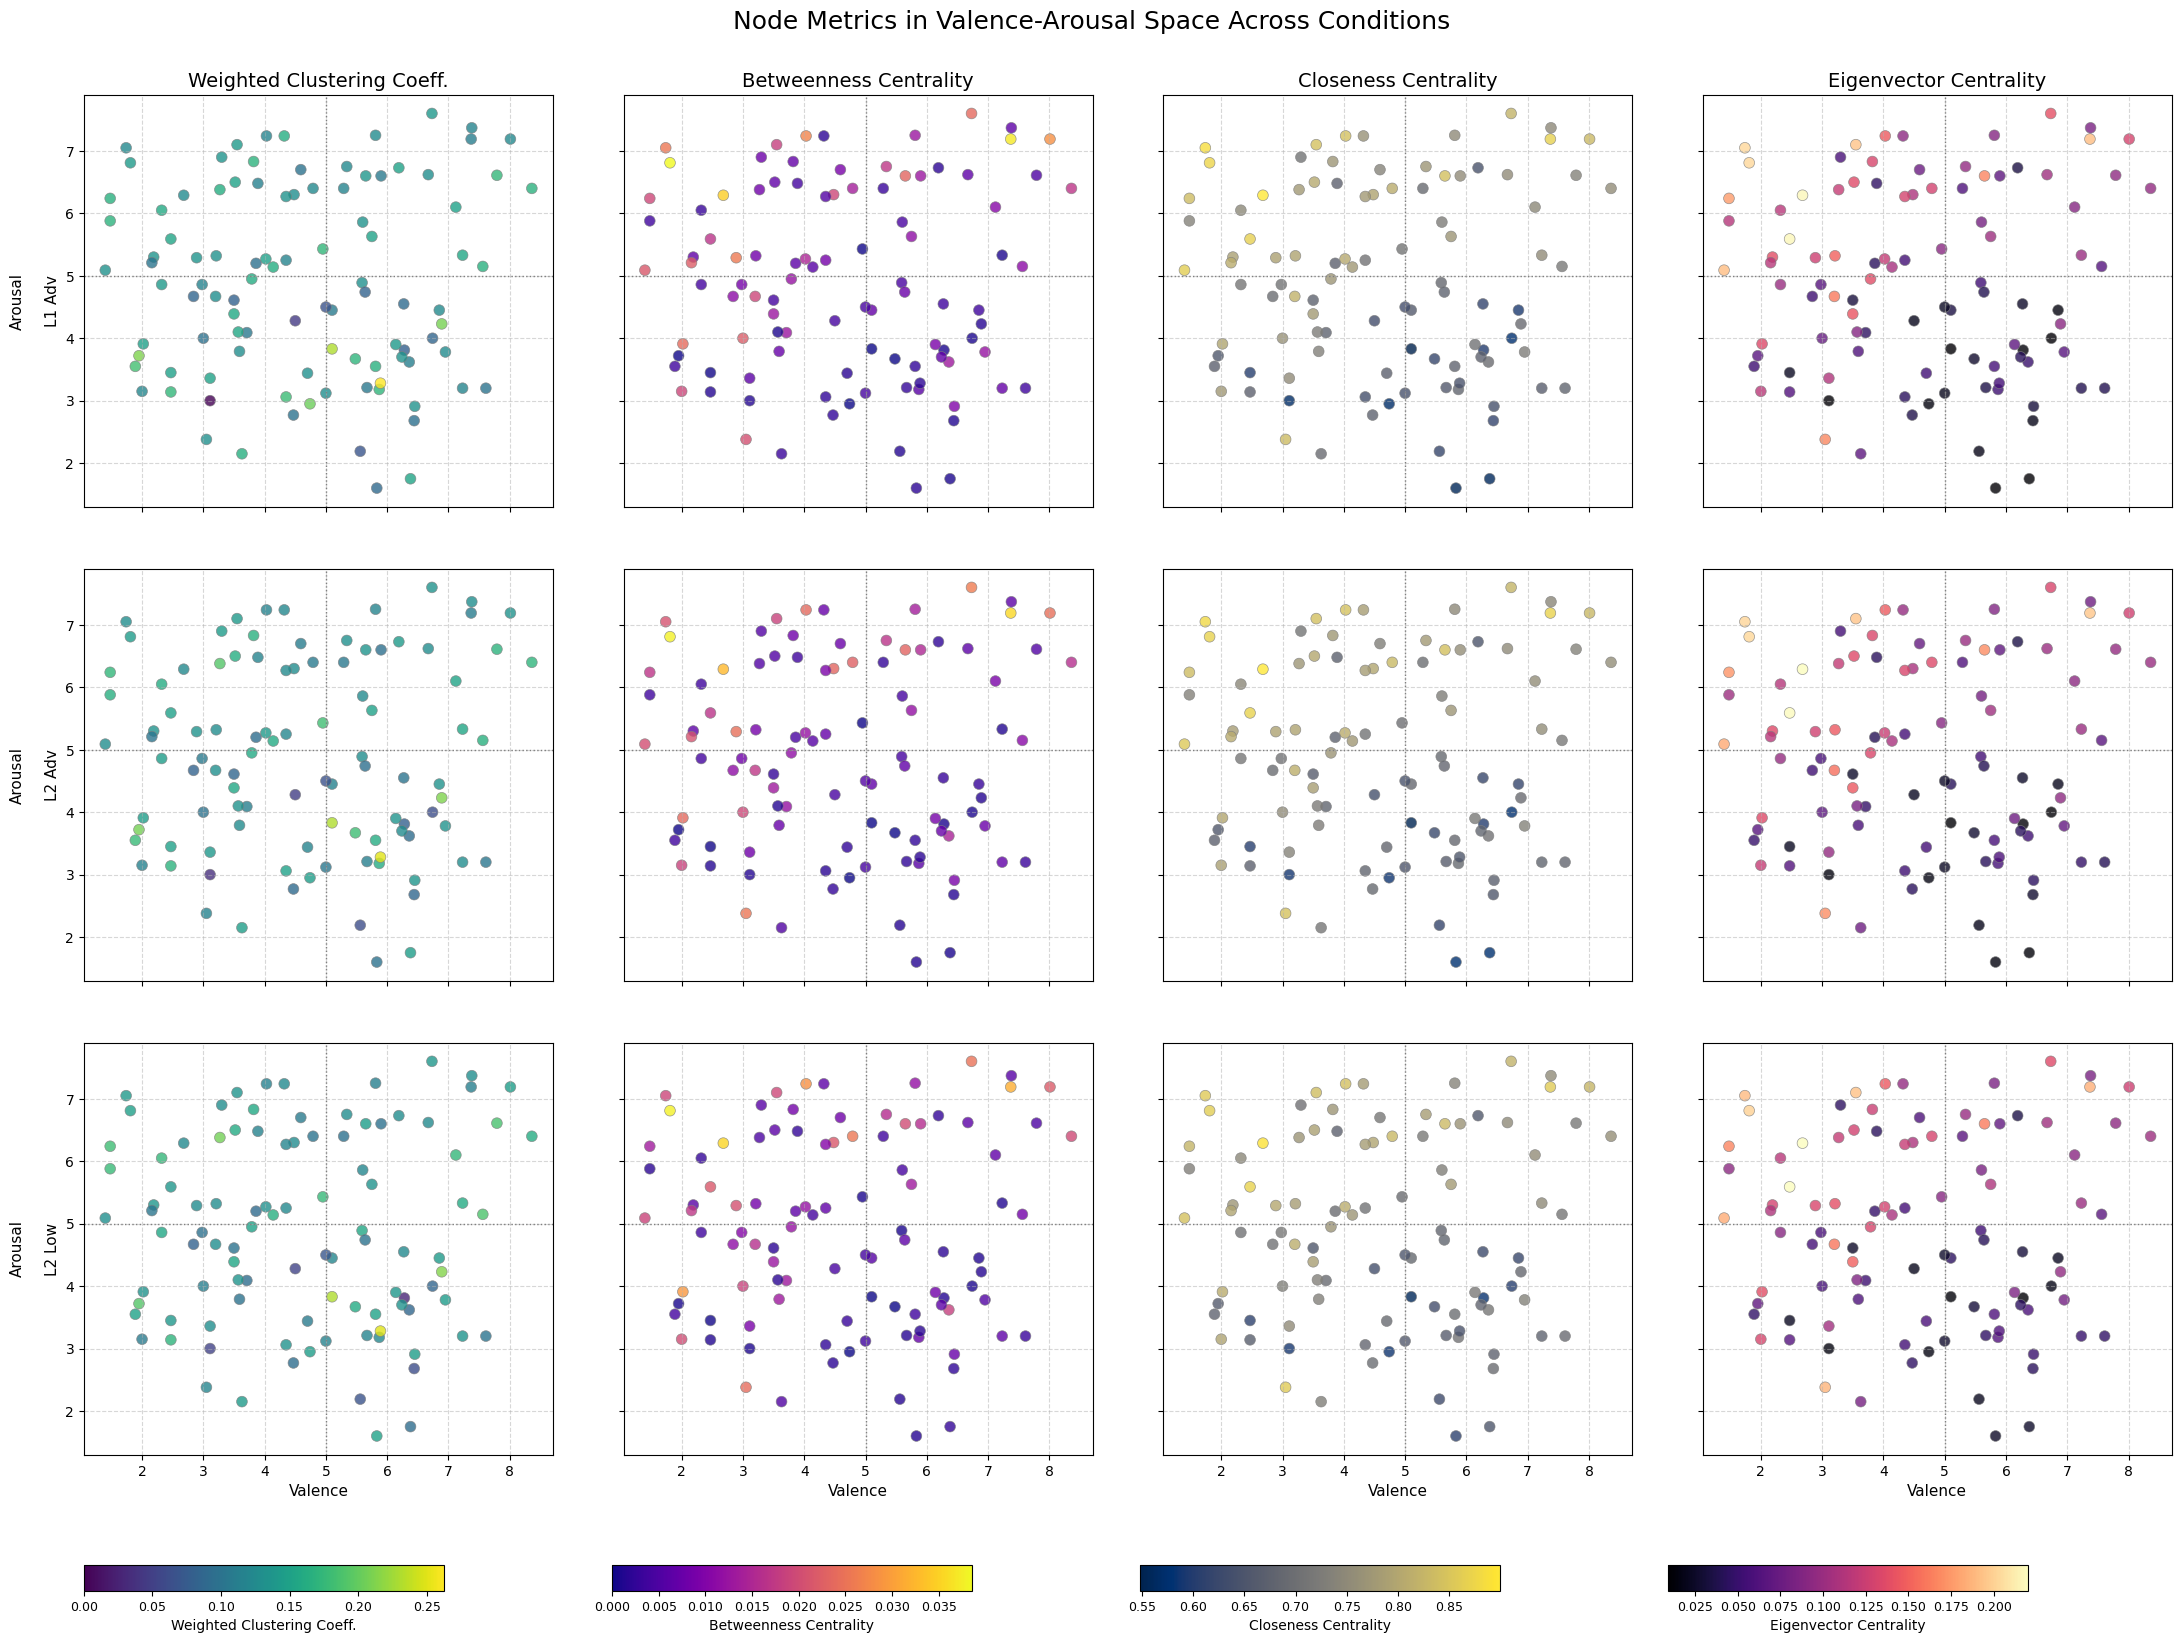

In [13]:
# --- Visualizing Node Metrics in V/A Space ---

def visualize_node_metrics(graphs_dict, ratings_all_dict, selected_words_list):
    """
    Creates a 4x3 grid visualizing node metrics (Clustering, Betweenness, Closeness, Eigenvector)
    in the Valence-Arousal space for different network conditions.
    Rows = Conditions (L1, L2A, L2L)
    Columns = Metrics

    Args:
        graphs_dict (dict): Dictionary mapping condition names to NetworkX graphs.
        ratings_all_dict (dict): Dictionary mapping words to {'Valence': v, 'Arousal': a}.
        selected_words_list (list): The list of words included in the networks.
    """
    print("\n--- Visualizing Node Metrics in V/A Space ---")

    # Define order for rows (conditions) and columns (metrics)
    conditions = ['L1_Eng_Adv', 'L2_Eng_Adv', 'L2_Eng_Low']
    condition_labels = ['L1 Adv', 'L2 Adv', 'L2 Low']
    metrics_to_plot = [
        ('Clustering', nx.clustering, 'Weighted Clustering Coeff.', 'viridis'),
        ('Betweenness', nx.betweenness_centrality, 'Betweenness Centrality', 'plasma'),
        ('Closeness', nx.closeness_centrality, 'Closeness Centrality', 'cividis'),
        ('Eigenvector', nx.eigenvector_centrality, 'Eigenvector Centrality', 'magma')
    ]
    num_metrics = len(metrics_to_plot)

    # Check if graphs exist
    if not all(cond in graphs_dict for cond in conditions): print("Error: Missing graph conditions."); return
    if not selected_words_list: print("Error: selected_words_list is empty."); return

    # Prepare V/A coordinates
    va_data = [{'Word': word, 'Valence': ratings_all_dict.get(word, {}).get('Valence', np.nan), 'Arousal': ratings_all_dict.get(word, {}).get('Arousal', np.nan)} for word in selected_words_list]
    va_df = pd.DataFrame(va_data).dropna()
    if va_df.empty: print("Error: No valid V/A coordinates found."); return

    # --- Calculate all metrics first ---
    all_metrics_data = {metric_key: {} for metric_key, _, _, _ in metrics_to_plot}
    global_min_max = {metric_key: {'min': np.inf, 'max': -np.inf} for metric_key, _, _, _ in metrics_to_plot}

    print("Calculating node metrics across conditions...")
    for condition in conditions:
        G = graphs_dict[condition]
        if G.number_of_nodes() == 0: continue

        largest_cc_subgraph = None
        nodes_in_lcc = set()
        distance_attr_added = False

        if nx.is_connected(G):
            largest_cc_subgraph = G.copy()
            nodes_in_lcc = set(G.nodes())
        else:
            components = list(nx.connected_components(G))
            if components:
                largest_cc_nodes = max(components, key=len)
                if len(largest_cc_nodes) > 1:
                    largest_cc_subgraph = G.subgraph(largest_cc_nodes).copy()
                    nodes_in_lcc = largest_cc_nodes

        # Add distance attribute if we have a valid subgraph for centrality
        if largest_cc_subgraph is not None:
            try:
                max_similarity = 1.0
                for u, v, data in largest_cc_subgraph.edges(data=True):
                    similarity = data.get('weight', 0.0)
                    distance = max_similarity - similarity if isinstance(similarity, (int, float)) and 0.0 <= similarity <= max_similarity else max_similarity
                    if distance <= 0: distance = 1e-9
                    largest_cc_subgraph[u][v]['distance'] = distance
                distance_attr_added = True
            except Exception as e:
                print(f"    - Warning: Could not create distance attribute for {condition}: {e}")

        # Calculate metrics
        for metric_key, metric_func, _, _ in metrics_to_plot:
            node_metrics = {}
            try:
                if metric_key == 'Clustering':
                    node_metrics = metric_func(G, weight='weight')
                elif largest_cc_subgraph is not None:
                     if metric_key == 'Betweenness' and distance_attr_added:
                          node_metrics = metric_func(largest_cc_subgraph, weight='distance', normalized=True)
                     elif metric_key == 'Closeness' and distance_attr_added:
                          # Use inverted 'distance' weight
                          node_metrics = metric_func(largest_cc_subgraph, distance='distance')
                     elif metric_key == 'Eigenvector':
                          # Use original 'weight'
                          try: node_metrics = metric_func(largest_cc_subgraph, weight='weight', max_iter=1000, tol=1e-06)
                          except nx.PowerIterationFailedConvergence: node_metrics = {node: np.nan for node in largest_cc_subgraph.nodes()}
                     else: # Handle case where distance attr failed or metric not applicable
                          node_metrics = {node: np.nan for node in largest_cc_subgraph.nodes()}
                # Store metrics, assigning NaN to nodes outside the largest component for centrality
                all_metrics_data[metric_key][condition] = {
                    node: node_metrics.get(node, np.nan) if node in nodes_in_lcc or metric_key == 'Clustering' else np.nan
                    for node in G.nodes()
                }
                # Update global min/max
                valid_values = [v for v in all_metrics_data[metric_key][condition].values() if pd.notna(v)]
                if valid_values:
                     global_min_max[metric_key]['min'] = min(global_min_max[metric_key]['min'], np.min(valid_values))
                     global_min_max[metric_key]['max'] = max(global_min_max[metric_key]['max'], np.max(valid_values))
            except Exception as e:
                print(f"Error calculating {metric_key} for {condition}: {e}")
                all_metrics_data[metric_key][condition] = {node: np.nan for node in G.nodes()}

    # --- Create 4x3 Plot (Rows=Conditions, Cols=Metrics) ---
    fig, axes = plt.subplots(3, num_metrics, figsize=(24, 17), sharex=True, sharey=True)
    fig.suptitle("Node Metrics in Valence-Arousal Space Across Conditions", fontsize=18, y=0.97)

    colorbar_info = []

    # Loop through rows (conditions)
    for row, (condition, condition_label) in enumerate(zip(conditions, condition_labels)):
        # Loop through columns (metrics)
        for col, (metric_key, _, metric_label, cmap_name) in enumerate(metrics_to_plot):
            ax = axes[row, col]
            condition_metrics = all_metrics_data[metric_key].get(condition, {})
            vmin = global_min_max[metric_key]['min'] if global_min_max[metric_key]['min'] != np.inf else 0
            vmax = global_min_max[metric_key]['max'] if global_min_max[metric_key]['max'] != -np.inf else 1
            if abs(vmin - vmax) < 1e-9: vmin -= 0.1; vmax += 0.1
            if vmin == vmax: vmax = vmin + 1.0

            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            cmap = plt.get_cmap(cmap_name)

            plot_data = va_df.copy()
            plot_data['metric'] = plot_data['Word'].map(condition_metrics)
            plot_data['metric'] = plot_data['metric'].fillna(np.nan)
            plot_data_valid = plot_data.dropna(subset=['metric'])
            plot_data_nan = plot_data[plot_data['metric'].isna()]

            sc = ax.scatter(plot_data_valid['Valence'], plot_data_valid['Arousal'], c=plot_data_valid['metric'], cmap=cmap, norm=norm, s=60, alpha=0.8, edgecolors='grey', linewidths=0.5)
            if not plot_data_nan.empty: ax.scatter(plot_data_nan['Valence'], plot_data_nan['Arousal'], c='lightgrey', marker='x', s=40, alpha=0.7, label='N/A')

            ax.grid(True, linestyle='--', alpha=0.5)
            ax.axhline(5, color='grey', linestyle=':', lw=1)
            ax.axvline(5, color='grey', linestyle=':', lw=1)

            if row == 0: ax.set_title(metric_label, fontsize=14)
            ylabel_text = f"Arousal\n\n{condition_label}" if col == 0 else ""
            ax.set_ylabel(ylabel_text, fontsize=11)
            if row == 2: ax.set_xlabel("Valence", fontsize=11)

            if row == 0: colorbar_info.append({'col': col, 'cmap': cmap, 'norm': norm, 'label': metric_label})

    # --- Add Colorbars AFTER plotting all axes ---
    for cbar_data in colorbar_info:
        col_index = cbar_data['col']
        sm = plt.cm.ScalarMappable(cmap=cbar_data['cmap'], norm=cbar_data['norm'])
        sm.set_array([])
        # Adjust positioning for 4 columns
        cbar_ax = fig.add_axes([0.08 + col_index*0.22, 0.04, 0.15, 0.015]) # [left, bottom, width, height]
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cbar.ax.tick_params(labelsize=9)
        cbar.set_label(cbar_data['label'], fontsize=10)

    plt.subplots_adjust(left=0.08, right=0.95, bottom=0.12, top=0.92, wspace=0.15, hspace=0.15) # Adjust spacing
    plt.show()

# =============================================================================
# Execute Node Metric Visualization
# =============================================================================
if 'graphs' in locals() and 'ratings_en_dict' in locals() and 'selected_words_en' in locals():
     visualize_node_metrics(
         graphs_dict=graphs,
         ratings_all_dict=ratings_en_dict,
         selected_words_list=selected_words_en
     )
else:
     print("\nSkipping node metric visualization due to missing graphs, ratings, or selected words list.")



# 13. Word Association Simulation

In [ ]:
# --- Cell 13: Interactive Word Association Simulation ---

# --- Check if necessary variables from previous cells exist ---
if 'graphs' not in locals() or not graphs:
    print("ERROR: 'graphs' dictionary not found or empty. Please run Cell 6 first.")
elif 'ratings_en_dict' not in locals() or not ratings_en_dict:
    print("ERROR: 'ratings_en_dict' not found or empty. Please run Cell 4 first.")
elif 'selected_words_en' not in locals() or not selected_words_en:
     print("ERROR: 'selected_words_en' list not found or empty. Please run Cell 5 first.")
else:
    print("Prerequisites found. Setting up interactive simulation...")

    # --- Get available conditions and words ---
    available_conditions = [cond for cond in ['L1_Eng_Adv', 'L2_Eng_Adv', 'L2_Eng_Low'] if cond in graphs]
    available_words = sorted([word for word in selected_words_en if word in ratings_en_dict])

    if not available_conditions:
        print("ERROR: No valid network conditions found in 'graphs' dictionary.")
    elif not available_words:
        print("ERROR: No valid words found with ratings for selection.")
    else:
        # --- Create Widgets ---
        network_dropdown = widgets.Dropdown(options=available_conditions, description='Network:', disabled=False)
        cue_word_dropdown = widgets.Dropdown(options=available_words, description='Cue Word:', disabled=False)
        run_button = widgets.Button(description='Run Simulation', button_style='success', tooltip='Find associates and analyze emotions', icon='play')
        output_area = widgets.Output()

        # --- Simulation Function ---
        def simulate_association(b):
            with output_area:
                clear_output(wait=True)
                condition = network_dropdown.value
                cue_word = cue_word_dropdown.value
                G = graphs.get(condition)

                if G is None: print(f"Error: Graph not found for '{condition}'."); return
                if cue_word not in G: print(f"Error: Cue '{cue_word}' not in graph '{condition}'."); return
                if cue_word not in ratings_en_dict: print(f"Error: Ratings not found for '{cue_word}'."); return

                print(f"--- Simulation Results ---")
                print(f"Network Condition: {condition}")
                print(f"Cue Word: '{cue_word}'")

                cue_ratings = ratings_en_dict[cue_word]
                cue_v = cue_ratings.get('Valence', np.nan)
                cue_a = cue_ratings.get('Arousal', np.nan)
                print(f"Cue Emotion: Valence={cue_v:.2f}, Arousal={cue_a:.2f}")

                associates = list(G.neighbors(cue_word))
                print(f"\nFound {len(associates)} associate(s): {', '.join(associates) if associates else 'None'}")
                if not associates: print("\nNo associates found."); return

                associate_data = []; valid_associates = 0
                sum_v = 0; sum_a = 0
                assoc_v_list = []; assoc_a_list = []
                print("\nAssociate Emotions:")
                for assoc in associates:
                    if assoc in ratings_en_dict:
                        assoc_ratings = ratings_en_dict[assoc]
                        assoc_v = assoc_ratings.get('Valence', np.nan)
                        assoc_a = assoc_ratings.get('Arousal', np.nan)
                        print(f"- '{assoc}': Valence={assoc_v:.2f}, Arousal={assoc_a:.2f}")
                        if pd.notna(assoc_v) and pd.notna(assoc_a):
                             valid_associates += 1
                             sum_v += assoc_v; sum_a += assoc_a
                             assoc_v_list.append(assoc_v); assoc_a_list.append(assoc_a)
                             associate_data.append({'Word': assoc, 'Valence': assoc_v, 'Arousal': assoc_a})
                    else:
                        print(f"- '{assoc}': Ratings not found.")
                        associate_data.append({'Word': assoc, 'Valence': np.nan, 'Arousal': np.nan})

                if valid_associates > 0:
                    avg_v = sum_v / valid_associates
                    avg_a = sum_a / valid_associates
                    # Calculate Standard Deviation for associates
                    std_v = np.std(assoc_v_list) if valid_associates > 1 else 0.0
                    std_a = np.std(assoc_a_list) if valid_associates > 1 else 0.0

                    print(f"\nAverage Associate Emotion: Valence={avg_v:.2f} (SD={std_v:.2f}), Arousal={avg_a:.2f} (SD={std_a:.2f})")

                    # --- Emotional Effects Summary ---
                    print("\nEmotional Effects Summary:")
                    if pd.notna(cue_v):
                         diff_v = avg_v - cue_v
                         print(f"- Valence Shift (Avg Assoc - Cue): {diff_v:+.2f}")
                    else: print("- Valence Shift: N/A (Cue Valence missing)")

                    if pd.notna(cue_a):
                         diff_a = avg_a - cue_a
                         print(f"- Arousal Shift (Avg Assoc - Cue): {diff_a:+.2f}")
                    else: print("- Arousal Shift: N/A (Cue Arousal missing)")

                    # --- Simple V/A Plot ---
                    assoc_df = pd.DataFrame(associate_data).dropna()
                    plt.figure(figsize=(5, 4.5))
                    plt.scatter(assoc_df['Valence'], assoc_df['Arousal'], label=f'Associates (N={valid_associates})', alpha=0.7, s=50, c='blue')
                    if pd.notna(cue_v) and pd.notna(cue_a):
                         plt.scatter(cue_v, cue_a, label='Cue Word', marker='*', s=200, c='red', edgecolors='black')
                         for _, row in assoc_df.iterrows():
                              plt.plot([cue_v, row['Valence']], [cue_a, row['Arousal']], color='grey', linestyle=':', alpha=0.5, lw=1)
                    plt.title(f"V/A Space: '{cue_word}' & Associates ({condition})")
                    plt.xlabel("Valence"); plt.ylabel("Arousal")
                    plt.grid(True, linestyle='--', alpha=0.6)
                    plt.axhline(5, color='grey', linestyle='--', lw=1); plt.axvline(5, color='grey', linestyle='--', lw=1)
                    plt.xlim(0.5, 9.5); plt.ylim(0.5, 9.5)
                    plt.legend()
                    plt.show()
                else:
                    print("\nNo valid associates with ratings found to calculate summary statistics.")

        # --- Link Button and Display ---
        run_button.on_click(simulate_association)
        print("Select a network condition and a cue word, then click 'Run Simulation'.")
        display(network_dropdown, cue_word_dropdown, run_button, output_area)



# 14. Artificial Network Simulation


--- Setting up Centrality-Boosted Control Simulation (Using Baseline Centrality) ---
Generating synthetic base data for 100 nodes...
Synthetic base data generation complete.

--- Generating Baseline Control Network (Slope=0) ---
Generating baseline network (Edges=1000)...
  Generated baseline graph with 100 nodes and 1000 edges.

--- Calculating Actual Centralities from Baseline Network ---
Calculated actual baseline centralities.

--- Generating Centrality-Boosted Networks (Based on Actual Baseline Centrality) ---

Generating centrality-boosted network (Edges=1000, Slope=1.50)...
  Using Interaction: ActualCentSimilarity * Max(ActualNodeImportance)
  Calculating actual centrality vectors and node importance...
  Generated graph with 100 nodes and 1000 edges.

Generating centrality-boosted network (Edges=1000, Slope=1.00)...
  Using Interaction: ActualCentSimilarity * Max(ActualNodeImportance)
  Calculating actual centrality vectors and node importance...
  Generated graph with 100 no

<ipython-input-14-bfb78f4f6bd0>:260: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df_ctrl = metrics_df_ctrl.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) and pd.notna(x) else x)


  - GW Distance (L1_Low_Ctrl vs L2_Low_Ctrl) = 0.165624

Comparing structures: L1_Adv_Ctrl vs L2_Adv_Ctrl using Gromov-Wasserstein...
  - Creating cost matrices (100x100 and 100x100)...
    - Max weights before norm: C1=1.0000, C2=1.0000
  - Computing GW distance using ot.gromov.gromov_wasserstein2...
  - GW Distance (L1_Adv_Ctrl vs L2_Adv_Ctrl) = 0.164798

--- Control GW Distance Summary ---
GW Dist (L1_Low vs L2_Low) : 0.165624
GW Dist (L1_Adv vs L2_Adv) : 0.164798

--- Visualizing Control Network Structures ---

Creating visualization (Valence coloring): toy_network_linear_boost/Control_Network_Comparison_ActualCent.png
Saved visualization to toy_network_linear_boost/Control_Network_Comparison_ActualCent.png


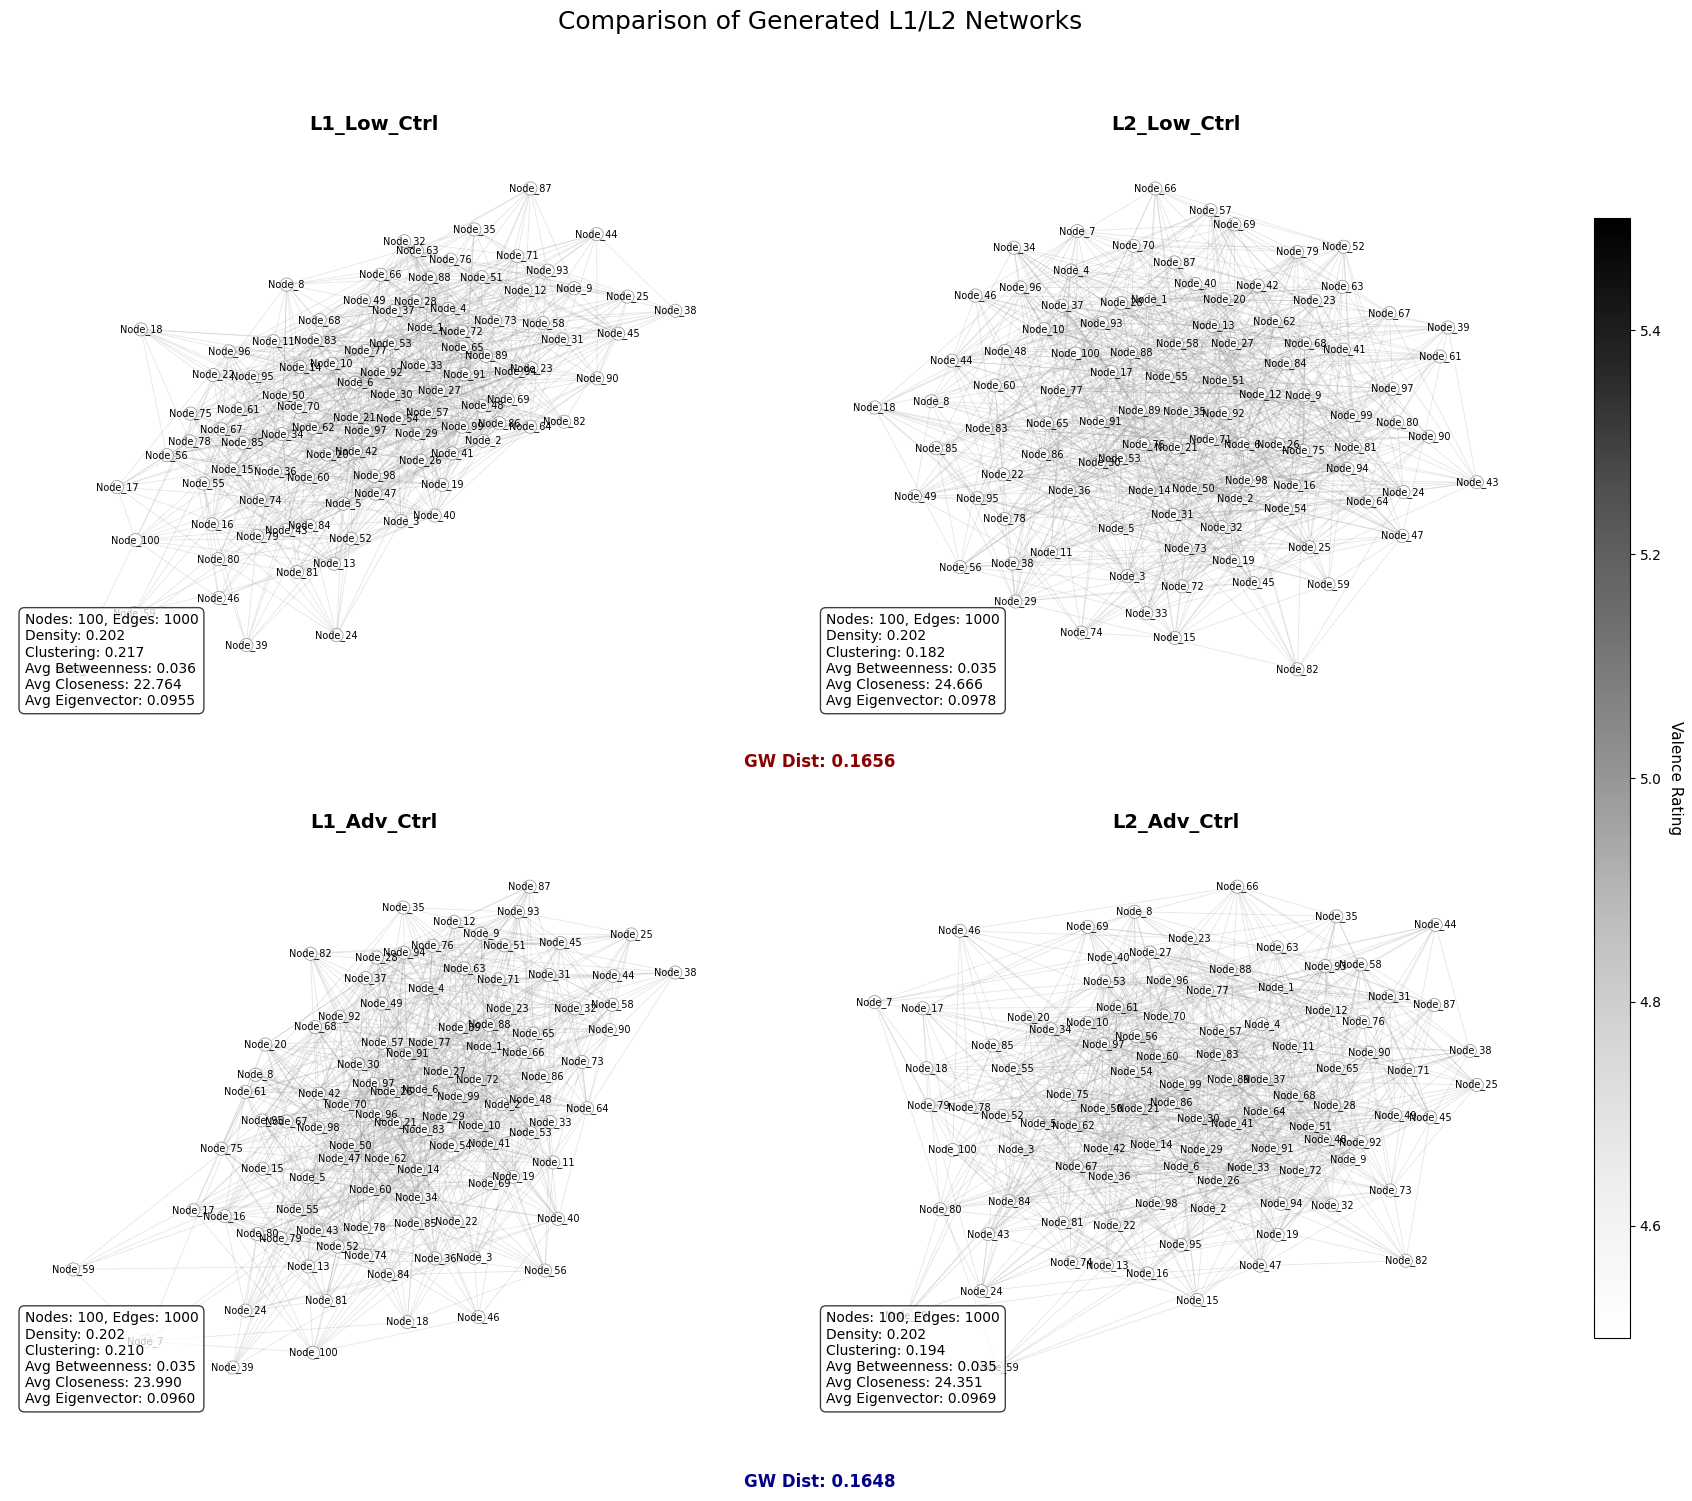


Key Control GW Distances (Recalculated):
  GW(L1 Low vs L2 Low): 0.1656
  GW(L1 Adv vs L2 Adv): 0.1648


In [14]:
# --- Cell 14: Centrality-Boosted Network Simulation ---

print("\n--- Setting up Centrality-Boosted Control Simulation (Using Baseline Centrality) ---")

# --- Simulation Parameters ---
if 'TARGET_NUM_NODES' not in locals() or 'TARGET_NUM_EDGES' not in locals():
    print("Warning: TARGET_NUM_NODES or TARGET_NUM_EDGES not defined. Using defaults.")
    TARGET_NUM_NODES = 100; TARGET_NUM_EDGES = 1000
CONTROL_NUM_NODES = TARGET_NUM_NODES; CONTROL_NUM_EDGES = TARGET_NUM_EDGES
CONTROL_SEMANTIC_WEIGHT = 1.0

# --- Define Parameters for Centrality Boost ---
# Slopes based on user's findings/hypothesis
PARAMS_CENTRALITY = {
    'L1_Low_Ctrl':  {'target_num_edges': CONTROL_NUM_EDGES, 'semantic_weight': CONTROL_SEMANTIC_WEIGHT, 'centrality_slope': 1.5},
    'L1_Adv_Ctrl':  {'target_num_edges': CONTROL_NUM_EDGES, 'semantic_weight': CONTROL_SEMANTIC_WEIGHT, 'centrality_slope': 1.0},
    'L2_Adv_Ctrl':  {'target_num_edges': CONTROL_NUM_EDGES, 'semantic_weight': CONTROL_SEMANTIC_WEIGHT, 'centrality_slope': 0.5},
    'L2_Low_Ctrl':  {'target_num_edges': CONTROL_NUM_EDGES, 'semantic_weight': CONTROL_SEMANTIC_WEIGHT, 'centrality_slope': 0.0}, # Baseline
}
control_conditions = list(PARAMS_CENTRALITY.keys())

# Define scale_value if needed
if 'scale_value' not in locals():
    def scale_value(value, min_val, max_val):
        if max_val == min_val: return 0.5
        scaled = (value - min_val) / (max_val - min_val); return max(0.0, min(1.0, scaled))
    print("Defined scale_value locally.")

# --- 1. Generate Synthetic Base Data (Nodes and Weights Only) ---
def generate_synthetic_base_data(num_nodes):
    print(f"Generating synthetic base data for {num_nodes} nodes...")
    nodes = [f"Node_{i+1}" for i in range(num_nodes)]
    base_weights = {}
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            weight = random.uniform(0.05, 1.0); base_weights[(nodes[i], nodes[j])] = weight; base_weights[(nodes[j], nodes[i])] = weight
    print("Synthetic base data generation complete.")
    return nodes, base_weights

control_nodes, control_base_weights = generate_synthetic_base_data(CONTROL_NUM_NODES)

# --- 2. Generate Baseline Network (Slope=0) ---
print("\n--- Generating Baseline Control Network (Slope=0) ---")
baseline_condition = 'L2_Low_Ctrl' # Condition with slope 0
baseline_params = PARAMS_CENTRALITY[baseline_condition]

# Simplified generator for baseline (no boost needed)
def generate_baseline_network(nodes, base_weights, condition_params):
    target_num_edges = condition_params.get('target_num_edges'); semantic_weight = condition_params.get('semantic_weight')
    print(f"Generating baseline network (Edges={target_num_edges})...")
    n = len(nodes); G = nx.Graph(); G.add_nodes_from(nodes)
    if n <= 1: return G
    potential_edges = []
    for i in range(n):
        node_i = nodes[i]
        for j in range(i + 1, n):
            node_j = nodes[j]
            base_weight = base_weights.get((node_i, node_j), 0.0) * semantic_weight
            if base_weight > 1e-9: # Only consider edges with non-zero base weight
                 potential_edges.append((node_i, node_j, base_weight, base_weights.get((node_i, node_j), 0.0))) # Score is just base weight
    potential_edges.sort(key=lambda x: x[2], reverse=True)
    actual_num_edges = min(target_num_edges, len(potential_edges))
    selected_edges = potential_edges[:actual_num_edges]
    for u, v, score, orig_weight in selected_edges: G.add_edge(u, v, weight=orig_weight)
    print(f"  Generated baseline graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

G_baseline = generate_baseline_network(control_nodes, control_base_weights, baseline_params)

# --- 3. Calculate ACTUAL Baseline Centralities ---
print("\n--- Calculating Actual Centralities from Baseline Network ---")
baseline_centralities = {} # Store calculated Eigenvector and Closeness
INT_SCALE_FACTOR = 10000 # For Betweenness calculation consistency if needed later

if G_baseline.number_of_nodes() > 1 and G_baseline.number_of_edges() > 0:
    largest_cc_subgraph_base = None
    nodes_in_lcc_base = set(G_baseline.nodes())
    if nx.is_connected(G_baseline): largest_cc_subgraph_base = G_baseline.copy()
    else:
        components_base = list(nx.connected_components(G_baseline))
        if components_base:
            largest_cc_nodes_base = max(components_base, key=len)
            if len(largest_cc_nodes_base) > 1: largest_cc_subgraph_base = G_baseline.subgraph(largest_cc_nodes_base).copy(); nodes_in_lcc_base = largest_cc_nodes_base
            else: largest_cc_subgraph_base = None
        else: largest_cc_subgraph_base = None

    eigen_dict_base = {}; close_dict_base = {}
    if largest_cc_subgraph_base is not None:
        # Calculate Eigenvector on LCC
        try: eigen_dict_base = nx.eigenvector_centrality(largest_cc_subgraph_base, weight='weight', max_iter=1000, tol=1e-06)
        except Exception as e: print(f" Warn: Baseline Eigenvector failed: {e}")
        # Calculate Closeness on LCC (needs distance attribute)
        try:
            max_sim = 1.0
            for u, v, data in largest_cc_subgraph_base.edges(data=True):
                sim = data.get('weight', 0.0); dist = max_sim - sim if isinstance(sim, (int, float)) and 0.0 <= sim <= max_sim else max_sim
                if dist <= 0: dist = 1e-9
                largest_cc_subgraph_base[u][v]['distance'] = dist
            close_dict_base = nx.closeness_centrality(largest_cc_subgraph_base, distance='distance')
        except Exception as e: print(f" Warn: Baseline Closeness failed: {e}")

    # Store calculated centralities, assigning 0/defaults for nodes outside LCC or if calc failed
    for node in control_nodes:
        baseline_centralities[node] = {
            'ActualEigenvector': eigen_dict_base.get(node, 0.0) if node in nodes_in_lcc_base else 0.0,
            'ActualCloseness': close_dict_base.get(node, 0.0) if node in nodes_in_lcc_base else 0.0
        }
    print("Calculated actual baseline centralities.")
else:
    print("Baseline graph has too few nodes/edges to calculate centralities. Assigning defaults.")
    for node in control_nodes: baseline_centralities[node] = {'ActualEigenvector': 0.0, 'ActualCloseness': 0.0}


# --- 4. Modified Network Generation Function (using baseline centralities) ---

def generate_centrality_boosted_network_actual(nodes, baseline_centralities, base_weights, condition_params):
    """
    Generates a network where edge selection is boosted by similarity
    in ACTUAL baseline centrality scores, using a linear boost and interaction structure.
    """
    target_num_edges = condition_params.get('target_num_edges'); semantic_weight = condition_params.get('semantic_weight'); centrality_slope = condition_params.get('centrality_slope')
    print(f"\nGenerating centrality-boosted network (Edges={target_num_edges}, Slope={centrality_slope:.2f})...")
    print("  Using Interaction: ActualCentSimilarity * Max(ActualNodeImportance)")
    n = len(nodes); G = nx.Graph(); G.add_nodes_from(nodes)
    if n <= 1: return G

    # --- Get Centrality Vectors and Node Importance ---
    actual_vectors = {}
    node_importance = {} # Store calculated importance for each node
    all_eigen = []
    all_close = []
    print("  Calculating actual centrality vectors and node importance...")
    for node in nodes:
        if node in baseline_centralities:
             # Use calculated baseline centralities
             eigen = baseline_centralities[node].get('ActualEigenvector', 0.0)
             close = baseline_centralities[node].get('ActualCloseness', 0.0)
             actual_vectors[node] = np.array([eigen, close])
             # Define Node Importance as the average of its centralities
             node_importance[node] = (eigen + close) / 2.0
             all_eigen.append(eigen); all_close.append(close)
        else:
             actual_vectors[node] = None
             node_importance[node] = 0.0

    # --- Calculate Max Distance for Scaling Similarity ---
    if not all_eigen or not all_close or len(all_eigen) < 2: max_cent_dist = 1.0
    else:
        min_e, max_e = min(all_eigen), max(all_eigen); min_c, max_c = min(all_close), max(all_close)
        cent_range_sq = (max_e - min_e)**2 + (max_c - min_c)**2
        max_cent_dist = np.sqrt(cent_range_sq) if cent_range_sq > 1e-9 else 1.0

    # --- Calculate Centrality Similarity, Interaction Score, and Final Scores ---
    potential_edges = []
    for i in range(n):
        node_i = nodes[i]; vec_i = actual_vectors.get(node_i)
        importance_i = node_importance.get(node_i, 0.0)
        for j in range(i + 1, n):
            node_j = nodes[j]; vec_j = actual_vectors.get(node_j)
            importance_j = node_importance.get(node_j, 0.0)

            base_weight = base_weights.get((node_i, node_j), 0.0) * semantic_weight

            # Calculate Centrality Similarity based on baseline centralities
            cent_sim = 0.5 # Default neutral similarity
            if vec_i is not None and vec_j is not None:
                dist = euclidean(vec_i, vec_j)
                cent_sim = 1.0 - scale_value(dist, 0, max_cent_dist)

            # Calculate Interaction Score using importance
            interaction_score_cent = cent_sim * max(importance_i, importance_j)
            interaction_score_cent = max(0.0, min(1.0, interaction_score_cent)) # Clamp

            # Linear Boost based on Interaction Score
            boost = 1.0 + (centrality_slope * cent_sim)

            # Final Score
            final_score = base_weight * boost

            if final_score > 1e-9:
                potential_edges.append((node_i, node_j, final_score, base_weights.get((node_i, node_j), 0.0)))

    # --- Select Edges ---
    potential_edges.sort(key=lambda x: x[2], reverse=True)
    actual_num_edges = min(target_num_edges, len(potential_edges))
    selected_edges = potential_edges[:actual_num_edges]
    for u, v, score, orig_weight in selected_edges: G.add_edge(u, v, weight=orig_weight)
    print(f"  Generated graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

# --- 5. Generate Networks for Each Condition (using baseline centralities) ---
print("\n--- Generating Centrality-Boosted Networks (Based on Actual Baseline Centrality) ---")
control_graphs = {}
# Store the baseline graph first
control_graphs[baseline_condition] = G_baseline
# Generate other conditions using baseline centralities
for condition_name in control_conditions:
    if condition_name == baseline_condition: continue # Skip baseline
    params = PARAMS_CENTRALITY[condition_name]
    control_graphs[condition_name] = generate_centrality_boosted_network_actual(
        control_nodes,
        baseline_centralities,
        control_base_weights,
        params
    )

# --- 6. Calculate Network Metrics ---
print("\n--- Calculating Actual Network Metrics for Control Graphs ---")
control_network_metrics = {}
INT_SCALE_FACTOR = 10000
for name in control_conditions:
    G = control_graphs[name]
    print(f"\nCalculating metrics for: {name}")
    num_nodes = G.number_of_nodes(); num_edges = G.number_of_edges()
    metrics = {'Nodes': num_nodes, 'Edges': num_edges}
    if num_nodes > 1:
        metrics['Density'] = nx.density(G)
        try: metrics['Clustering'] = nx.average_clustering(G, weight='weight')
        except Exception: metrics['Clustering'] = np.nan
        avg_betweenness, avg_closeness, avg_eigenvector = np.nan, np.nan, np.nan
        if num_edges > 0:
            components = list(nx.connected_components(G)); is_connected = (len(components) == 1)
            largest_cc_subgraph = None; nodes_in_lcc = set()
            if is_connected: largest_cc_subgraph = G.copy(); nodes_in_lcc = set(G.nodes())
            elif components:
                largest_cc_nodes = max(components, key=len)
                if len(largest_cc_nodes) > 1: largest_cc_subgraph = G.subgraph(largest_cc_nodes).copy(); nodes_in_lcc = largest_cc_nodes
            if largest_cc_subgraph is not None and largest_cc_subgraph.number_of_nodes() > 1:
                distance_attr_added = False; int_distance_attr_added = False
                try:
                    max_sim = 1.0
                    for u, v, data in largest_cc_subgraph.edges(data=True):
                        sim = data.get('weight', 0.0); dist = max_sim - sim if isinstance(sim, (int, float)) and 0.0 <= sim <= max_sim else max_sim
                        if dist <= 0: dist = 1e-9
                        largest_cc_subgraph[u][v]['distance'] = dist
                        int_dist = int(dist * INT_SCALE_FACTOR); int_dist = 1 if dist > 0 and int_dist == 0 else int_dist
                        largest_cc_subgraph[u][v]['int_distance'] = int_dist
                    distance_attr_added = True; int_distance_attr_added = True
                except Exception as e: print(f" Warn: Dist attr failed for {name}: {e}")
                if int_distance_attr_added:
                    try: avg_betweenness = np.mean(list(nx.betweenness_centrality(largest_cc_subgraph, weight='int_distance', normalized=True).values()))
                    except Exception as e: print(f" Warn: Betweenness failed for {name}: {e}"); avg_betweenness = np.nan
                if distance_attr_added:
                    try: avg_closeness = np.mean(list(nx.closeness_centrality(largest_cc_subgraph, distance='distance').values()))
                    except Exception as e: print(f" Warn: Closeness failed for {name}: {e}"); avg_closeness = np.nan
                try: avg_eigenvector = np.mean(list(nx.eigenvector_centrality(largest_cc_subgraph, weight='weight', max_iter=1000, tol=1e-06).values()))
                except Exception as e: print(f" Warn: Eigenvector failed for {name}: {e}"); avg_eigenvector = np.nan
        metrics['Avg Betweenness Centrality'] = avg_betweenness if pd.notna(avg_betweenness) else 'N/A'
        metrics['Avg Closeness Centrality'] = avg_closeness if pd.notna(avg_closeness) else 'N/A'
        metrics['Avg Eigenvector Centrality'] = avg_eigenvector if pd.notna(avg_eigenvector) else 'N/A'
    else: metrics['Density'], metrics['Clustering'], metrics['Avg Betweenness Centrality'], metrics['Avg Closeness Centrality'], metrics['Avg Eigenvector Centrality'] = 0.0, 0.0, 'N/A', 'N/A', 'N/A'
    control_network_metrics[name] = metrics

# Display Metrics Summary
print("\n--- Control Network Metrics Summary (Based on Actual Baseline Centrality) ---")
metrics_df_ctrl = pd.DataFrame(control_network_metrics).T
metrics_df_ctrl = metrics_df_ctrl.reindex(['L1_Low_Ctrl', 'L1_Adv_Ctrl', 'L2_Adv_Ctrl', 'L2_Low_Ctrl'])
cols_order = ['Nodes', 'Edges', 'Density', 'Clustering', 'Avg Betweenness Centrality', 'Avg Closeness Centrality', 'Avg Eigenvector Centrality']
existing_cols = [col for col in cols_order if col in metrics_df_ctrl.columns]; metrics_df_ctrl = metrics_df_ctrl[existing_cols]
metrics_df_ctrl = metrics_df_ctrl.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) and pd.notna(x) else x)
print(metrics_df_ctrl)

# --- 7. Calculate GW Distances ---
print("\n--- Calculating GW Distances for Control Networks ---")
control_gw_distances = {}
pairs_to_compare_ctrl = [('L1_Low_Ctrl', 'L2_Low_Ctrl'), ('L1_Adv_Ctrl', 'L2_Adv_Ctrl')]
if 'compare_structures_gw' not in locals(): print("ERROR: 'compare_structures_gw' function not defined.")
else:
    for name1, name2 in pairs_to_compare_ctrl:
        if name1 in control_graphs and name2 in control_graphs:
            gw_dist, _ = compare_structures_gw(control_graphs[name1], control_graphs[name2], name1=name1, name2=name2)
            control_gw_distances[(name1, name2)] = gw_dist
        else: print(f"Skipping GW for ({name1}, {name2})"); control_gw_distances[(name1, name2)] = np.nan
    print("\n--- Control GW Distance Summary ---")
    if control_gw_distances:
        for (n1, n2), dist in control_gw_distances.items(): print(f"GW Dist ({n1.replace('_Ctrl','')} vs {n2.replace('_Ctrl','')}) : {dist:.6f}" if pd.notna(dist) else f"GW Dist ({n1} vs {n2}): Error/N/A")
    else: print("No GW distances calculated.")

# --- 8. Visualize Network Structures ---
print("\n--- Visualizing Control Network Structures ---")
control_plot_order = ['L1_Low_Ctrl', 'L2_Low_Ctrl', 'L1_Adv_Ctrl', 'L2_Adv_Ctrl']
dummy_ratings = {node: {'Valence': 5, 'Arousal': 5} for node in control_nodes}
control_titles_map = {'L1_Low_Ctrl': "L1 Low (Slope=1.5)", 'L1_Adv_Ctrl': "L1 Adv (Slope=1.0)", 'L2_Adv_Ctrl': "L2 Adv (Slope=0.5)", 'L2_Low_Ctrl': "L2 Low (Slope=0.0)"}
if 'visualize_comparison' in locals():
     original_titles_map = visualize_comparison.__globals__.get('titles_map', {}); visualize_comparison.__globals__['titles_map'] = control_titles_map
     if all(key in control_graphs for key in control_plot_order) and all(key in control_network_metrics for key in control_plot_order):
         if 'BASE_OUTPUT_DIR' not in locals(): BASE_OUTPUT_DIR = "colab_output_ctrl"; os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)
         ctrl_viz_filename = os.path.join(BASE_OUTPUT_DIR, "Control_Network_Comparison_ActualCent.png") # New filename
         gw_display_dict = {('L1_Eng_Adv', 'L2_Eng_Low'): control_gw_distances.get(('L1_Low_Ctrl', 'L2_Low_Ctrl'), np.nan), ('L1_Eng_Adv', 'L2_Eng_Adv'): control_gw_distances.get(('L1_Adv_Ctrl', 'L2_Adv_Ctrl'), np.nan)}
         visualize_comparison(graphs_dict=control_graphs, metrics_dict=control_network_metrics, gw_distances_dict=gw_display_dict, plot_order=control_plot_order, ratings_all_dict=dummy_ratings, rating_key='Valence', cmap_name='Greys', filename=ctrl_viz_filename)
         print("\nKey Control GW Distances (Recalculated):")
         gw_l1L_l2L = control_gw_distances.get(('L1_Low_Ctrl', 'L2_Low_Ctrl'), np.nan); gw_l1A_l2A = control_gw_distances.get(('L1_Adv_Ctrl', 'L2_Adv_Ctrl'), np.nan)
         print(f"  GW(L1 Low vs L2 Low): {gw_l1L_l2L:.4f}" if pd.notna(gw_l1L_l2L) else "  GW(L1 Low vs L2 Low): N/A")
         print(f"  GW(L1 Adv vs L2 Adv): {gw_l1A_l2A:.4f}" if pd.notna(gw_l1A_l2A) else "  GW(L1 Adv vs L2 Adv): N/A")
     else: print("Skipping control visualization due to missing graphs or metrics.")
     if original_titles_map: visualize_comparison.__globals__['titles_map'] = original_titles_map
     elif 'titles_map' in visualize_comparison.__globals__: del visualize_comparison.__globals__['titles_map']
else: print("Skipping control visualization as 'visualize_comparison' function not found.")

# --- 9. Interactive Association Simulation ---
print("\n--- Setting up Interactive Baseline Centrality Association Simulation ---")

if not control_nodes: print("ERROR: No control nodes generated.")
else:
    control_available_conditions = [cond for cond in control_conditions if cond in control_graphs]; control_available_words = sorted(control_nodes)
    if not control_available_conditions: print("ERROR: No valid control network conditions found.")
    else:
        ctrl_network_dropdown = widgets.Dropdown(options=control_available_conditions, description='Network:', disabled=False)
        ctrl_cue_word_dropdown = widgets.Dropdown(options=control_available_words, description='Cue Node:', disabled=False)
        ctrl_run_button = widgets.Button(description='Run Sim', button_style='info', tooltip='Find associates & analyze ACTUAL baseline centralities', icon='play') # Updated tooltip
        ctrl_output_area = widgets.Output()

        def simulate_actual_centrality_association(b):
            with ctrl_output_area:
                clear_output(wait=True); condition = ctrl_network_dropdown.value; cue_node = ctrl_cue_word_dropdown.value; G = control_graphs.get(condition)
                if G is None: print(f"Error: Graph not found for '{condition}'."); return
                if cue_node not in G: print(f"Error: Cue '{cue_node}' not in graph '{condition}'."); return
                # Use baseline centralities calculated earlier
                if cue_node not in baseline_centralities: print(f"Error: Baseline centralities not found for '{cue_node}'."); return

                print(f"--- Baseline Centrality Simulation Results ---"); print(f"Network Condition: {condition}"); print(f"Cue Node: '{cue_node}'")
                cue_targets = baseline_centralities[cue_node]; cue_eigen = cue_targets.get('ActualEigenvector', np.nan); cue_close = cue_targets.get('ActualCloseness', np.nan)
                print(f"Cue ACTUAL Baseline Centralities: Eigen={cue_eigen:.3f}, Close={cue_close:.3f}")
                associates = list(G.neighbors(cue_node)); print(f"\nFound {len(associates)} associate(s): {', '.join(associates) if associates else 'None'}")
                if not associates: print("\nNo associates found."); return

                assoc_eigen_list = []; assoc_close_list = []; valid_associates = 0
                print("\nAssociate ACTUAL Baseline Centralities:")
                for assoc in associates:
                    if assoc in baseline_centralities:
                        assoc_targets = baseline_centralities[assoc]; assoc_e = assoc_targets.get('ActualEigenvector', np.nan); assoc_c = assoc_targets.get('ActualCloseness', np.nan)
                        print(f"- '{assoc}': Eigen={assoc_e:.3f}, Close={assoc_c:.3f}")
                        if pd.notna(assoc_e) and pd.notna(assoc_c): valid_associates += 1; assoc_eigen_list.append(assoc_e); assoc_close_list.append(assoc_c)
                    else: print(f"- '{assoc}': Baseline centralities not found.")

                if valid_associates > 0:
                    avg_e = np.mean(assoc_eigen_list); std_e = np.std(assoc_eigen_list) if valid_associates > 1 else 0.0
                    avg_c = np.mean(assoc_close_list); std_c = np.std(assoc_close_list) if valid_associates > 1 else 0.0
                    print(f"\nAvg Associate ACTUAL Baseline Centrality: Eigen={avg_e:.3f} (SD={std_e:.3f}), Close={avg_c:.3f} (SD={std_c:.3f})")
                    print("\nACTUAL Baseline Centrality Effects Summary:")
                    if pd.notna(cue_eigen): print(f"- Eigenvector Shift (Avg Assoc - Cue): {avg_e - cue_eigen:+.3f}")
                    if pd.notna(cue_close): print(f"- Closeness Shift (Avg Assoc - Cue): {avg_c - cue_close:+.3f}")
                else: print("\nNo valid associates with baseline centralities found.")

        # Link and Display
        ctrl_run_button.on_click(simulate_actual_centrality_association)
        print("Select a control network and a cue node, then click 'Run Sim'.")
        display(ctrl_network_dropdown, ctrl_cue_word_dropdown, ctrl_run_button, ctrl_output_area)
print("\n--- Centrality Control Simulation Cell End ---")

output.no_vertical_scroll()

# 15. Comparison of Centrality Measures


--- Visualizing Eigenvector, Closeness & Betweenness Centrality ---
Created Barbell Graph: 17 nodes, 46 edges
Calculating centralities...


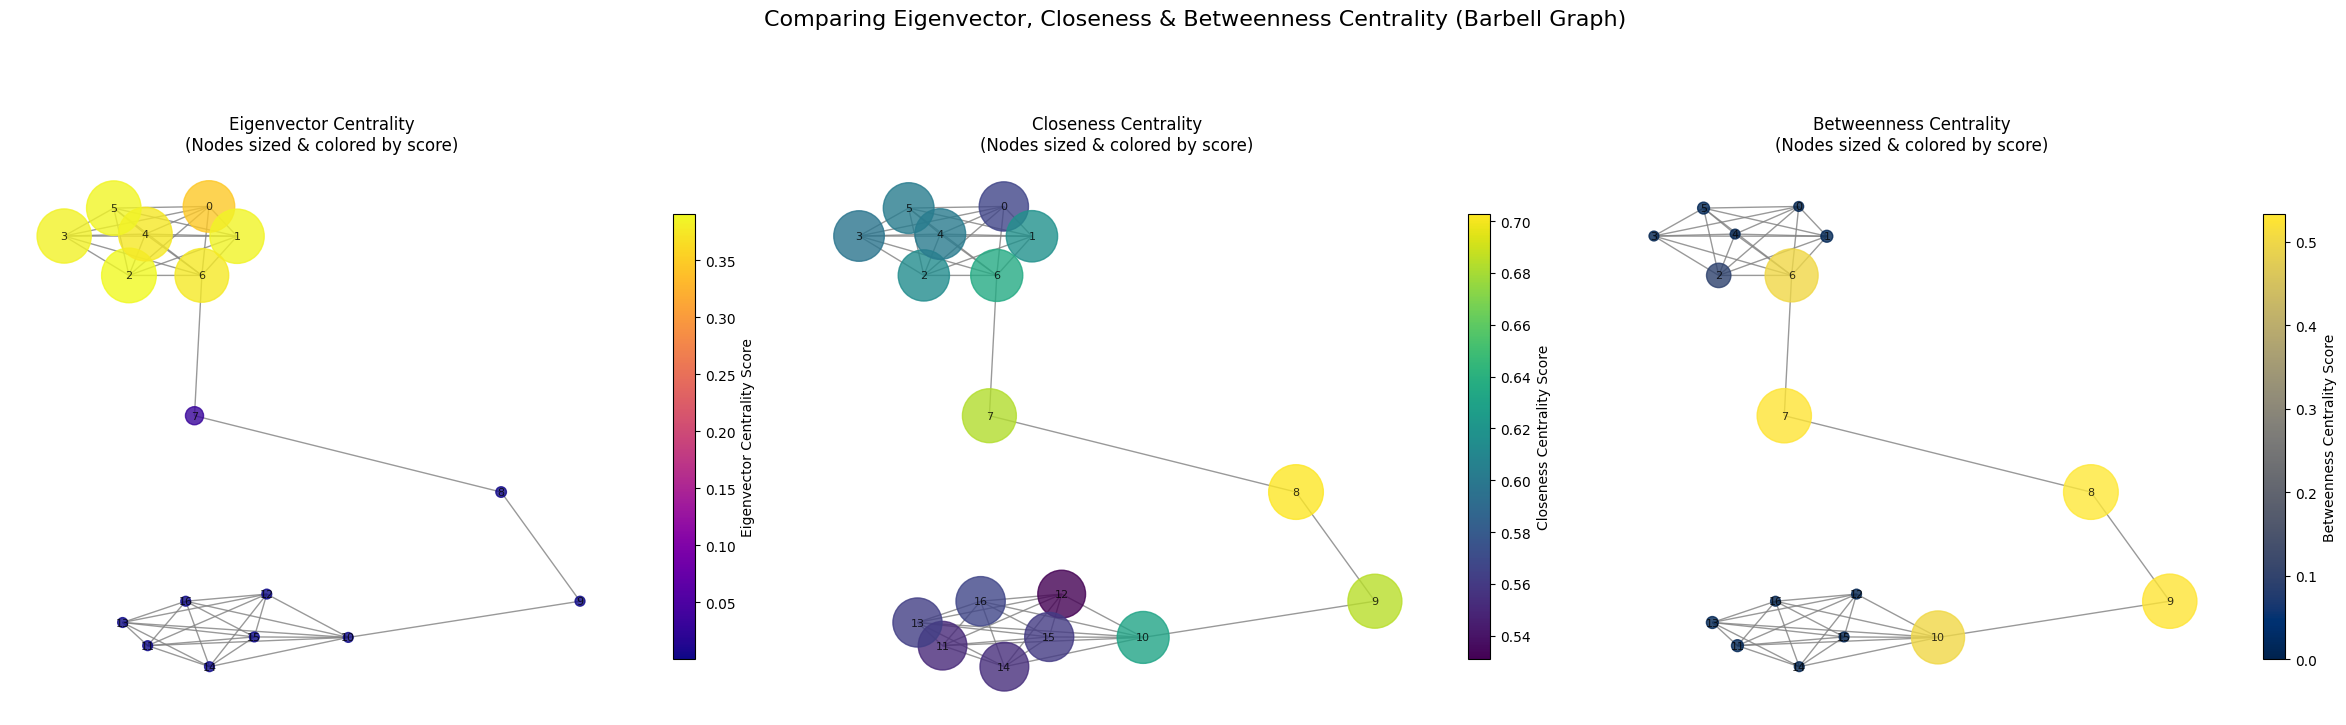


Interpretation:
- Eigenvector Centrality: Highest scores are typically deep within the dense end clusters.
- Closeness Centrality: Highest scores are often near the 'center' - nodes on/near the bridge.
- Betweenness Centrality: Highest scores are on the 'bridge' nodes connecting the two clusters.


In [15]:
# --- Cell 15: Visualizing Eigenvector, Closeness & Betweenness Centrality ---

print("\n--- Visualizing Eigenvector, Closeness & Betweenness Centrality ---")

# --- 1. Create an Example Graph (Barbell Graph) ---
m1 = 7 # Size of the end clusters
m2 = 3 # Length of the path connecting them
G_barbell = nx.barbell_graph(m1, m2)

# --- 2. Add Example Weights (Simulating Similarity) ---
cluster1_nodes = range(m1)
path_nodes = range(m1, m1 + m2 + 1)
cluster2_nodes = range(m1 + m2 + 1, 2 * m1 + m2 + 1)

max_similarity = 1.0
epsilon = 1e-9
INT_SCALE_FACTOR_VIZ = 10000 # Scaling factor for integer weights

for u, v in G_barbell.edges():
    if (u in cluster1_nodes and v in cluster1_nodes) or \
       (u in cluster2_nodes and v in cluster2_nodes):
        similarity = np.random.uniform(0.7, 0.95)
    elif (u in path_nodes and v in path_nodes):
        similarity = np.random.uniform(0.2, 0.4)
    else:
        similarity = np.random.uniform(0.4, 0.6)

    G_barbell[u][v]['weight'] = similarity
    # Calculate float distance
    distance = max_similarity - similarity
    G_barbell[u][v]['distance'] = max(epsilon, distance)
    # Calculate integer distance
    int_distance = int(distance * INT_SCALE_FACTOR_VIZ)
    G_barbell[u][v]['int_distance'] = max(1, int_distance) if distance > 0 else 0 # Ensure non-zero float distance maps to at least 1

print(f"Created Barbell Graph: {G_barbell.number_of_nodes()} nodes, {G_barbell.number_of_edges()} edges")

# --- 3. Calculate Centralities ---
print("Calculating centralities...")
eigenvector_cents = {}
closeness_cents = {}
betweenness_cents = {}

try:
    eigenvector_cents = nx.eigenvector_centrality(G_barbell, weight='weight', max_iter=1000)
except nx.PowerIterationFailedConvergence: print("Warning: Eigenvector centrality did not converge."); eigenvector_cents = {n: 0.0 for n in G_barbell.nodes()}
except Exception as e: print(f"Error calculating eigenvector: {e}"); eigenvector_cents = {n: 0.0 for n in G_barbell.nodes()}

try:
    # Closeness uses float inverted 'distance' weight
    if nx.is_connected(G_barbell):
        closeness_cents = nx.closeness_centrality(G_barbell, distance='distance')
    else: # Should not happen for barbell, but handle anyway
        largest_cc_nodes = max(nx.connected_components(G_barbell), key=len)
        subgraph = G_barbell.subgraph(largest_cc_nodes)
        closeness_cents_sub = nx.closeness_centrality(subgraph, distance='distance')
        closeness_cents = {n: closeness_cents_sub.get(n, 0.0) for n in G_barbell.nodes()}
except Exception as e: print(f"Error calculating closeness: {e}"); closeness_cents = {n: 0.0 for n in G_barbell.nodes()}

try:
    # Betweenness uses integer inverted 'int_distance' weight
    if nx.is_connected(G_barbell):
         betweenness_cents = nx.betweenness_centrality(G_barbell, weight='int_distance', normalized=True)
    else: # Should not happen for barbell
         largest_cc_nodes = max(nx.connected_components(G_barbell), key=len)
         subgraph = G_barbell.subgraph(largest_cc_nodes)
         betweenness_cents_sub = nx.betweenness_centrality(subgraph, weight='int_distance', normalized=True)
         betweenness_cents = {n: betweenness_cents_sub.get(n, 0.0) for n in G_barbell.nodes()}

except Exception as e: print(f"Error calculating betweenness: {e}"); betweenness_cents = {n: 0.0 for n in G_barbell.nodes()}


# --- 4. Prepare for Plotting ---
pos = nx.spring_layout(G_barbell, seed=42, k=0.5)

eigen_values = np.array(list(eigenvector_cents.values()))
close_values = np.array(list(closeness_cents.values()))
between_values = np.array(list(betweenness_cents.values()))

size_scale = 1500
eigen_sizes = (eigen_values / eigen_values.max() * size_scale) + 50 if eigen_values.max() > 0 else np.full(len(eigen_values), 50)
close_sizes = (close_values / close_values.max() * size_scale) + 50 if close_values.max() > 0 else np.full(len(close_values), 50)
between_sizes = (between_values / between_values.max() * size_scale) + 50 if between_values.max() > 0 else np.full(len(between_values), 50)

# --- 5. Create Plots (1x3 Layout) ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) # Adjusted figsize for 3 plots
fig.suptitle("Comparing Eigenvector, Closeness & Betweenness Centrality (Barbell Graph)", fontsize=16, y=1.03)

# Plot 1: Eigenvector Centrality
ax1 = axes[0]
cmap_eigen = plt.cm.plasma
norm_eigen = mcolors.Normalize(vmin=eigen_values.min(), vmax=eigen_values.max())
nx.draw(G_barbell, pos, ax=ax1, node_color=eigen_values, cmap=cmap_eigen, node_size=eigen_sizes,
        with_labels=True, font_size=8, edge_color='grey', alpha=0.8)
ax1.set_title("Eigenvector Centrality\n(Nodes sized & colored by score)")
sm_eigen = plt.cm.ScalarMappable(cmap=cmap_eigen, norm=norm_eigen); sm_eigen.set_array([])
cbar_eigen = fig.colorbar(sm_eigen, ax=ax1, shrink=0.8); cbar_eigen.set_label('Eigenvector Centrality Score')

# Plot 2: Closeness Centrality
ax2 = axes[1]
cmap_close = plt.cm.viridis
norm_close = mcolors.Normalize(vmin=close_values.min(), vmax=close_values.max())
nx.draw(G_barbell, pos, ax=ax2, node_color=close_values, cmap=cmap_close, node_size=close_sizes,
        with_labels=True, font_size=8, edge_color='grey', alpha=0.8)
ax2.set_title("Closeness Centrality\n(Nodes sized & colored by score)")
sm_close = plt.cm.ScalarMappable(cmap=cmap_close, norm=norm_close); sm_close.set_array([])
cbar_close = fig.colorbar(sm_close, ax=ax2, shrink=0.8); cbar_close.set_label('Closeness Centrality Score')

# Plot 3: Betweenness Centrality
ax3 = axes[2]
cmap_between = plt.cm.cividis # Use a different colormap
norm_between = mcolors.Normalize(vmin=between_values.min(), vmax=between_values.max())
nx.draw(G_barbell, pos, ax=ax3, node_color=between_values, cmap=cmap_between, node_size=between_sizes,
        with_labels=True, font_size=8, edge_color='grey', alpha=0.8)
ax3.set_title("Betweenness Centrality\n(Nodes sized & colored by score)")
sm_between = plt.cm.ScalarMappable(cmap=cmap_between, norm=norm_between); sm_between.set_array([])
cbar_between = fig.colorbar(sm_between, ax=ax3, shrink=0.8); cbar_between.set_label('Betweenness Centrality Score')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\nInterpretation:")
print("- Eigenvector Centrality: Highest scores are typically deep within the dense end clusters.")
print("- Closeness Centrality: Highest scores are often near the 'center' - nodes on/near the bridge.")
print("- Betweenness Centrality: Highest scores are on the 'bridge' nodes connecting the two clusters.")

# 16. OLS Regression: Predicting Node Centrality from Emotional Ratings


--- Running Regression Analysis & Visualization ---
Predicting Node Centrality ~ Valence Salience + Arousal Activation
Prerequisites found. Proceeding with analysis.
Calculating predictor variables (Valence Salience, Arousal Activation)...
Calculated predictors for 100 words.
Calculating outcome variables (Node Centralities)...
Processing graph: L1_Eng_Adv (100 nodes, 1000 edges)
Processing graph: L2_Eng_Adv (100 nodes, 1000 edges)
Processing graph: L2_Eng_Low (100 nodes, 1000 edges)

--- Regression Model Summaries & Visualizations ---

=============== Condition: L1_Eng_Adv ===============

--- Predicting: Clustering ---
                            OLS Regression Results                            
Dep. Variable:        Q('Clustering')   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6827
Date:                Thu, 15 May 2025   Prob (F-statis

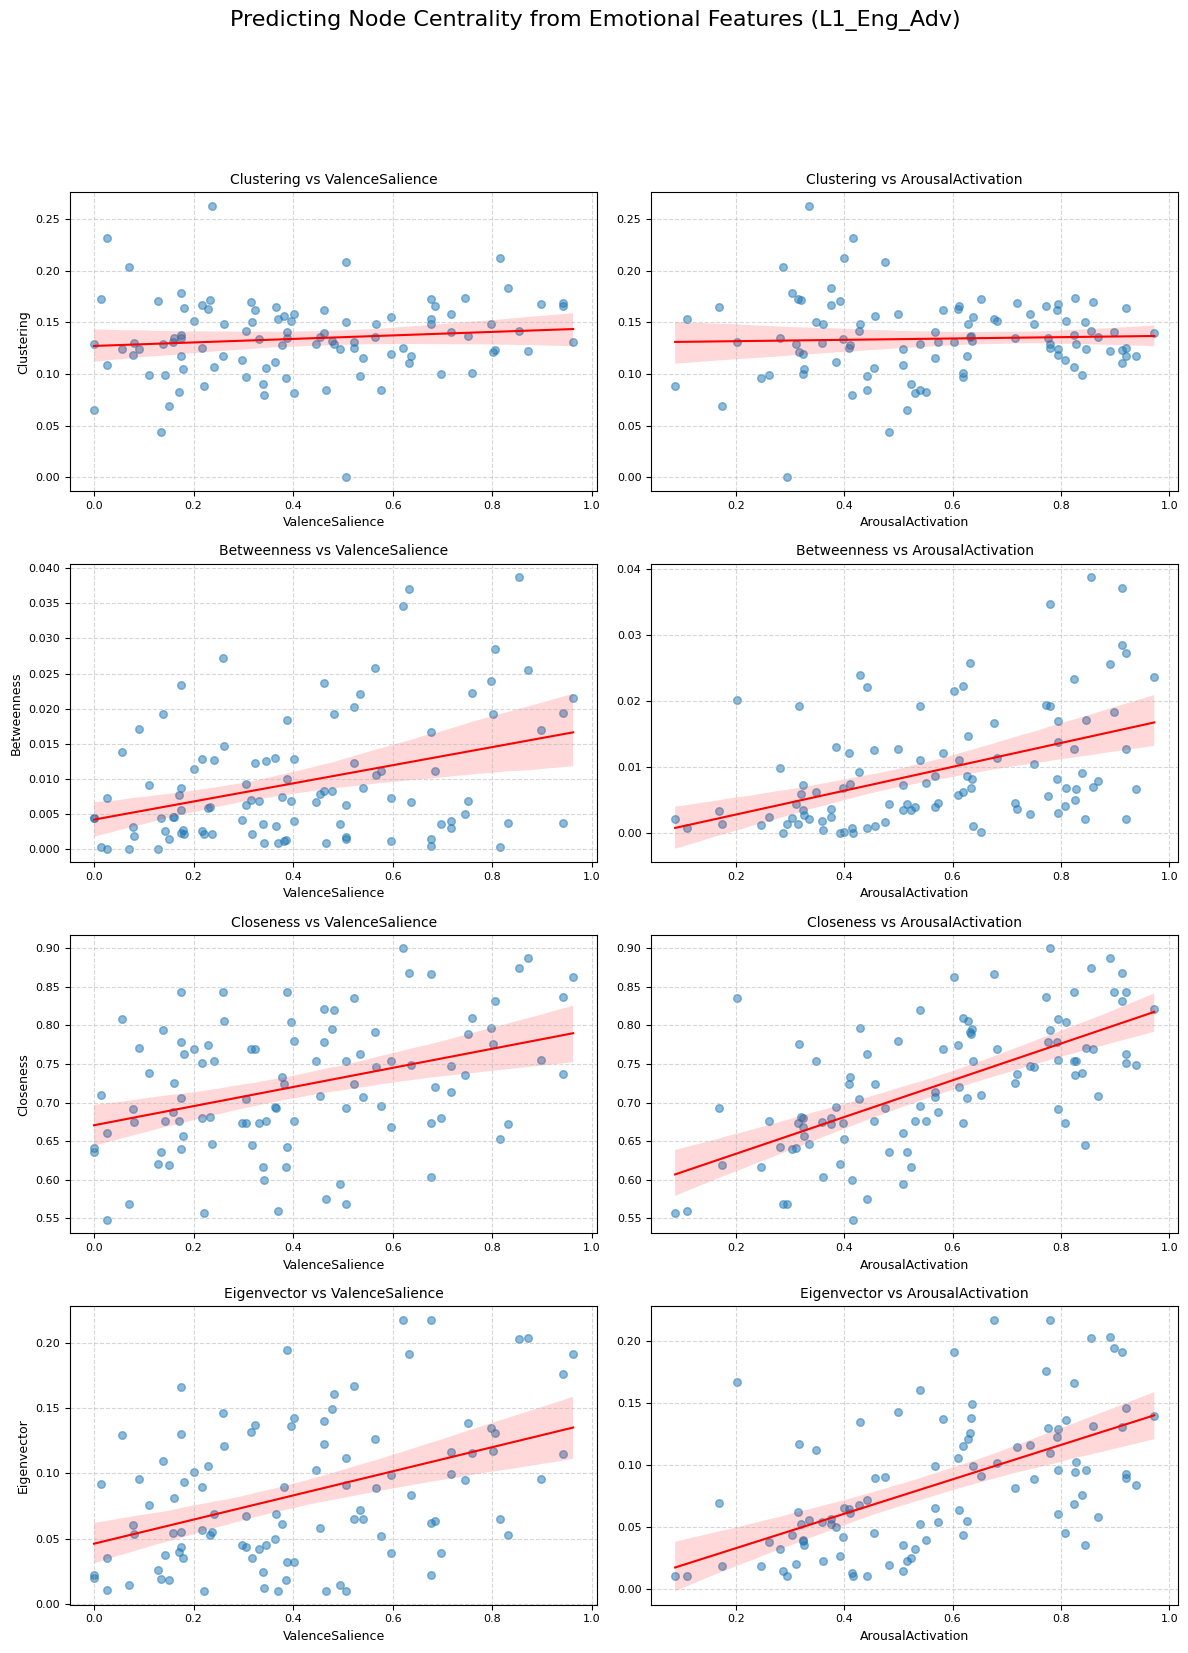


=============== Condition: L2_Eng_Adv ===============

--- Predicting: Clustering ---
                            OLS Regression Results                            
Dep. Variable:        Q('Clustering')   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.322
Date:                Thu, 15 May 2025   Prob (F-statistic):              0.104
Time:                        18:41:43   Log-Likelihood:                 194.86
No. Observations:                 100   AIC:                            -383.7
Df Residuals:                      97   BIC:                            -375.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

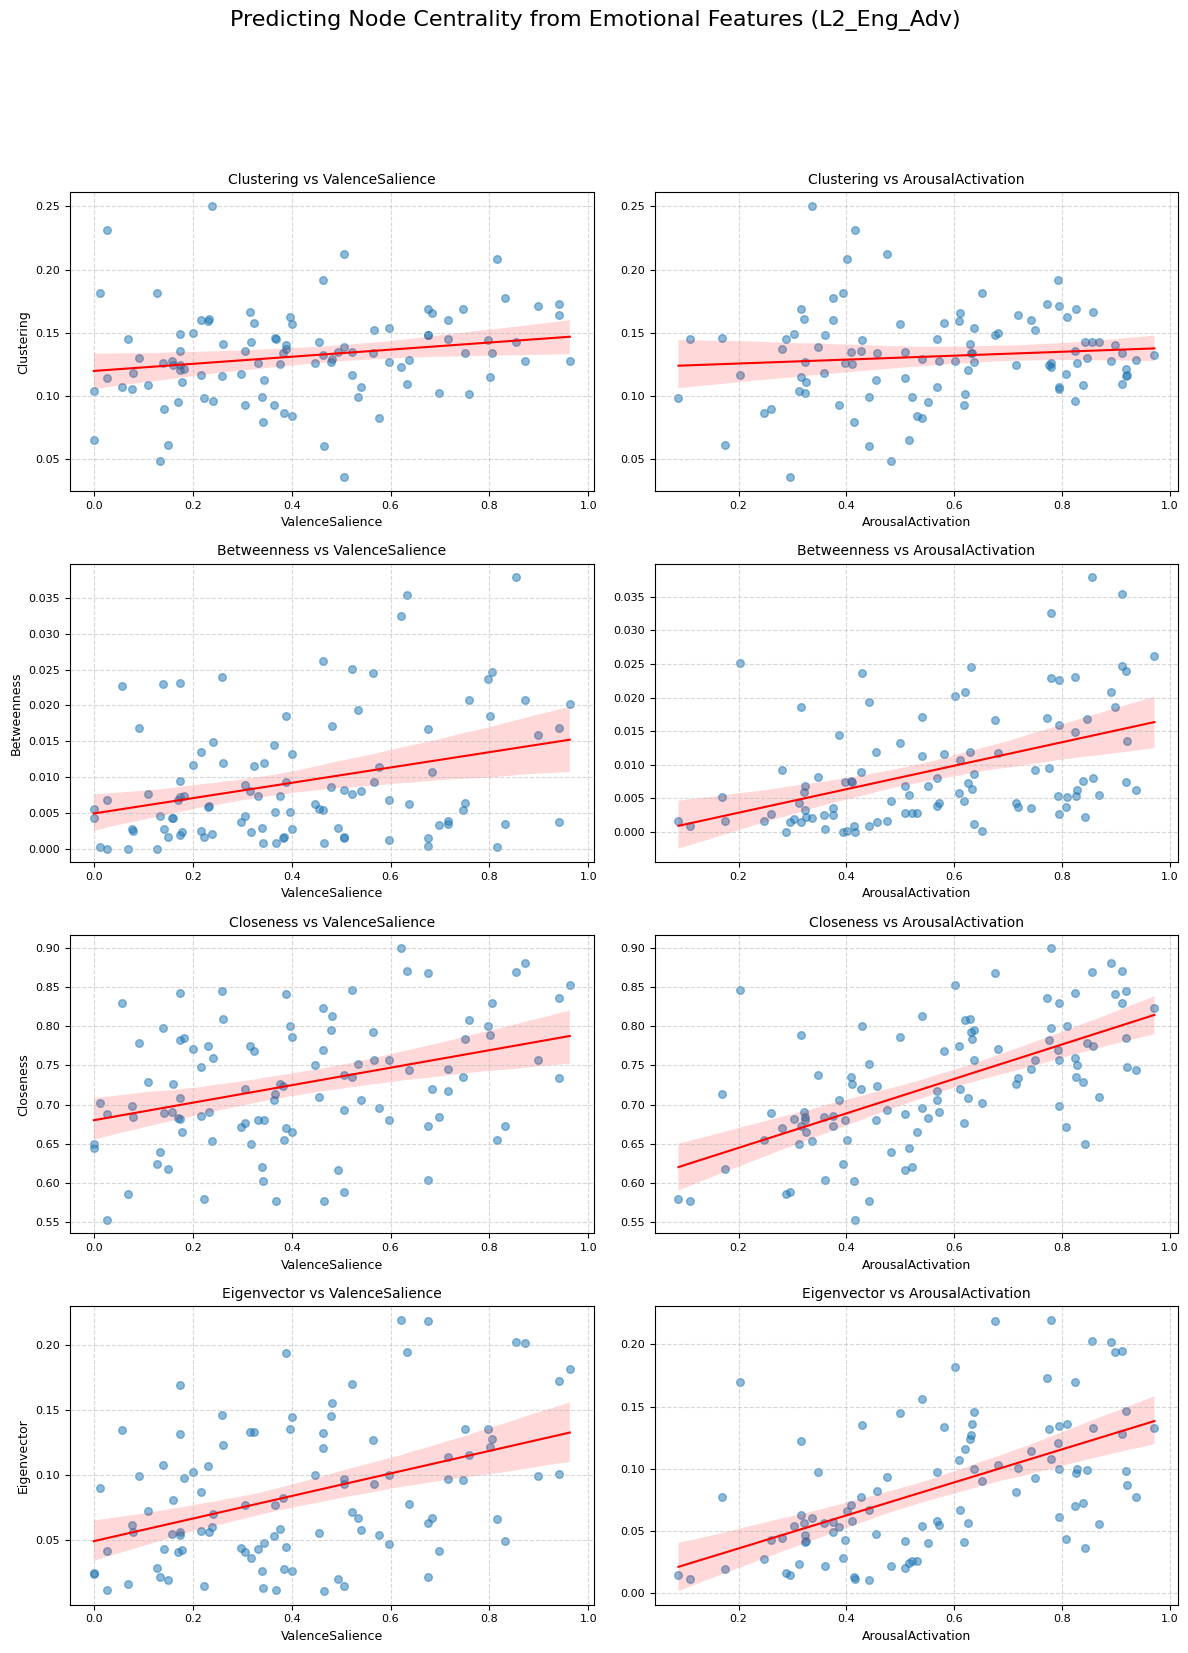


=============== Condition: L2_Eng_Low ===============

--- Predicting: Clustering ---
                            OLS Regression Results                            
Dep. Variable:        Q('Clustering')   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     3.460
Date:                Thu, 15 May 2025   Prob (F-statistic):             0.0354
Time:                        18:41:44   Log-Likelihood:                 193.43
No. Observations:                 100   AIC:                            -380.9
Df Residuals:                      97   BIC:                            -373.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

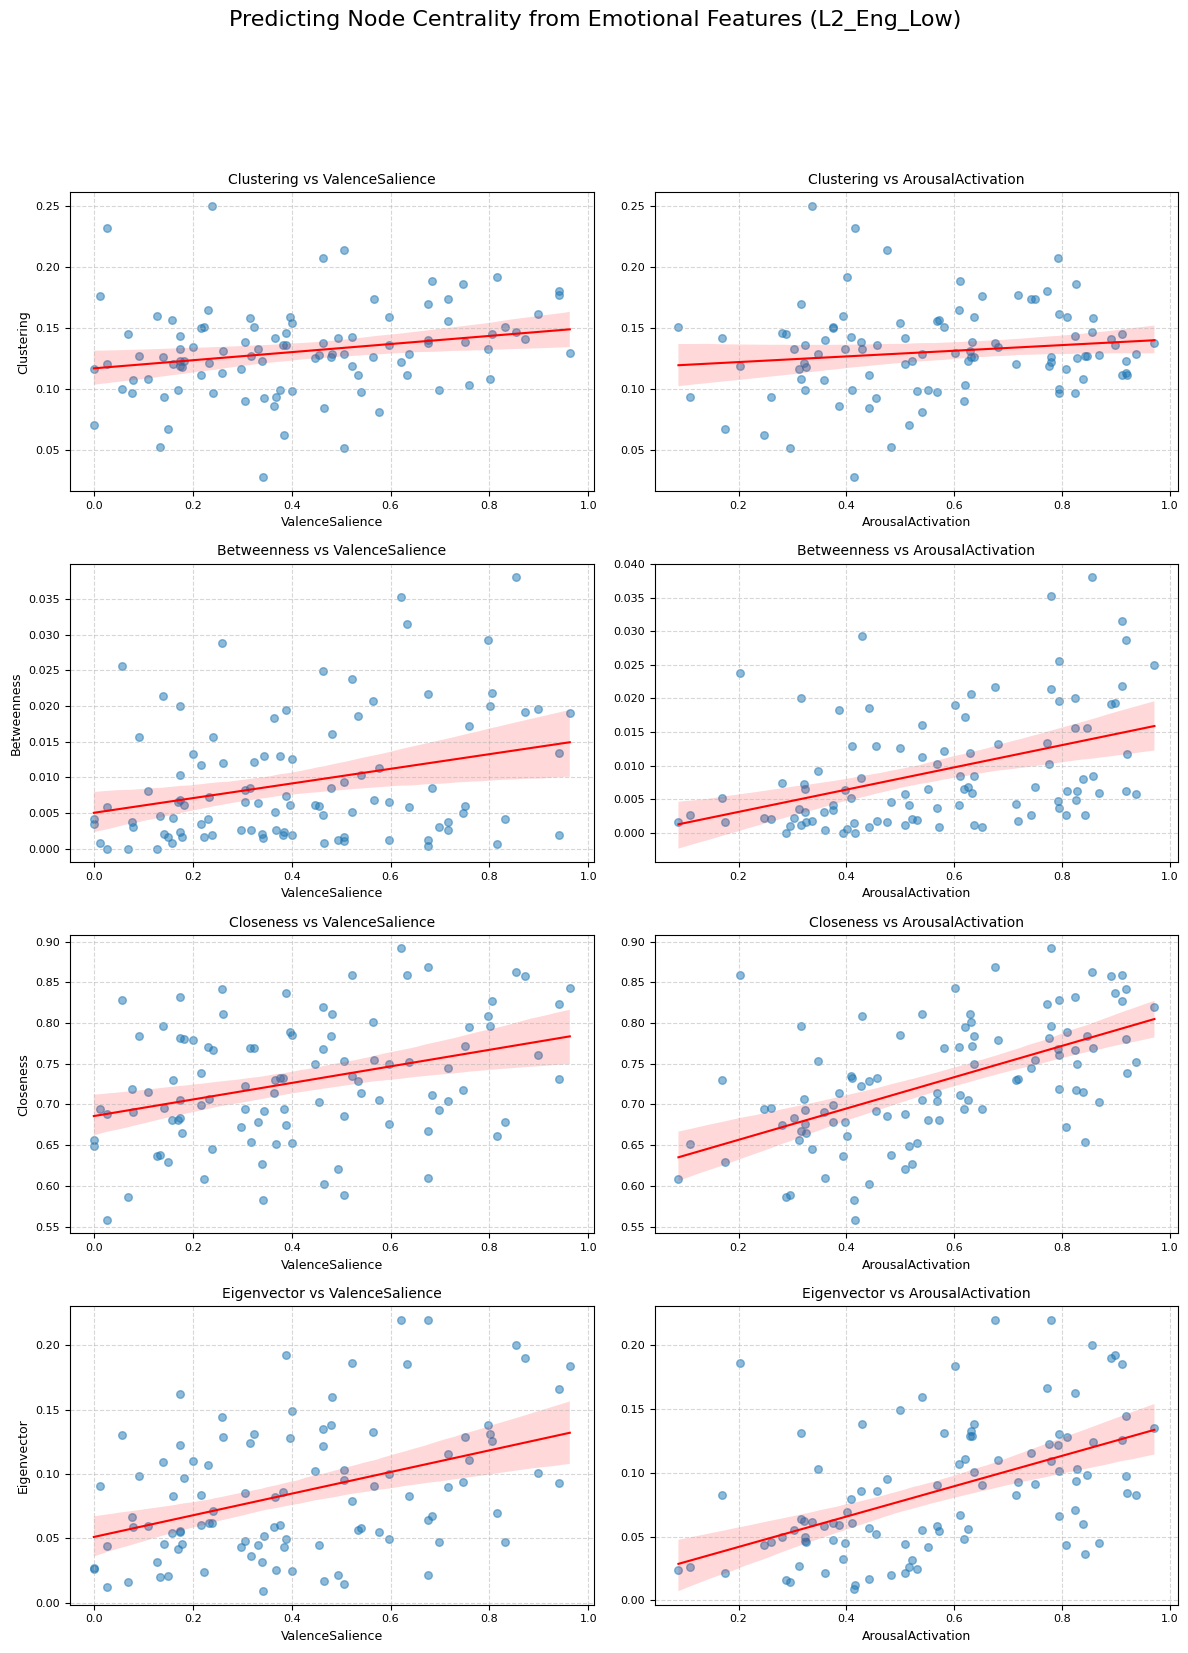


--- Regression Analysis & Visualization End ---


In [16]:
# --- Cell 16: Regression & Visualization: Predicting Node Centrality ---

import statsmodels.formula.api as smf
import statsmodels.api as sm

print("\n--- Running Regression Analysis & Visualization ---")
print("Predicting Node Centrality ~ Valence Salience + Arousal Activation")

# --- Check Prerequisites ---
if 'selected_words_en' not in locals() or not selected_words_en:
    print("ERROR: 'selected_words_en' not found. Please run Cell 5.")
elif 'ratings_en_dict' not in locals() or not ratings_en_dict:
    print("ERROR: 'ratings_en_dict' not found. Please run Cell 4.")
elif 'graphs' not in locals() or not graphs:
    print("ERROR: 'graphs' dictionary not found. Please run Cell 6 (Emotion Boost version).")
else:
    print("Prerequisites found. Proceeding with analysis.")

    # --- 1. Calculate Predictors: Valence Salience & Arousal Activation ---
    predictor_data = {}
    VALENCE_MIDPOINT = 5.0
    AROUSAL_MIN = 1.0
    # Determine actual scale ranges from data
    all_vals = [r['Valence'] for r in ratings_en_dict.values() if pd.notna(r.get('Valence'))]
    all_aros = [r['Arousal'] for r in ratings_en_dict.values() if pd.notna(r.get('Arousal'))]
    max_val_dist_from_mid = max(abs(min(all_vals) - VALENCE_MIDPOINT), abs(max(all_vals) - VALENCE_MIDPOINT)) if all_vals else 4.0
    max_aro_dist_from_min = (max(all_aros) - AROUSAL_MIN) if all_aros else 8.0
    if max_val_dist_from_mid < 1e-9: max_val_dist_from_mid = 4.0
    if max_aro_dist_from_min < 1e-9: max_aro_dist_from_min = 8.0

    print("Calculating predictor variables (Valence Salience, Arousal Activation)...")
    for word in selected_words_en:
        if word in ratings_en_dict and \
           pd.notna(ratings_en_dict[word].get('Valence')) and \
           pd.notna(ratings_en_dict[word].get('Arousal')):
            v_i = ratings_en_dict[word]['Valence']
            a_i = ratings_en_dict[word]['Arousal']
            val_sal = abs(v_i - VALENCE_MIDPOINT) / max_val_dist_from_mid
            aro_act = max(0.0, a_i - AROUSAL_MIN) / max_aro_dist_from_min
            predictor_data[word] = {
                'ValenceSalience': max(0.0, min(1.0, val_sal)),
                'ArousalActivation': max(0.0, min(1.0, aro_act))
            }
        else:
            predictor_data[word] = {'ValenceSalience': np.nan, 'ArousalActivation': np.nan}

    predictor_df = pd.DataFrame.from_dict(predictor_data, orient='index')
    predictor_df.index.name = 'Word'
    print(f"Calculated predictors for {len(predictor_df.dropna())} words.")

    # --- 2. Calculate Outcome Variables (Node Centralities) ---
    centrality_data = {}
    conditions_to_analyze = ['L1_Eng_Adv', 'L2_Eng_Adv', 'L2_Eng_Low']
    INT_SCALE_FACTOR = 10000

    print("Calculating outcome variables (Node Centralities)...")
    for condition in conditions_to_analyze:
        if condition not in graphs: print(f"Warning: Graph for '{condition}' not found."); continue
        G = graphs[condition].copy()
        print(f"Processing graph: {condition} ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")
        node_metrics = {word: {} for word in G.nodes()}

        # Clustering
        try:
            clustering_dict = nx.clustering(G, weight='weight')
            for node, value in clustering_dict.items(): node_metrics[node]['Clustering'] = value
        except Exception as e: print(f"  - Warn: Clustering failed for {condition}: {e}")

        # Prep for Centrality
        largest_cc_subgraph = None; nodes_in_lcc = set(G.nodes()); distance_attr_added = False; int_distance_attr_added = False
        if G.number_of_nodes() > 1 and G.number_of_edges() > 0:
            if nx.is_connected(G): largest_cc_subgraph = G
            else:
                components = list(nx.connected_components(G))
                if components:
                    largest_cc_nodes = max(components, key=len)
                    if len(largest_cc_nodes) > 1: largest_cc_subgraph = G.subgraph(largest_cc_nodes).copy(); nodes_in_lcc = largest_cc_nodes
                    else: largest_cc_subgraph = None
                else: largest_cc_subgraph = None
            if largest_cc_subgraph is not None:
                try:
                    max_similarity = 1.0
                    for u, v, data in largest_cc_subgraph.edges(data=True):
                        similarity = data.get('weight', 0.0); distance = max_similarity - similarity if isinstance(similarity, (int, float)) and 0.0 <= similarity <= max_similarity else max_similarity
                        if distance <= 0: distance = 1e-9
                        largest_cc_subgraph[u][v]['distance'] = distance
                        int_distance = int(distance * INT_SCALE_FACTOR); largest_cc_subgraph[u][v]['int_distance'] = max(1, int_distance) if distance > 0 else 0
                    distance_attr_added = True; int_distance_attr_added = True
                except Exception as e: print(f"  - Warn: Dist attr failed for {condition}: {e}")

        # Centrality Calculations
        centrality_keys = ['Betweenness', 'Closeness', 'Eigenvector']
        if largest_cc_subgraph is not None:
            if int_distance_attr_added:
                try:
                    between_dict = nx.betweenness_centrality(largest_cc_subgraph, weight='int_distance', normalized=True)
                    for node, value in between_dict.items(): node_metrics[node]['Betweenness'] = value
                except Exception as e: print(f"  - Warn: Betweenness failed for {condition}: {e}")
            if distance_attr_added:
                try:
                    close_dict = nx.closeness_centrality(largest_cc_subgraph, distance='distance')
                    for node, value in close_dict.items(): node_metrics[node]['Closeness'] = value
                except Exception as e: print(f"  - Warn: Closeness failed for {condition}: {e}")
            try:
                eigen_dict = nx.eigenvector_centrality(largest_cc_subgraph, weight='weight', max_iter=1000, tol=1e-06)
                for node, value in eigen_dict.items(): node_metrics[node]['Eigenvector'] = value
            except nx.PowerIterationFailedConvergence: print(f"  - Warn: Eigenvector did not converge for {condition}.")
            except Exception as e: print(f"  - Warn: Eigenvector failed for {condition}: {e}")

        # Assign NaN and ensure keys exist
        for node in G.nodes():
            if node not in nodes_in_lcc:
                for key in centrality_keys: node_metrics[node][key] = np.nan
            else:
                 for key in centrality_keys:
                      if key not in node_metrics[node]: node_metrics[node][key] = np.nan
            # Ensure Clustering key exists
            if 'Clustering' not in node_metrics[node]: node_metrics[node]['Clustering'] = np.nan

        centrality_data[condition] = pd.DataFrame.from_dict(node_metrics, orient='index')
        centrality_data[condition].index.name = 'Word'

    # --- 3. Run Regression Models & Generate Plots ---
    print("\n--- Regression Model Summaries & Visualizations ---")
    outcome_vars = ['Clustering', 'Betweenness', 'Closeness', 'Eigenvector']
    predictor_vars = ['ValenceSalience', 'ArousalActivation']

    for condition in conditions_to_analyze:
        print(f"\n{'='*15} Condition: {condition} {'='*15}")
        if condition not in centrality_data: print("  No data."); continue

        merged_df = predictor_df.join(centrality_data[condition], on='Word')

        # Create a figure for this condition's plots
        num_outcomes = len(outcome_vars)
        num_predictors = len(predictor_vars)
        fig, axes = plt.subplots(num_outcomes, num_predictors, figsize=(12, 4 * num_outcomes))
        fig.suptitle(f"Predicting Node Centrality from Emotional Features ({condition})", fontsize=16, y=1.03)

        for i, outcome in enumerate(outcome_vars):
            print(f"\n--- Predicting: {outcome} ---")
            if outcome not in merged_df.columns: print(f"  Outcome '{outcome}' not found."); continue

            regression_df = merged_df[predictor_vars + [outcome]].dropna()

            if len(regression_df) < 3: print(f"  Not enough data ({len(regression_df)})."); continue
            if regression_df[outcome].nunique() <= 1: print(f"  Outcome '{outcome}' constant."); continue
            if regression_df[predictor_vars[0]].nunique() <= 1 and regression_df[predictor_vars[1]].nunique() <= 1: print(f"  Predictors constant."); continue

            formula = f"Q('{outcome}') ~ ValenceSalience + ArousalActivation"
            try:
                model = smf.ols(formula=formula, data=regression_df).fit()
                print(model.summary())

                # --- Create Scatter Plots with Regression Line ---
                for j, predictor in enumerate(predictor_vars):
                    ax = axes[i, j]
                    sns.regplot(x=predictor, y=outcome, data=regression_df, ax=ax,
                                scatter_kws={'alpha':0.5, 's':30},
                                line_kws={'color':'red', 'lw':1.5})
                    ax.set_title(f"{outcome} vs {predictor}", fontsize=10)
                    ax.set_xlabel(predictor, fontsize=9)
                    ax.set_ylabel(outcome if j == 0 else "", fontsize=9) # Only label y-axis on left plot
                    ax.tick_params(axis='both', which='major', labelsize=8)
                    ax.grid(True, linestyle='--', alpha=0.5)

            except Exception as e:
                print(f"  Error running regression/plotting for {outcome}: {e}")
                # Make sure axes exist even if regression fails, to avoid layout errors
                for j, predictor in enumerate(predictor_vars):
                     if i < axes.shape[0] and j < axes.shape[1]:
                          ax = axes[i, j]
                          ax.text(0.5, 0.5, 'Error', ha='center', va='center', transform=ax.transAxes)
                          ax.set_title(f"{outcome} vs {predictor}", fontsize=10)


        # Adjust layout for the figure
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect for suptitle
        plt.show()

    print("\n--- Regression Analysis & Visualization End ---")



# 17. Word Association Simulations and OLS Regression Models


In [17]:
# =============================================================================
# Cell 17: Regression Analysis of Simulated Word Associations (Table as PNG)
# =============================================================================
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.formula.api as smf # For regression models
import statsmodels.api as sm # For adding constant
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For enhanced plotting
import random # For sampling
import os # For file paths

print("\n--- Running Regression Analysis on Simulated Word Associations ---")

# --- Parameters ---
NUM_CUE_WORDS_TO_SAMPLE = 100 # Number of cue words to sample per condition

# --- Helper function to get average associate features ---
def get_avg_associate_features(G, cue_word, feature_dict, feature_keys):
    associates = list(G.neighbors(cue_word))
    if not associates: return {f"AvgAssociate{key}": np.nan for key in feature_keys}
    avg_features = {key: [] for key in feature_keys}; valid_associates_count = 0
    for assoc in associates:
        if assoc in feature_dict:
            is_valid_assoc = True; current_assoc_features = {}
            for key in feature_keys:
                val = feature_dict[assoc].get(key, np.nan)
                if pd.isna(val): is_valid_assoc = False; break
                current_assoc_features[key] = val
            if is_valid_assoc:
                valid_associates_count +=1
                for key in feature_keys: avg_features[key].append(current_assoc_features[key])
    if valid_associates_count == 0: return {f"AvgAssociate{key}": np.nan for key in feature_keys}
    return {f"AvgAssociate{key}": np.mean(avg_features[key]) for key in feature_keys}

# --- List to store detailed regression results for summary table ---
detailed_regression_outputs = []

# --- 1. Analysis for Emotion-Boost Model ---
print("\n\n=== I. Emotion-Boost Model Association Analysis ===")
if 'graphs' not in locals() or not graphs or \
   'ratings_en_dict' not in locals() or not ratings_en_dict or \
   'selected_words_en' not in locals() or not selected_words_en:
    print("ERROR: Prerequisites for Emotion-Boost analysis missing.")
else:
    emotion_association_data = []
    emotion_conditions = ['L1_Eng_Adv', 'L2_Eng_Adv', 'L2_Eng_Low']
    reference_condition_emotion = 'L1_Eng_Adv'

    for condition in emotion_conditions:
        if condition not in graphs: print(f"Skipping emotion condition {condition}: Graph not found."); continue
        G = graphs[condition]
        potential_cues = [w for w in selected_words_en if w in G and w in ratings_en_dict and pd.notna(ratings_en_dict[w].get('Valence')) and pd.notna(ratings_en_dict[w].get('Arousal'))]
        if not potential_cues: print(f"No valid cue words for {condition}."); continue
        num_to_sample = min(NUM_CUE_WORDS_TO_SAMPLE, len(potential_cues))
        random.seed(42); cue_sample = random.sample(potential_cues, num_to_sample)
        print(f"Processing {condition}: Sampled {len(cue_sample)} cue words.")
        for cue in cue_sample:
            cue_features = ratings_en_dict[cue]
            avg_assoc_features = get_avg_associate_features(G, cue, ratings_en_dict, ['Valence', 'Arousal'])
            emotion_association_data.append({'Condition': condition, 'CueWord': cue, 'CueValence': cue_features.get('Valence'), 'CueArousal': cue_features.get('Arousal'), 'AvgAssociateValence': avg_assoc_features.get('AvgAssociateValence'), 'AvgAssociateArousal': avg_assoc_features.get('AvgAssociateArousal')})
    emotion_assoc_df = pd.DataFrame(emotion_association_data).dropna()

    if not emotion_assoc_df.empty and len(emotion_assoc_df['Condition'].unique()) > 1:
        emotion_assoc_df['Condition'] = pd.Categorical(emotion_assoc_df['Condition'], categories=emotion_conditions, ordered=True)

        # Valence Model
        print(f"\n--- Regression: Cue Valence -> Avg Associate Valence (Emotion Model) ---")
        try:
            model_v = smf.ols(f"AvgAssociateValence ~ CueValence * C(Condition, Treatment(reference='{reference_condition_emotion}'))", data=emotion_assoc_df).fit()
            print(model_v.summary())
            detailed_regression_outputs.append({'Model': 'Emotion-Boost', 'Outcome': 'Avg. Assoc. Valence', 'Adj_R_squared': model_v.rsquared_adj, 'results_object': model_v})
        except Exception as e: print(f"Error running Valence regression: {e}")

        # Arousal Model
        print(f"\n--- Regression: Cue Arousal -> Avg Associate Arousal (Emotion Model) ---")
        try:
            model_a = smf.ols(f"AvgAssociateArousal ~ CueArousal * C(Condition, Treatment(reference='{reference_condition_emotion}'))", data=emotion_assoc_df).fit()
            print(model_a.summary())
            detailed_regression_outputs.append({'Model': 'Emotion-Boost', 'Outcome': 'Avg. Assoc. Arousal', 'Adj_R_squared': model_a.rsquared_adj, 'results_object': model_a})
        except Exception as e: print(f"Error running Arousal regression: {e}")
    else: print("Not enough data for emotion model regressions.")

# --- 2. Analysis for Centrality-Boost Model ---
print("\n\n=== II. Centrality-Boost Model Association Analysis ===")
if 'control_graphs' not in locals() or not control_graphs or \
   'baseline_centralities' not in locals() or not baseline_centralities or \
   'control_nodes' not in locals() or not control_nodes:
    print("ERROR: Prerequisites for Centrality-Boost analysis missing.")
else:
    centrality_association_data = []
    centrality_conditions = ['L1_Low_Ctrl', 'L1_Adv_Ctrl', 'L2_Adv_Ctrl', 'L2_Low_Ctrl']
    reference_condition_centrality = 'L1_Adv_Ctrl'
    baseline_feature_keys = ['ActualEigenvector', 'ActualCloseness']

    for condition in centrality_conditions:
        if condition not in control_graphs: print(f"Skipping centrality condition {condition}: Graph not found."); continue
        G_ctrl = control_graphs[condition]
        potential_cues_ctrl = [w for w in control_nodes if w in G_ctrl and w in baseline_centralities and pd.notna(baseline_centralities[w].get('ActualEigenvector')) and pd.notna(baseline_centralities[w].get('ActualCloseness'))]
        if not potential_cues_ctrl: print(f"No valid cue nodes for {condition}."); continue
        num_to_sample_ctrl = min(NUM_CUE_WORDS_TO_SAMPLE, len(potential_cues_ctrl))
        random.seed(43); cue_sample_ctrl = random.sample(potential_cues_ctrl, num_to_sample_ctrl)
        print(f"Processing {condition}: Sampled {len(cue_sample_ctrl)} cue nodes.")
        for cue in cue_sample_ctrl:
            cue_baseline_features = baseline_centralities[cue]
            avg_assoc_baseline_features = get_avg_associate_features(G_ctrl, cue, baseline_centralities, baseline_feature_keys)
            centrality_association_data.append({'Condition': condition, 'CueNode': cue, 'CueEigenvector': cue_baseline_features.get('ActualEigenvector'), 'CueCloseness': cue_baseline_features.get('ActualCloseness'), 'AvgAssociateEigenvector': avg_assoc_baseline_features.get('AvgAssociateActualEigenvector'), 'AvgAssociateCloseness': avg_assoc_baseline_features.get('AvgAssociateActualCloseness')})
    centrality_assoc_df = pd.DataFrame(centrality_association_data).dropna()

    if not centrality_assoc_df.empty and len(centrality_assoc_df['Condition'].unique()) > 1:
        centrality_assoc_df['Condition'] = pd.Categorical(centrality_assoc_df['Condition'], categories=centrality_conditions, ordered=True)

        # Eigenvector Model
        print(f"\n--- Regression: Cue Baseline Eigenvector -> Avg Associate Baseline Eigenvector (Centrality Model) ---")
        try:
            model_ce = smf.ols(f"AvgAssociateEigenvector ~ CueEigenvector * C(Condition, Treatment(reference='{reference_condition_centrality}'))", data=centrality_assoc_df).fit()
            print(model_ce.summary())
            detailed_regression_outputs.append({'Model': 'Centrality-Boost', 'Outcome': 'Avg. Assoc. Eigenvector', 'Adj_R_squared': model_ce.rsquared_adj, 'results_object': model_ce})
        except Exception as e: print(f"Error running Eigenvector regression: {e}")

        # Closeness Model
        print(f"\n--- Regression: Cue Baseline Closeness -> Avg Associate Baseline Closeness (Centrality Model) ---")
        try:
            model_cc = smf.ols(f"AvgAssociateCloseness ~ CueCloseness * C(Condition, Treatment(reference='{reference_condition_centrality}'))", data=centrality_assoc_df).fit()
            print(model_cc.summary())
            detailed_regression_outputs.append({'Model': 'Centrality-Boost', 'Outcome': 'Avg. Assoc. Closeness', 'Adj_R_squared': model_cc.rsquared_adj, 'results_object': model_cc})
        except Exception as e: print(f"Error running Closeness regression: {e}")
    else: print("Not enough data for centrality model regressions.")


# --- 3. Create and Display Publication-Style Summary Table (Markdown & PNG) ---
def format_p_value(p_val):
    """Formats p-value with significance stars."""
    if p_val < 0.001: return f"{p_val:.3f}***"
    if p_val < 0.01: return f"{p_val:.3f}**"
    if p_val < 0.05: return f"{p_val:.3f}*"
    return f"{p_val:.3f}"

def create_summary_table_df(reg_outputs_list, ref_emo, ref_cent):
    """Creates a DataFrame from regression results for table generation."""
    table_data = []
    term_map = { # Define term mappings inside or pass as argument
            'Intercept': 'Intercept', 'CueValence': 'Cue Valence', 'CueArousal': 'Cue Arousal',
            'CueEigenvector': 'Cue Eigenvector (BL)', 'CueCloseness': 'Cue Closeness (BL)',
            f"C(Condition, Treatment(reference='{ref_emo}'))[T.L2_Eng_Adv]": f"Cond: L2 Adv (vs {ref_emo.replace('_Eng_','')})",
            f"C(Condition, Treatment(reference='{ref_emo}'))[T.L2_Eng_Low]": f"Cond: L2 Low (vs {ref_emo.replace('_Eng_','')})",
            f"CueValence:C(Condition, Treatment(reference='{ref_emo}'))[T.L2_Eng_Adv]": f"Cue Valence x L2 Adv",
            f"CueValence:C(Condition, Treatment(reference='{ref_emo}'))[T.L2_Eng_Low]": f"Cue Valence x L2 Low",
            f"CueArousal:C(Condition, Treatment(reference='{ref_emo}'))[T.L2_Eng_Adv]": f"Cue Arousal x L2 Adv",
            f"CueArousal:C(Condition, Treatment(reference='{ref_emo}'))[T.L2_Eng_Low]": f"Cue Arousal x L2 Low",
            f"C(Condition, Treatment(reference='{ref_cent}'))[T.L1_Low_Ctrl]": f"Cond: L1 Low (vs {ref_cent.replace('_Ctrl','')})",
            f"C(Condition, Treatment(reference='{ref_cent}'))[T.L2_Adv_Ctrl]": f"Cond: L2 Adv (vs {ref_cent.replace('_Ctrl','')})",
            f"C(Condition, Treatment(reference='{ref_cent}'))[T.L2_Low_Ctrl]": f"Cond: L2 Low (vs {ref_cent.replace('_Ctrl','')})",
            f"CueEigenvector:C(Condition, Treatment(reference='{ref_cent}'))[T.L1_Low_Ctrl]": f"Cue Eigen x L1 Low",
            f"CueEigenvector:C(Condition, Treatment(reference='{ref_cent}'))[T.L2_Adv_Ctrl]": f"Cue Eigen x L2 Adv",
            f"CueEigenvector:C(Condition, Treatment(reference='{ref_cent}'))[T.L2_Low_Ctrl]": f"Cue Eigen x L2 Low",
            f"CueCloseness:C(Condition, Treatment(reference='{ref_cent}'))[T.L1_Low_Ctrl]": f"Cue Close x L1 Low",
            f"CueCloseness:C(Condition, Treatment(reference='{ref_cent}'))[T.L2_Adv_Ctrl]": f"Cue Close x L2 Adv",
            f"CueCloseness:C(Condition, Treatment(reference='{ref_cent}'))[T.L2_Low_Ctrl]": f"Cue Close x L2 Low",
        }

    for reg_output in reg_outputs_list:
        model_results = reg_output['results_object']
        model_info = f"{reg_output['Model']} - {reg_output['Outcome']} (Adj. R² = {reg_output['Adj_R_squared']:.3f})"
        for term in model_results.params.index:
            clean_term = term_map.get(term, term)
            table_data.append({
                'Model Info': model_info,
                'Predictor Term': clean_term,
                'Coefficient (B)': model_results.params[term],
                'Std. Error (SE)': model_results.bse[term],
                't-statistic': model_results.tvalues[term],
                'p-value': model_results.pvalues[term]
            })
    return pd.DataFrame(table_data)


def save_df_as_png(df, filename="regression_summary.png", title="Regression Summary"):
    """Saves a Pandas DataFrame as a PNG image using matplotlib table."""
    if df.empty:
        print(f"DataFrame is empty, cannot save {filename}.")
        return

    # Create a figure and an axes
    fig, ax = plt.subplots(figsize=(12, max(4, len(df) * 0.5))) # Adjust figsize as needed
    ax.axis('tight')
    ax.axis('off')

    # Create the table
    the_table = ax.table(cellText=df.values,
                         colLabels=df.columns,
                         rowLabels=[f"R{i}" for i in df.index], # Generic row labels
                         loc='center',
                         cellLoc='left', # Align text left in cells
                         colLoc='center') # Align column headers center

    # Style the table
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(8) # Adjust font size
    the_table.auto_set_column_width(col=list(range(len(df.columns)))) # Adjust column widths

    # Make header bold
    for (i, j), cell in the_table.get_celld().items():
        if i == 0: # Header row
            cell.set_text_props(weight='bold')

    plt.title(title, fontsize=14, y=1.05) # Add title to the figure
    plt.tight_layout(pad=1.0) # Add some padding

    # Ensure BASE_OUTPUT_DIR is defined
    if 'BASE_OUTPUT_DIR' not in locals():
        BASE_OUTPUT_DIR = "colab_output"
        os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)
        print(f"BASE_OUTPUT_DIR was not defined, using default: {BASE_OUTPUT_DIR}")

    filepath = os.path.join(BASE_OUTPUT_DIR, filename)
    try:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Regression summary table saved as PNG: {filepath}")
    except Exception as e:
        print(f"Error saving table as PNG: {e}")
    plt.close(fig) # Close the figure to free memory


if detailed_regression_outputs:
    print("\n\n--- Publication-Style Summary Table of Regression Effects (Markdown & PNG) ---")

    # Generate DataFrame for the table
    summary_table_df = create_summary_table_df(detailed_regression_outputs, reference_condition_emotion, reference_condition_centrality)

    # Create and display Markdown table
    markdown_lines = []
    current_model_info = ""
    for index, row in summary_table_df.iterrows():
        if row['Model Info'] != current_model_info:
            if current_model_info: markdown_lines.append("---") # Separator
            current_model_info = row['Model Info']
            markdown_lines.append(f"\n**{current_model_info}**")
            markdown_lines.append("| Predictor Term | Coefficient (B) | Std. Error (SE) | t-statistic | p-value |")
            markdown_lines.append("|---|---|---|---|---|")

        p_formatted = format_p_value(row['p-value'])
        markdown_lines.append(f"| {row['Predictor Term']} | {row['Coefficient (B)']:.3f} | {row['Std. Error (SE)']:.3f} | {row['t-statistic']:.2f} | {p_formatted} |")

    from IPython.display import Markdown, display as display_markdown
    if markdown_lines:
        display_markdown(Markdown('\n'.join(markdown_lines)))
    else:
        print("No data to display in Markdown table.")

    # --- Save the DataFrame as a PNG ---
    # Prepare a slightly different DataFrame for PNG to avoid multi-index issues with plt.table
    png_df_data = []
    for reg_output in detailed_regression_outputs:
        model_results = reg_output['results_object']
        model_header = f"{reg_output['Model']} - {reg_output['Outcome']} (Adj. R² = {reg_output['Adj_R_squared']:.3f})"
        png_df_data.append({'Predictor Term': model_header, 'Coefficient (B)': '', 'Std. Error (SE)': '', 't-statistic': '', 'p-value': ''}) # Header row

        term_map = { # Copied from create_summary_table_df for consistency
            'Intercept': 'Intercept', 'CueValence': 'Cue Valence', 'CueArousal': 'Cue Arousal',
            'CueEigenvector': 'Cue Eigenvector (BL)', 'CueCloseness': 'Cue Closeness (BL)',
            f"C(Condition, Treatment(reference='{reference_condition_emotion}'))[T.L2_Eng_Adv]": f"Cond: L2 Adv (vs {reference_condition_emotion.replace('_Eng_','')})",
            f"C(Condition, Treatment(reference='{reference_condition_emotion}'))[T.L2_Eng_Low]": f"Cond: L2 Low (vs {reference_condition_emotion.replace('_Eng_','')})",
            f"CueValence:C(Condition, Treatment(reference='{reference_condition_emotion}'))[T.L2_Eng_Adv]": f"Cue Valence x L2 Adv",
            f"CueValence:C(Condition, Treatment(reference='{reference_condition_emotion}'))[T.L2_Eng_Low]": f"Cue Valence x L2 Low",
            f"CueArousal:C(Condition, Treatment(reference='{reference_condition_emotion}'))[T.L2_Eng_Adv]": f"Cue Arousal x L2 Adv",
            f"CueArousal:C(Condition, Treatment(reference='{reference_condition_emotion}'))[T.L2_Eng_Low]": f"Cue Arousal x L2 Low",
            f"C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L1_Low_Ctrl]": f"Cond: L1 Low (vs {reference_condition_centrality.replace('_Ctrl','')})",
            f"C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L2_Adv_Ctrl]": f"Cond: L2 Adv (vs {reference_condition_centrality.replace('_Ctrl','')})",
            f"C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L2_Low_Ctrl]": f"Cond: L2 Low (vs {reference_condition_centrality.replace('_Ctrl','')})",
            f"CueEigenvector:C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L1_Low_Ctrl]": f"Cue Eigen x L1 Low",
            f"CueEigenvector:C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L2_Adv_Ctrl]": f"Cue Eigen x L2 Adv",
            f"CueEigenvector:C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L2_Low_Ctrl]": f"Cue Eigen x L2 Low",
            f"CueCloseness:C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L1_Low_Ctrl]": f"Cue Close x L1 Low",
            f"CueCloseness:C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L2_Adv_Ctrl]": f"Cue Close x L2 Adv",
            f"CueCloseness:C(Condition, Treatment(reference='{reference_condition_centrality}'))[T.L2_Low_Ctrl]": f"Cue Close x L2 Low",
        }
        for term in model_results.params.index:
            png_df_data.append({
                'Predictor Term': term_map.get(term, term),
                'Coefficient (B)': f"{model_results.params[term]:.3f}",
                'Std. Error (SE)': f"{model_results.bse[term]:.3f}",
                't-statistic': f"{model_results.tvalues[term]:.2f}",
                'p-value': format_p_value(model_results.pvalues[term])
            })
        png_df_data.append({'Predictor Term': '---', 'Coefficient (B)': '---', 'Std. Error (SE)': '---', 't-statistic': '---', 'p-value': '---'}) # Separator

    if png_df_data:
        png_summary_table = pd.DataFrame(png_df_data)
        # Remove the last separator row for cleaner PNG
        if not png_summary_table.empty and png_summary_table.iloc[-1]['Predictor Term'] == '---':
            png_summary_table = png_summary_table.iloc[:-1]

        save_df_as_png(png_summary_table, filename="all_regression_summary.png", title="Summary of Regression Effects")
    else:
        print("No data to generate PNG table.")

else:
    print("\nNo regression results collected to summarize.")

print("\n--- Association Regression Analysis End ---")



--- Running Regression Analysis on Simulated Word Associations ---


=== I. Emotion-Boost Model Association Analysis ===
Processing L1_Eng_Adv: Sampled 100 cue words.
Processing L2_Eng_Adv: Sampled 100 cue words.
Processing L2_Eng_Low: Sampled 100 cue words.

--- Regression: Cue Valence -> Avg Associate Valence (Emotion Model) ---
                             OLS Regression Results                            
Dep. Variable:     AvgAssociateValence   R-squared:                       0.451
Model:                             OLS   Adj. R-squared:                  0.441
Method:                  Least Squares   F-statistic:                     48.23
Date:                 Thu, 15 May 2025   Prob (F-statistic):           2.39e-36
Time:                         18:41:48   Log-Likelihood:                -245.76
No. Observations:                  300   AIC:                             503.5
Df Residuals:                      294   BIC:                             525.8
Df Model:                 


**Emotion-Boost - Avg. Assoc. Valence (Adj. R² = 0.441)**
| Predictor Term | Coefficient (B) | Std. Error (SE) | t-statistic | p-value |
|---|---|---|---|---|
| Intercept | 2.948 | 0.155 | 19.00 | 0.000*** |
| Cond: L2 Adv (vs L1Adv) | 0.206 | 0.219 | 0.94 | 0.350 |
| Cond: L2 Low (vs L1Adv) | 0.546 | 0.219 | 2.49 | 0.013* |
| Cue Valence | 0.328 | 0.031 | 10.49 | 0.000*** |
| Cue Valence x L2 Adv | -0.041 | 0.044 | -0.94 | 0.350 |
| Cue Valence x L2 Low | -0.114 | 0.044 | -2.58 | 0.010* |
---

**Emotion-Boost - Avg. Assoc. Arousal (Adj. R² = 0.256)**
| Predictor Term | Coefficient (B) | Std. Error (SE) | t-statistic | p-value |
|---|---|---|---|---|
| Intercept | 4.319 | 0.137 | 31.57 | 0.000*** |
| Cond: L2 Adv (vs L1Adv) | 0.054 | 0.193 | 0.28 | 0.781 |
| Cond: L2 Low (vs L1Adv) | 0.170 | 0.193 | 0.88 | 0.380 |
| Cue Arousal | 0.181 | 0.027 | 6.77 | 0.000*** |
| Cue Arousal x L2 Adv | -0.019 | 0.038 | -0.50 | 0.614 |
| Cue Arousal x L2 Low | -0.056 | 0.038 | -1.47 | 0.142 |
---

**Centrality-Boost - Avg. Assoc. Eigenvector (Adj. R² = 0.160)**
| Predictor Term | Coefficient (B) | Std. Error (SE) | t-statistic | p-value |
|---|---|---|---|---|
| Intercept | 0.088 | 0.002 | 37.85 | 0.000*** |
| Cond: L1 Low (vs L1_Adv) | -0.001 | 0.003 | -0.36 | 0.718 |
| Cond: L2 Adv (vs L1_Adv) | 0.005 | 0.003 | 1.36 | 0.174 |
| Cond: L2 Low (vs L1_Adv) | 0.010 | 0.003 | 2.91 | 0.004** |
| Cue Eigenvector (BL) | 0.120 | 0.023 | 5.15 | 0.000*** |
| Cue Eigen x L1 Low | 0.011 | 0.033 | 0.35 | 0.730 |
| Cue Eigen x L2 Adv | -0.040 | 0.033 | -1.21 | 0.228 |
| Cue Eigen x L2 Low | -0.080 | 0.033 | -2.42 | 0.016* |
---

**Centrality-Boost - Avg. Assoc. Closeness (Adj. R² = 0.877)**
| Predictor Term | Coefficient (B) | Std. Error (SE) | t-statistic | p-value |
|---|---|---|---|---|
| Intercept | 12.107 | 0.411 | 29.47 | 0.000*** |
| Cond: L1 Low (vs L1_Adv) | -1.473 | 0.581 | -2.53 | 0.012* |
| Cond: L2 Adv (vs L1_Adv) | 2.970 | 0.581 | 5.11 | 0.000*** |
| Cond: L2 Low (vs L1_Adv) | 11.369 | 0.581 | 19.56 | 0.000*** |
| Cue Closeness (BL) | 0.514 | 0.016 | 31.61 | 0.000*** |
| Cue Close x L1 Low | 0.059 | 0.023 | 2.57 | 0.010* |
| Cue Close x L2 Adv | -0.119 | 0.023 | -5.16 | 0.000*** |
| Cue Close x L2 Low | -0.451 | 0.023 | -19.63 | 0.000*** |

BASE_OUTPUT_DIR was not defined, using default: colab_output
Regression summary table saved as PNG: colab_output/all_regression_summary.png

--- Association Regression Analysis End ---
